In [1]:
import matplotlib as mpl
from matplotlib import font_manager

# --- Option A: Use installed Times/Times New Roman (portable, no file path needed)
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Liberation Serif", "STIXGeneral"],
    "mathtext.fontset": "stix",  # Times-like math to match
    "mathtext.rm": "STIXGeneral",
    "mathtext.it": "STIXGeneral:italic",
    "mathtext.bf": "STIXGeneral:bold",
})


Creating COCO heatmap...
✅ Saved: coco_improvement_heatmap_R1.png


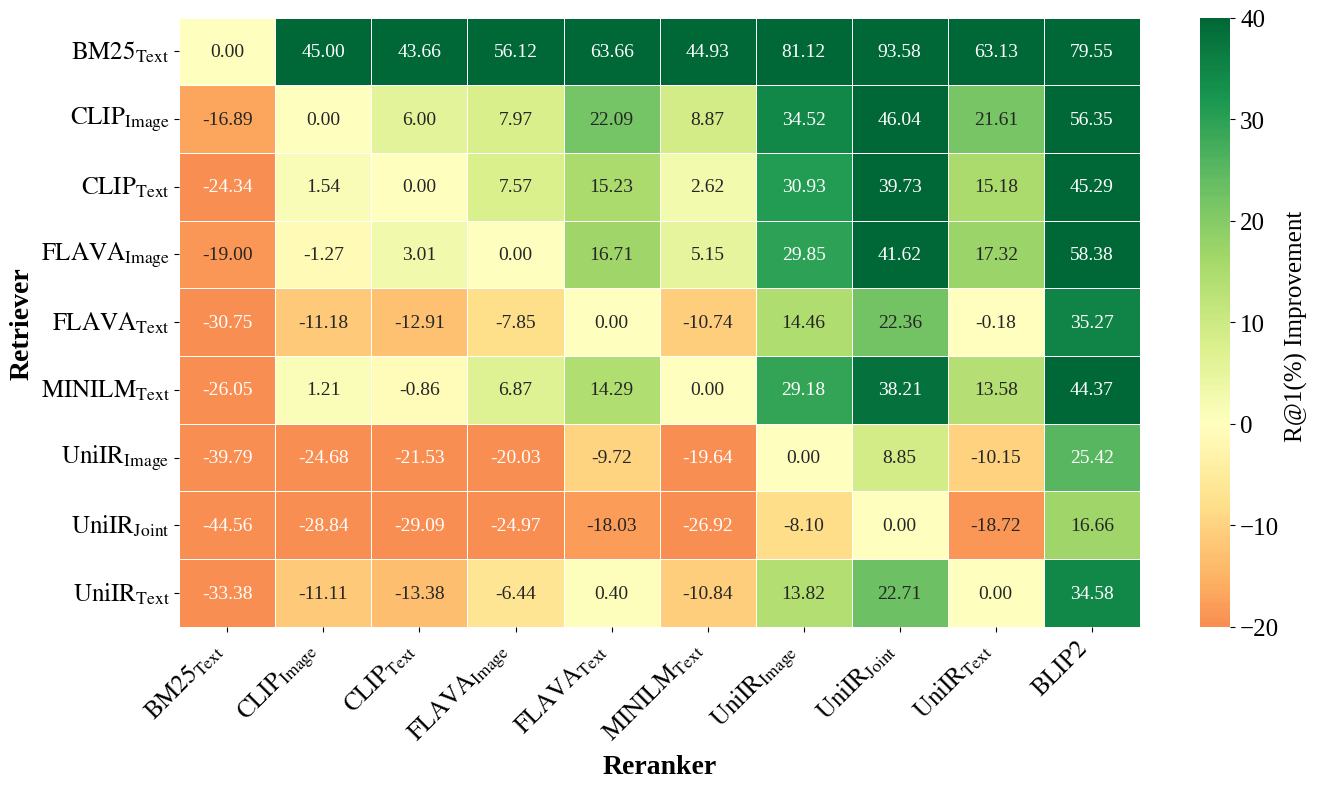


Creating Flickr heatmap...
✅ Saved: flickr_improvement_heatmap_R1.png


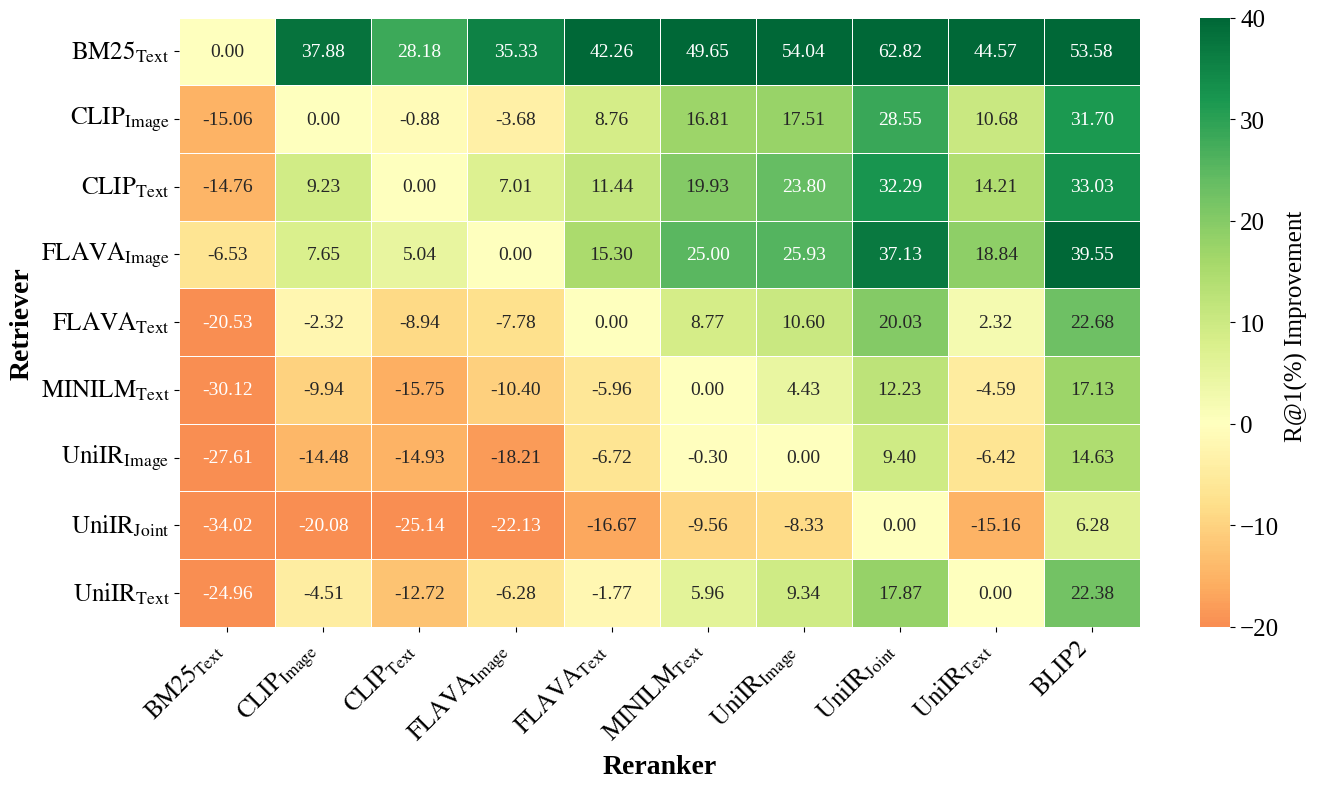


=== COCO Dataset (R@1) ===
Max improvement: 93.58%
Min change: -44.56%
Average improvement: 9.61%

=== Flickr Dataset (R@1) ===
Max improvement: 62.82%
Min change: -34.02%
Average improvement: 6.49%
✅ Saved: coco_improvement_matrix_R1.csv
✅ Saved: flickr_improvement_matrix_R1.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ========= Select which metric to visualize =========
METRIC = "R@1"   # change to "R@1" or "R@5" if you ever want to switch

# ========= Single-stage results (R@10 baselines) =========
# COCO baselines (single stage, R@10)
single_stage_coco = {
    'CLIP-Image': 0.3766,
    'FLAVA-Image': 0.3926,
    'UniIR-Image': 0.5082,
    'CLIP-Text': 0.3886,
    'MINILM-Text': 0.3962,
    'FLAVA-Text': 0.4508,
    'UniIR-Text': 0.4500,
    'UniIR-Joint': 0.5534,
    'BM25-Text': 0.2680
}

single_stage_flickr = {
    'CLIP-Image': 0.5710,
    'FLAVA-Image': 0.5360,
    'UniIR-Image': 0.6700,
    'CLIP-Text': 0.5420,
    'MINILM-Text': 0.6540,
    'FLAVA-Text': 0.6040,
    'UniIR-Text': 0.6210,
    'UniIR-Joint': 0.7320,
    'BM25-Text': 0.4330
}

# ========= Mapping from CSV tokens → display names =========
name_mapping = {
    'clip_image': 'CLIP-Image',
    'clip_text': 'CLIP-Text',
    'flava_image': 'FLAVA-Image',
    'flava_text': 'FLAVA-Text',
    'minilm_text': 'MINILM-Text',
    'uniir_image': 'UniIR-Image',
    'uniir_text': 'UniIR-Text',
    'uniir_joint-image-text': 'UniIR-Joint',
    # BM25 variants
    'bm25_text': 'BM25-Text',
    'bm25': 'BM25-Text',
    # BLIP2 column
    'blip2': 'BLIP2'
}

# Columns we always want to include (and push to the end)
ALWAYS_APPEND_STAGE2 = ['blip2']

# ========= Pretty formatter (upright subscripts) =========
def format_model_name(name: str) -> str:
    if '-' in name:
        base, sub = name.split('-', 1)
        return rf'$\mathrm{{{base}}}_\mathrm{{{sub}}}$'
    return rf'$\mathrm{{{name}}}$'

# ========= Read your two-stage CSV data =========
df_two_stage = pd.read_csv('master_results_faiss.csv')

# ========= Heatmap builder =========
def create_improvement_heatmap(
    df, dataset_name, single_stage_dict,
    metric=METRIC, figsize=(14, 8), save_path=None
):
    df_dataset = df[df['dataset'].str.lower() == dataset_name.lower()].copy()

    # Map stage1 names to display dictionary keys
    df_dataset['stage1_mapped'] = df_dataset['stage1'].map(name_mapping)

    # Build unique sets
    stage1_models = sorted([m for m in df_dataset['stage1_mapped'].dropna().unique()])

    # Stage2 raw keys from CSV
    stage2_models = list(sorted(df_dataset['stage2'].dropna().unique()))
    # Ensure ALWAYS_APPEND columns exist and appear at the end
    for must in ALWAYS_APPEND_STAGE2:
        if must not in stage2_models:
            stage2_models.append(must)
        else:
            stage2_models = [c for c in stage2_models if c != must] + [must]

    # Matrix
    improvement_matrix = pd.DataFrame(
        np.zeros((len(stage1_models), len(stage2_models))),
        index=stage1_models,
        columns=stage2_models
    )

    # Fill with % improvements
    for _, row in df_dataset.iterrows():
        stage1 = row['stage1_mapped']
        stage2 = row['stage2']
        if pd.isna(stage1) or pd.isna(stage2):
            continue

        if metric not in row:
            print(f"WARNING: '{metric}' column not found in CSV; row skipped.")
            continue

        r_two_stage = float(row[metric])

        # Baseline for this stage1 model from single-stage dict
        r_single = single_stage_dict.get(stage1, None)
        if r_single is None:
            print(f"WARNING: Could not find baseline for '{stage1}' in {dataset_name}.")
            continue

        improvement_pct = ((r_two_stage - r_single) / r_single) * 100 if r_single > 0 else 0.0
        if stage2 in improvement_matrix.columns and stage1 in improvement_matrix.index:
            improvement_matrix.loc[stage1, stage2] = improvement_pct

    # ---- No diagonal override ----

    # Pretty dataset label for title
    ds_label = {'coco': 'MSCOCO', 'flickr': 'FLICKR'}.get(dataset_name.lower(), dataset_name.upper())

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    cb = sns.heatmap(
        improvement_matrix.astype(float),
        annot=True,
        fmt='.2f',
        cmap='RdYlGn',
        center=0,
        cbar_kws={'label': f'{metric}(%) Improvement '},
        linewidths=0.5,
        vmin=-20,
        vmax=40,
        ax=ax,
        annot_kws={"fontsize": 14, "fontweight": "normal"}
    )

    cbar = cb.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)
    cbar.ax.tick_params(labelsize=18)

    # Tick labels with formatted display names
    y_labels = [format_model_name(name) for name in improvement_matrix.index]
    ax.set_yticklabels(y_labels, rotation=0, fontsize=18)

    x_labels = [format_model_name(name_mapping.get(col, col)) for col in improvement_matrix.columns]
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=18)

    # >>> Requested text changes
    # plt.title(f'Retrieve and Rerank pipelines -- {ds_label}', fontsize=20, fontweight='bold', pad=20)
    ax.set_xlabel('Reranker', fontsize=20, fontweight='bold')
    ax.set_ylabel('Retriever', fontsize=20, fontweight='bold')
    # <<<

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"✅ Saved: {save_path}")

    plt.show()
    return improvement_matrix

# ========= Run for both datasets =========
print("Creating COCO heatmap...")
coco_improvements = create_improvement_heatmap(
    df_two_stage, 'coco', single_stage_coco, metric=METRIC,
    figsize=(14, 8), save_path='coco_improvement_heatmap_R1.png'
)

print("\nCreating Flickr heatmap...")
flickr_improvements = create_improvement_heatmap(
    df_two_stage, 'flickr', single_stage_flickr, metric=METRIC,
    figsize=(14, 8), save_path='flickr_improvement_heatmap_R1.png'
)

# ========= Summary stats =========
def print_stats(name, mat):
    print("\n" + "="*50)
    print(f"=== {name} Dataset ({METRIC}) ===")
    print("="*50)
    print(f"Max improvement: {mat.max().max():.2f}%")
    print(f"Min change: {mat.min().min():.2f}%")
    print(f"Average improvement: {mat.values.mean():.2f}%")

print_stats("COCO", coco_improvements)
print_stats("Flickr", flickr_improvements)

# ========= (Optional) Save matrices =========
coco_improvements.to_csv('coco_improvement_matrix_R1.csv')
print("✅ Saved: coco_improvement_matrix_R1.csv")
flickr_improvements.to_csv('flickr_improvement_matrix_R1.csv')
print("✅ Saved: flickr_improvement_matrix_R1.csv")


Creating MSCOCO heatmap...


<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-4118983811.py:63: SyntaxWarning: invalid escape sequence '\m'
  Example: 'CLIP-Image' -> r'$\mathrm{CLIP}_\mathrm{Image}$'


✅ Saved: coco_improvement_heatmap_R10.png


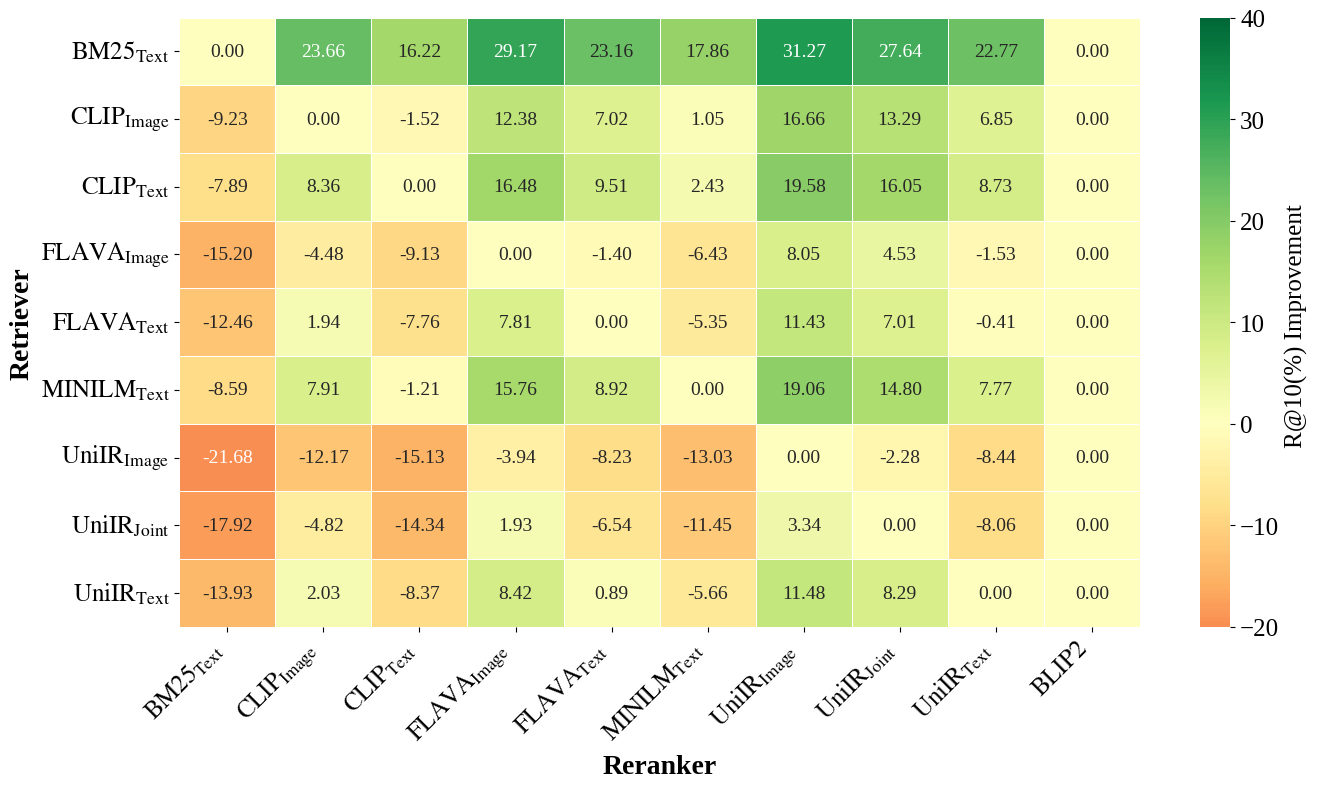


Creating Flickr heatmap...
✅ Saved: flickr_improvement_heatmap_R10.png


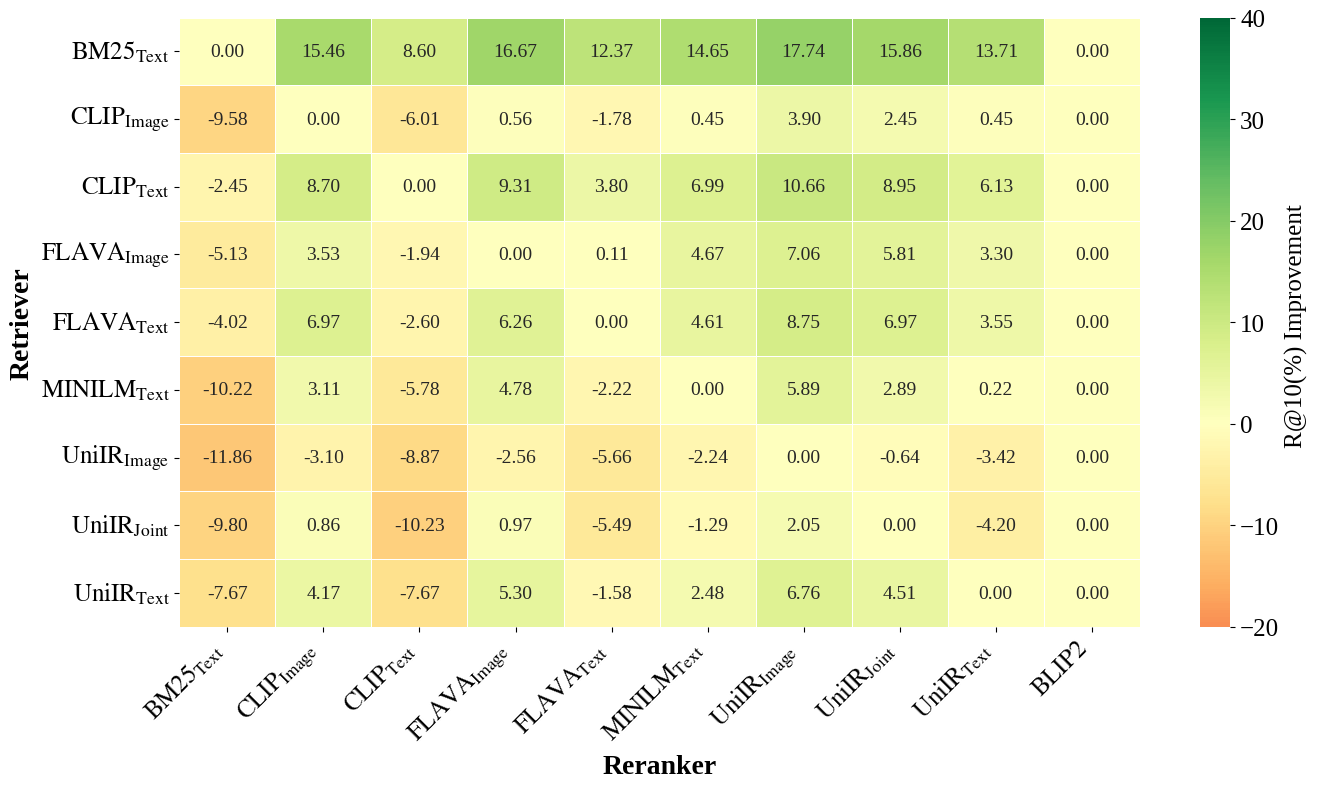


=== MSCOCO Dataset (R@10) ===
Max improvement: 31.27%
Min change: -21.68%
Average improvement: 2.37%

=== Flickr Dataset (R@10) ===
Max improvement: 17.74%
Min change: -11.86%
Average improvement: 1.61%
✅ Saved: coco_improvement_matrix_R10.csv
✅ Saved: flickr_improvement_matrix_R10.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ========= Select which metric to visualize =========
METRIC = "R@10"   # change to "R@1" or "R@5" if you ever want to switch

# ========= Single-stage results (R@10 baselines) =========
# MSCOCO baselines (single stage, R@10)
single_stage_coco = {
    'CLIP-Image': 0.7238,
    'FLAVA-Image': 0.7998,
    'UniIR-Image': 0.8578,
    'CLIP-Text': 0.6916,
    'MINILM-Text': 0.7082,
    'FLAVA-Text': 0.7734,
    'UniIR-Text': 0.7668,
    'UniIR-Joint': 0.8384,
    # BM25 baseline (Caption top-4 only)
    'BM25-Text': 0.5622
}

# Flickr baselines (single stage, R@10)
single_stage_flickr = {
    'CLIP-Image': 0.8980,
    'FLAVA-Image': 0.8780,
    'UniIR-Image': 0.9360,
    'CLIP-Text': 0.8160,
    'MINILM-Text': 0.9000,
    'FLAVA-Text': 0.8460,
    'UniIR-Text': 0.8870,
    'UniIR-Joint': 0.9290,
    # BM25 baseline (Caption top-4 only)
    'BM25-Text': 0.7440
}

# ========= Mapping from CSV tokens → display names =========
name_mapping = {
    'clip_image': 'CLIP-Image',
    'clip_text': 'CLIP-Text',
    'flava_image': 'FLAVA-Image',
    'flava_text': 'FLAVA-Text',
    'minilm_text': 'MINILM-Text',
    'uniir_image': 'UniIR-Image',
    'uniir_text': 'UniIR-Text',
    'uniir_joint-image-text': 'UniIR-Joint',
    # BM25 variants that might appear in CSV
    'bm25_text': 'BM25-Text',
    'bm25': 'BM25-Text',
    # BLIP2 column
    'blip2': 'BLIP2'
}

# Columns we always want to include (and push to the end)
ALWAYS_APPEND_STAGE2 = ['blip2']

# ========= Pretty formatter (upright subscripts) =========
def format_model_name(name: str) -> str:
    """
    Convert model display name to mathtext with upright base and upright subscript.
    Example: 'CLIP-Image' -> r'$\mathrm{CLIP}_\mathrm{Image}$'
    Names without '-' render as just upright, e.g. 'BLIP2' -> r'$\mathrm{BLIP2}$'
    """
    if '-' in name:
        base, sub = name.split('-', 1)
        return rf'$\mathrm{{{base}}}_\mathrm{{{sub}}}$'
    return rf'$\mathrm{{{name}}}$'

# ========= Read your two-stage CSV data =========
df_two_stage = pd.read_csv('master_results_faiss.csv')

# ========= Heatmap builder =========
def create_improvement_heatmap(
    df, dataset_name, single_stage_dict,
    metric=METRIC, figsize=(14, 8), save_path=None
):
    df_dataset = df[df['dataset'].str.lower() == dataset_name.lower()].copy()

    # Map stage1 names to display dictionary keys
    df_dataset['stage1_mapped'] = df_dataset['stage1'].map(name_mapping)

    # Build unique sets
    stage1_models = sorted([m for m in df_dataset['stage1_mapped'].dropna().unique()])

    # Stage2 raw keys from CSV
    stage2_models = list(sorted(df_dataset['stage2'].dropna().unique()))
    # Ensure ALWAYS_APPEND columns exist and appear at the end
    for must in ALWAYS_APPEND_STAGE2:
        if must not in stage2_models:
            stage2_models.append(must)
        else:
            stage2_models = [c for c in stage2_models if c != must] + [must]

    # Matrix
    improvement_matrix = pd.DataFrame(
        np.zeros((len(stage1_models), len(stage2_models))),
        index=stage1_models,
        columns=stage2_models
    )

    # Fill with % improvements
    for _, row in df_dataset.iterrows():
        stage1 = row['stage1_mapped']
        stage2 = row['stage2']
        if pd.isna(stage1) or pd.isna(stage2):
            continue

        if metric not in row:
            print(f"WARNING: '{metric}' column not found in CSV; row skipped.")
            continue

        r_two_stage = float(row[metric])

        # Baseline for this stage1 model from single-stage dict (R@10 by default)
        r_single = single_stage_dict.get(stage1, None)
        if r_single is None:
            print(f"WARNING: Could not find baseline for '{stage1}' in {dataset_name}.")
            continue

        # % improvement
        improvement_pct = ((r_two_stage - r_single) / r_single) * 100 if r_single > 0 else 0.0
        if stage2 in improvement_matrix.columns and stage1 in improvement_matrix.index:
            improvement_matrix.loc[stage1, stage2] = improvement_pct

    # ---- Set diagonal to ZERO (no absolute baselines on diagonal) ----
    col_display = {col: name_mapping.get(col, col) for col in improvement_matrix.columns}
    for row_name in improvement_matrix.index:
        matching_cols = [col for col, disp in col_display.items() if disp == row_name]
        if matching_cols:
            improvement_matrix.loc[row_name, matching_cols[0]] = 0.0

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    cb = sns.heatmap(
        improvement_matrix.astype(float),
        annot=True,
        fmt='.2f',
        cmap='RdYlGn',
        center=0,
        cbar_kws={'label': f'{metric}(%) Improvement '},
        linewidths=0.5,
        vmin=-20,
        vmax=40,
        ax=ax,
        annot_kws={"fontsize": 14, "fontweight": "normal"}
    )

    cbar = cb.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)
    cbar.ax.tick_params(labelsize=18)

    # Tick labels with formatted display names
    y_labels = [format_model_name(name) for name in improvement_matrix.index]
    ax.set_yticklabels(y_labels, rotation=0, fontsize=18)

    x_labels = [format_model_name(name_mapping.get(col, col)) for col in improvement_matrix.columns]
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=18)

    # Use MSCOCO in title when dataset_name == 'coco'
    title_ds = 'MSCOCO' if dataset_name.lower() == 'coco' else dataset_name.upper()
    # plt.title(
    #     f'Retrieve and Rerank pipelines -- {title_ds}',
    #     fontsize=20, fontweight='bold', pad=20
    # )
    ax.set_xlabel('Reranker', fontsize=20, fontweight='bold')
    ax.set_ylabel('Retriever', fontsize=20, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"✅ Saved: {save_path}")

    plt.show()
    return improvement_matrix

# ========= Run for both datasets =========
print("Creating MSCOCO heatmap...")
coco_improvements = create_improvement_heatmap(
    df_two_stage, 'coco', single_stage_coco, metric=METRIC,
    figsize=(14, 8), save_path='coco_improvement_heatmap_R10.png'
)

print("\nCreating Flickr heatmap...")
flickr_improvements = create_improvement_heatmap(
    df_two_stage, 'flickr', single_stage_flickr, metric=METRIC,
    figsize=(14, 8), save_path='flickr_improvement_heatmap_R10.png'
)

# ========= Summary stats =========
def print_stats(name, mat):
    print("\n" + "="*50)
    print(f"=== {name} Dataset ({METRIC}) ===")
    print("="*50)
    print(f"Max improvement: {mat.max().max():.2f}%")
    print(f"Min change: {mat.min().min():.2f}%")
    print(f"Average improvement: {mat.values.mean():.2f}%")

print_stats("MSCOCO", coco_improvements)  # label as MSCOCO
print_stats("Flickr", flickr_improvements)

# ========= (Optional) Save matrices =========
coco_improvements.to_csv('coco_improvement_matrix_R10.csv')
print("✅ Saved: coco_improvement_matrix_R10.csv")
flickr_improvements.to_csv('flickr_improvement_matrix_R10.csv')
print("✅ Saved: flickr_improvement_matrix_R10.csv")


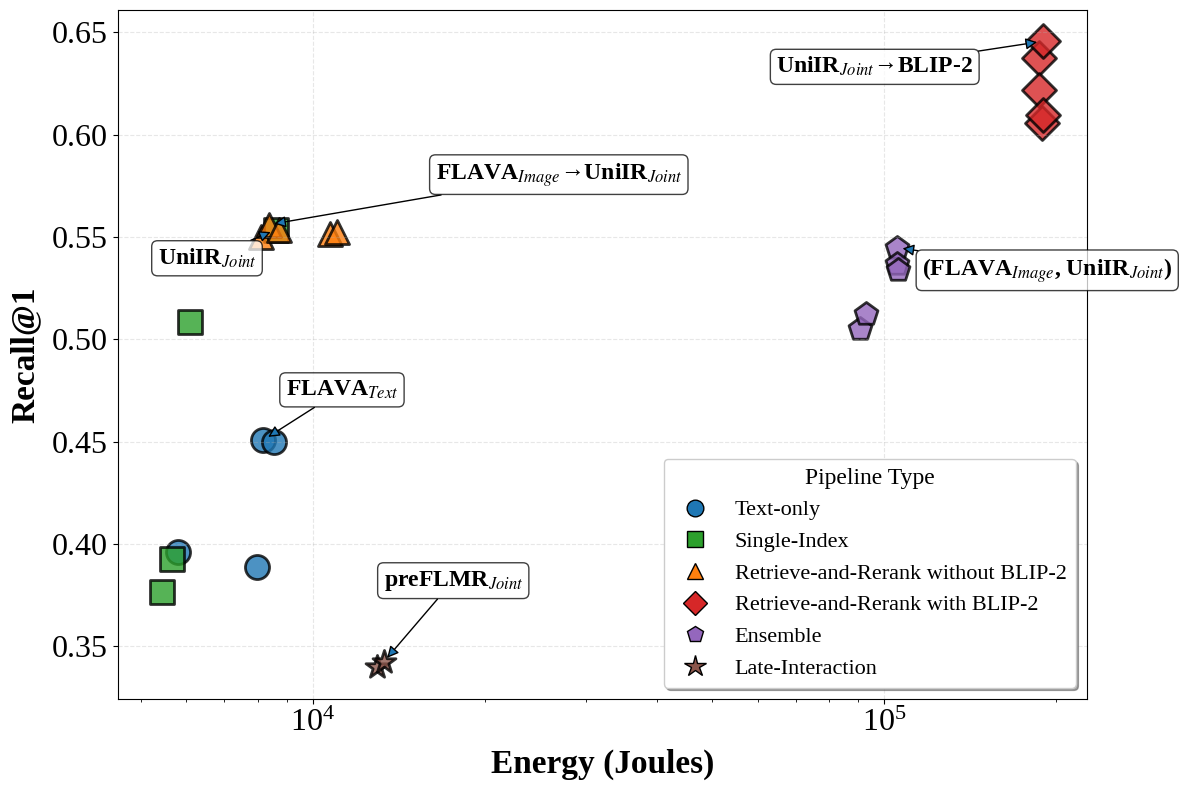

✓ COCO scatter plot saved as 'recall_vs_energy_coco_r1.png'
  Total COCO data points: 25


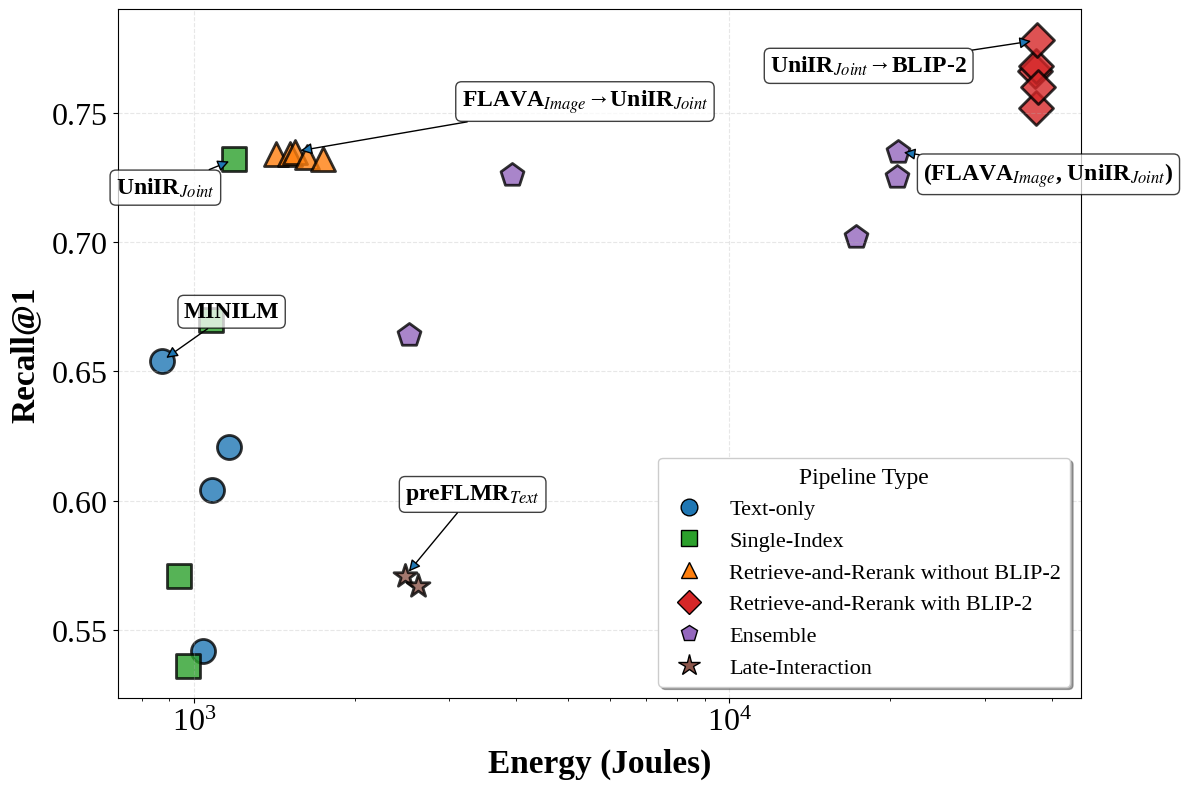

✓ Flickr scatter plot saved as 'recall_vs_energy_flickr_r1.png'
  Total Flickr data points: 25

SUMMARY STATISTICS - RECALL@1 VS ENERGY

📊 COCO Dataset:
  Text-only                               : 4 points | R@1 0.3886-0.4508, Energy 5811.43-8558.79 J
  Single-Index                            : 4 points | R@1 0.3766-0.5534, Energy 5440.23-8611.00 J
  Retrieve-and-Rerank without BLIP-2      : 5 points | R@1 0.5500-0.5560, Energy 8126.19-11040.45 J
  Retrieve-and-Rerank with BLIP-2         : 5 points | R@1 0.6056-0.6456, Energy 186549.05-189307.59 J
  Ensemble                                : 5 points | R@1 0.5050-0.5448, Energy 90641.21-105677.29 J
  Late-Interaction                        : 2 points | R@1 0.3396-0.3422, Energy 12944.12-13292.00 J

📊 Flickr Dataset:
  Text-only                               : 4 points | R@1 0.5420-0.6540, Energy 870.46-1164.63 J
  Single-Index                            : 4 points | R@1 0.5360-0.7320, Energy 937.41-1189.42 J
  Retrieve-and-Rerank withou

In [4]:
# recall_vs_lat_updated
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import math, re  # <-- added re

# =========================
# Font sizing controls (only axes/ticks)
# =========================
AXIS_LABEL_FONTSIZE = 24   # axis label size
TICK_LABEL_FONTSIZE = 23   # tick label size
TITLE_FONTSIZE = 25        # figure titles
LEGEND_FONTSIZE = 16       # keep legend same
LEGEND_TITLE_FONTSIZE = 17 # keep legend title same
ANNOT_FONTSIZE = 17        # label text size

# Carefully matched data from the tables
# Format: (name, dataset, recall_r1, energy, pipeline_type, marker_type)
data = [
    # ============ COCO - Text-only ============
    ("MINILM", "COCO", 0.3962, 5811.429, "Text-only", "circle"),
    ("CLIP_Text", "COCO", 0.3886, 7966.375, "Text-only", "circle"),
    ("FLAVA_Text", "COCO", 0.4508, 8192.518, "Text-only", "circle"),
    ("UniIR_Text", "COCO", 0.4500, 8558.791, "Text-only", "circle"),

    # ============ COCO - Single-Index ============
    ("CLIP_Image", "COCO", 0.3766, 5440.233, "Single-Index", "square"),
    ("FLAVA_Image", "COCO", 0.3926, 5671.572, "Single-Index", "square"),
    ("UniIR_Image", "COCO", 0.5082, 6096.318, "Single-Index", "square"),
    ("UniIR_Joint", "COCO", 0.5534, 8610.995, "Single-Index", "square"),

    # ============ COCO - Retrieve-and-Rerank WITHOUT BLIP-2 (5 points) ============
    ("CLIP_Image→UniIR_Joint", "COCO", 0.5500, 8126.193, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "COCO", 0.5560, 8371.911, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint", "COCO", 0.5532, 8731.663, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Text→UniIR_Joint", "COCO", 0.5516, 10726.097, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "COCO", 0.5522, 11040.448, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # ============ COCO - Retrieve-and-Rerank WITH BLIP-2 (10 points) ============
    ("UniIR_Image→BLIP-2", "COCO", 0.6374, 186549.050, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→BLIP-2", "COCO", 0.6218, 186615.231, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "COCO", 0.6056, 189141.903, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→BLIP-2", "COCO", 0.6098, 189222.290, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "COCO", 0.6456, 189307.593, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→UniIR_Joint→BLIP-2", "COCO", 0.6446, 236120.681, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→UniIR_Joint→BLIP-2", "COCO", 0.6458, 245911.588, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→UniIR_Joint→BLIP-2", "COCO", 0.6434, 262924.2185, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→UniIR_Joint→BLIP-2", "COCO", 0.6458, 288618.468, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→UniIR_Joint→BLIP-2", "COCO", 0.6440, 315481.771, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # ============ COCO - Ensemble ============
    ("(UniIR_Text, UniIR_Joint)", "COCO", 0.5050, 90641.2095, "Ensemble", "pentagon"),
    ("(FLAVA_Text, UniIR_Joint)", "COCO", 0.5124, 92778.6565, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "COCO", 0.5448, 105274.773, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)", "COCO", 0.5370, 105455.913, "Ensemble", "pentagon"),
    ("(UniIR_Image, UniIR_Joint)", "COCO", 0.5336, 105677.2855, "Ensemble", "pentagon"),

    # ============ COCO - Late Interaction ============
    ("preFLMR_Text", "COCO", 0.3396, 12944.118, "Late-Interaction", "star"),
    ("preFLMR_Joint", "COCO", 0.3422, 13292.001, "Late-Interaction", "star"),

    # ============ Flickr - Text-only ============
    ("MINILM", "Flickr", 0.6540, 870.461, "Text-only", "circle"),
    ("CLIP_Text", "Flickr", 0.5420, 1039.328, "Text-only", "circle"),
    ("FLAVA_Text", "Flickr", 0.6040, 1080.792, "Text-only", "circle"),
    ("UniIR_Text", "Flickr", 0.6210, 1164.629, "Text-only", "circle"),

    # ============ Flickr - Single-Index ============
    ("CLIP_Image", "Flickr", 0.5710, 937.406, "Single-Index", "square"),
    ("FLAVA_Image", "Flickr", 0.5360, 975.371, "Single-Index", "square"),
    ("UniIR_Image", "Flickr", 0.6700, 1074.525, "Single-Index", "square"),
    ("UniIR_Joint", "Flickr", 0.7320, 1189.419, "Single-Index", "square"),

    # ============ Flickr - Retrieve-and-Rerank WITHOUT BLIP-2 (5 points) ============
    ("MINILM→UniIR_Joint", "Flickr", 0.7340, 1422.089, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint", "Flickr", 0.7340, 1509.416, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "Flickr", 0.7350, 1544.724, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint", "Flickr", 0.7330, 1624.571, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "Flickr", 0.7320, 1745.200, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # ============ Flickr - Retrieve-and-Rerank WITH BLIP-2 ============
    ("MINILM→BLIP-2", "Flickr", 0.7660, 37289.005, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→BLIP-2", "Flickr", 0.7680, 37359.645, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→BLIP-2", "Flickr", 0.7520, 37413.210, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "Flickr", 0.7780, 37509.338, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "Flickr", 0.7600, 37662.098, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # ============ Flickr - Retrieve-and-Rerank → UniIR → BLIP-2 ============
    ("MINILM→UniIR_Image→BLIP-2", "Flickr", 0.7790, 37676.546, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→UniIR_Joint→BLIP-2", "Flickr", 0.7840, 48526.450, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→UniIR_Joint→BLIP-2", "Flickr", 0.7800, 50759.5645, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→FLAVA_Image→BLIP-2", "Flickr", 0.7780, 38148.502, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("MINILM→UniIR_Joint→BLIP-2", "Flickr", 0.7840, 65925.648, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # ============ Flickr - Ensemble ============
    ("(UniIR_Text, UniIR_Joint)", "Flickr", 0.6640, 2525.118, "Ensemble", "pentagon"),
    ("(UniIR_Image, UniIR_Joint)", "Flickr", 0.7260, 3923.4045, "Ensemble", "pentagon"),
    ("(MINILM, UniIR_Joint)", "Flickr", 0.7020, 17254.4945, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)", "Flickr", 0.7250, 20613.2485, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "Flickr", 0.7350, 20692.8565, "Ensemble", "pentagon"),

    # ============ Flickr - Late Interaction ============
    ("preFLMR_Text", "Flickr", 0.5710, 2482.026, "Late-Interaction", "star"),
    ("preFLMR_Joint", "Flickr", 0.5670, 2619.403, "Late-Interaction", "star"),
]

# ------------------ CHANGE 1: drop 3-stage pipelines (X→Y→BLIP-2) ------------------
def _is_three_stage_pipeline(name: str) -> bool:
    return (name.count("→") >= 2) and name.endswith("BLIP-2")

# (Old logic that *kept* 3-stage entries) — commented out per request:
# data = [row for row in data if _is_three_stage_pipeline(row[0])]

# New logic: exclude 3-stage pipelines from plots
data = [row for row in data if not _is_three_stage_pipeline(row[0])]
# ------------------------------------------------------------------------------------

# Define colors for pipeline types
pipeline_colors = {
    "Text-only": "#1f77b4",  # Blue
    "Single-Index": "#2ca02c",  # Green
    "Retrieve-and-Rerank without BLIP-2": "#ff7f0e",  # Orange
    "Retrieve-and-Rerank with BLIP-2": "#d62728",  # Red
    "Ensemble": "#9467bd",  # Purple
    "Late-Interaction": "#8c564b",  # Brown
}

marker_styles = {
    "circle": "o",
    "square": "s",
    "triangle": "^",
    "diamond": "D",
    "pentagon": "p",
    "star": "*",
}

# ---- Label layout controls (same strategy as before) ----
OFFSETS = {
    "Text-only": (16, 28),
    "Single-Index": (-14, -12),
    "Retrieve-and-Rerank without BLIP-2": (120, 26),
    "Retrieve-and-Rerank with BLIP-2": (-50, -10),
    "Ensemble": (18, -6),
    "Late-Interaction": (0, 50),
}
LABEL_BBOX = dict(boxstyle="round,pad=0.25", fc="white", ec="black", alpha=0.75)
ARROW = dict(arrowstyle="-|>", shrinkA=0, shrinkB=4, lw=1)

def _bboxes_overlap(b1, b2):
    """Return True if two matplotlib Bbox objects overlap."""
    return not (b1.x1 <= b2.x0 or b1.x0 >= b2.x1 or b1.y1 <= b2.y0 or b1.y0 >= b2.y1)

def _candidate_offsets(dx, dy):
    """Progressively try farther/orthogonal offsets to avoid collisions."""
    return [
        ( dx,  dy), ( dx, -dy), (-dx,  dy), (-dx, -dy),
        (1.5*dx, 0), (0, 1.5*dy), (-1.5*dx, 0), (0, -1.5*dy),
        (2*dx,  2*dy), (-2*dx, 2*dy), (2*dx, -2*dy), (-2*dx, -2*dy),
        (2.5*dx, 0), (0, 2.5*dy), (-2.5*dx, 0), (0, -2.5*dy),
    ]

# ------------------ CHANGE 2: label the top R@1 within each pipeline type ------------------
def pick_best_by_recall(subset, pipeline_type):
    """
    Pick the point with the highest Recall@1 within this pipeline type.
    Returns (energy, recall, name) or None.
    """
    pts = [(e, r, n) for (n, _d, r, e, p, _m) in subset if p == pipeline_type]
    if not pts:
        return None
    return max(pts, key=lambda t: t[1])  # highest recall

# ---------- format underscores as subscripts in labels ----------
def _format_modality_subscripts(s: str) -> str:
    return re.sub(r'([A-Za-z0-9\)])_([A-Za-z0-9\-]+)', r'\1$_{\2}$', s)

def annotate_one_label_per_type(ax, subset):
    """Annotate a single, collision-free label for each pipeline type in subset."""
    types_here = sorted({ptype for (_n,_d,_r,_e,ptype,_m) in subset})
    placed = []
    for ptype in types_here:
        rep = pick_best_by_recall(subset, ptype)  # <-- use top R@1 point
        if rep is None:
            continue
        energy, recall, name = rep
        label_text = _format_modality_subscripts(name)
        base_dx, base_dy = OFFSETS.get(ptype, (12, 12))

        ann = None
        for dx, dy in _candidate_offsets(base_dx, base_dy):
            ann = ax.annotate(
                label_text, xy=(energy, recall), xytext=(dx, dy),
                textcoords="offset points", fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx >= 0 else "right",
                va="bottom" if dy >= 0 else "top",
                bbox=LABEL_BBOX, arrowprops=ARROW, clip_on=False, zorder=5
            )
            ax.figure.canvas.draw()
            bbox = ann.get_window_extent(renderer=ax.figure.canvas.get_renderer()).expanded(1.02, 1.08)
            if any(_bboxes_overlap(bbox, b) for b in placed):
                ann.remove()
                ann = None
                continue
            placed.append(bbox)
            break

        if ann is None:
            ax.annotate(
                label_text, xy=(energy, recall), xytext=(base_dx, base_dy),
                textcoords="offset points", fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if base_dx >= 0 else "right",
                va="bottom" if base_dy >= 0 else "top",
                bbox=LABEL_BBOX, arrowprops=ARROW, clip_on=False, zorder=5
            )
# -------------------------------------------------------------------------------------------

# Separate data by dataset
coco_data = [d for d in data if d[1] == "COCO"]
flickr_data = [d for d in data if d[1] == "Flickr"]

# ================= COCO plot =================
fig_coco, ax_coco = plt.subplots(figsize=(12, 8))
for name, dataset, recall, energy, pipeline_type, marker_type in coco_data:
    color = pipeline_colors[pipeline_type]
    marker = marker_styles[marker_type]
    ax_coco.scatter(energy, recall, s=300, alpha=0.8, color=color, marker=marker,
                    edgecolors='black', linewidth=2)

ax_coco.set_xlabel("Energy (Joules)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_coco.set_ylabel("Recall@1", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_coco.set_title("", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
ax_coco.grid(True, alpha=0.3, linestyle='--')
ax_coco.set_xscale('log')
ax_coco.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)

# Annotate one label per pipeline type (with collision avoidance)
annotate_one_label_per_type(ax_coco, coco_data)

# Legend for COCO (unchanged sizes)
legend_elements_coco = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=pipeline_colors["Text-only"],
           markersize=12, label='Text-only', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=pipeline_colors["Single-Index"],
           markersize=12, label='Single-Index', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank without BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank without BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank with BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank with BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='p', color='w', markerfacecolor=pipeline_colors["Ensemble"],
           markersize=12, label='Ensemble', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=pipeline_colors["Late-Interaction"],
           markersize=16, label='Late-Interaction', markeredgecolor='black', linewidth=2),
]
ax_coco.legend(handles=legend_elements_coco, loc='best', fontsize=LEGEND_FONTSIZE, frameon=True,
               shadow=True, title='Pipeline Type', title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('recall_vs_energy_coco_r1.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ COCO scatter plot saved as 'recall_vs_energy_coco_r1.png'")
print(f"  Total COCO data points: {len(coco_data)}")

# ================= Flickr plot =================
fig_flickr, ax_flickr = plt.subplots(figsize=(12, 8))
for name, dataset, recall, energy, pipeline_type, marker_type in flickr_data:
    color = pipeline_colors[pipeline_type]
    marker = marker_styles[marker_type]
    ax_flickr.scatter(energy, recall, s=300, alpha=0.8, color=color, marker=marker,
                      edgecolors='black', linewidth=2)

ax_flickr.set_xlabel("Energy (Joules)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_flickr.set_ylabel("Recall@1", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_flickr.set_title("", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
ax_flickr.grid(True, alpha=0.3, linestyle='--')
ax_flickr.set_xscale('log')
ax_flickr.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)

# Annotate one label per pipeline type (with collision avoidance)
annotate_one_label_per_type(ax_flickr, flickr_data)

# Legend for Flickr (unchanged sizes)
legend_elements_flickr = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=pipeline_colors["Text-only"],
           markersize=12, label='Text-only', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=pipeline_colors["Single-Index"],
           markersize=12, label='Single-Index', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank without BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank without BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank with BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank with BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='p', color='w', markerfacecolor=pipeline_colors["Ensemble"],
           markersize=12, label='Ensemble', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=pipeline_colors["Late-Interaction"],
           markersize=16, label='Late-Interaction', markeredgecolor='black', linewidth=2),
]
ax_flickr.legend(handles=legend_elements_flickr, loc='lower right', fontsize=LEGEND_FONTSIZE,
                 frameon=True, shadow=True, title='Pipeline Type', title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('recall_vs_energy_flickr_r1.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Flickr scatter plot saved as 'recall_vs_energy_flickr_r1.png'")
print(f"  Total Flickr data points: {len(flickr_data)}")

# ================= Summary statistics (R@1) =================
print("\n" + "="*70)
print("SUMMARY STATISTICS - RECALL@1 VS ENERGY")
print("="*70)

print("\n📊 COCO Dataset:")
for pipeline_type in pipeline_colors.keys():
    coco_subset = [d for d in coco_data if d[4] == pipeline_type]
    if coco_subset:
        recalls = [d[2] for d in coco_subset]
        energies = [d[3] for d in coco_subset]
        print(f"  {pipeline_type:40s}: {len(coco_subset)} points | R@1 {min(recalls):.4f}-{max(recalls):.4f}, Energy {min(energies):.2f}-{max(energies):.2f} J")

print("\n📊 Flickr Dataset:")
for pipeline_type in pipeline_colors.keys():
    flickr_subset = [d for d in flickr_data if d[4] == pipeline_type]
    if flickr_subset:
        recalls = [d[2] for d in flickr_subset]
        energies = [d[3] for d in flickr_subset]
        print(f"  {pipeline_type:40s}: {len(flickr_subset)} points | R@1 {min(recalls):.4f}-{max(recalls):.4f}, Energy {min(energies):.2f}-{max(energies):.2f} J")

print("\n" + "="*70)


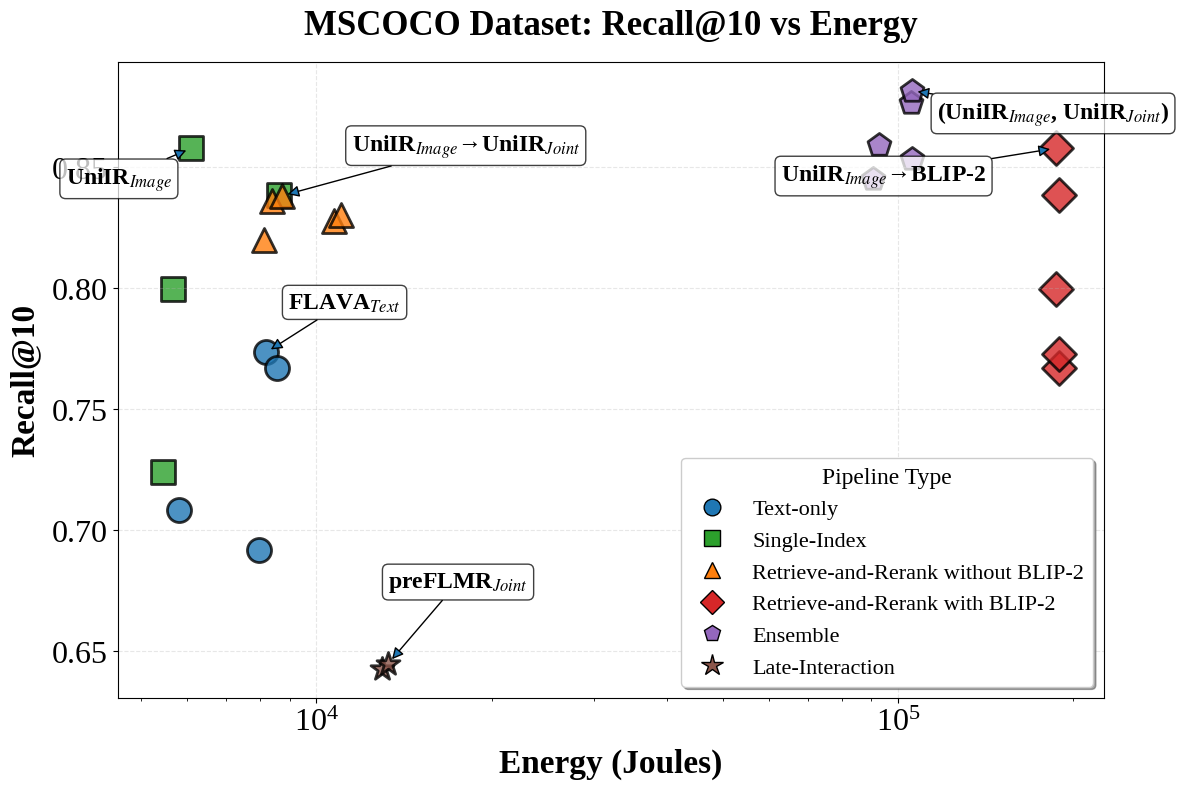

✓ COCO scatter plot saved as 'recall_vs_energy_coco_r10.png'
  Total COCO data points: 25


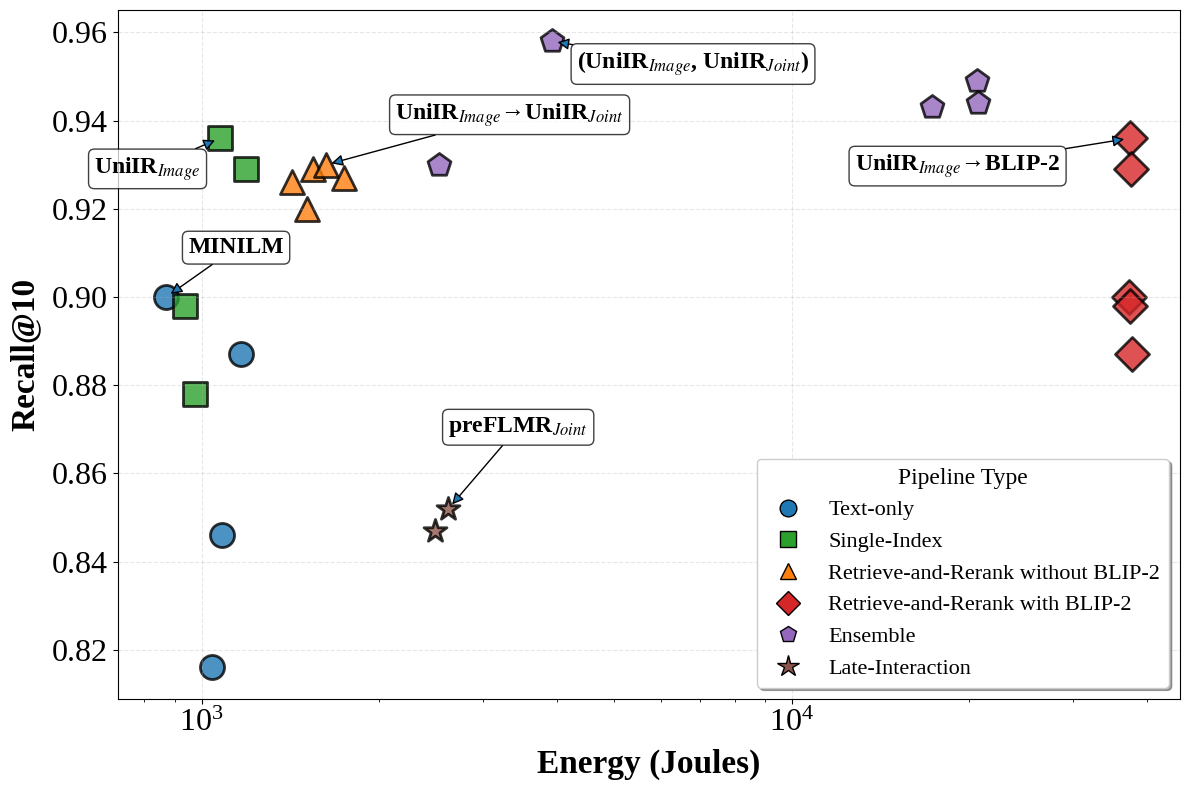

✓ Flickr scatter plot saved as 'recall_vs_energy_flickr_r10.png'
  Total Flickr data points: 25

SUMMARY STATISTICS - RECALL@10 VS ENERGY

📊 COCO Dataset:
  Text-only                               : 4 points | R@10 0.6916-0.7734, Energy 5811.43-8558.79 J
  Single-Index                            : 4 points | R@10 0.7238-0.8578, Energy 5440.23-8611.00 J
  Retrieve-and-Rerank without BLIP-2      : 5 points | R@10 0.8200-0.8382, Energy 8126.19-11040.45 J
  Retrieve-and-Rerank with BLIP-2         : 5 points | R@10 0.7668-0.8578, Energy 186549.05-189307.59 J
  Ensemble                                : 5 points | R@10 0.8450-0.8816, Energy 90641.21-105677.29 J
  Late-Interaction                        : 2 points | R@10 0.6426-0.6448, Energy 12944.12-13292.00 J

📊 Flickr Dataset:
  Text-only                               : 4 points | R@10 0.8160-0.9000, Energy 870.46-1164.63 J
  Single-Index                            : 4 points | R@10 0.8780-0.9360, Energy 937.41-1189.42 J
  Retrieve-and-Rer

In [5]:
#recall @10 vs energy
# recall_vs_energy_r10.py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import math, re  # <-- added re

# =========================
# Font sizing controls (only axes/ticks)
# =========================
AXIS_LABEL_FONTSIZE = 24   # axis label size
TICK_LABEL_FONTSIZE = 23   # tick label size
TITLE_FONTSIZE = 25        # figure titles
LEGEND_FONTSIZE = 16       # keep legend same
LEGEND_TITLE_FONTSIZE = 17 # keep legend title same
ANNOT_FONTSIZE = 17        # label text size

# Carefully matched data from the tables
# Format: (name, dataset, recall_r10, energy, pipeline_type, marker_type)
data = [
    ('MINILM', 'COCO', 0.7082, 5811.429, 'Text-only', 'circle'),
    ('CLIP_Text', 'COCO', 0.6916, 7966.375, 'Text-only', 'circle'),
    ('FLAVA_Text', 'COCO', 0.7734, 8192.518, 'Text-only', 'circle'),
    ('UniIR_Text', 'COCO', 0.7668, 8558.791, 'Text-only', 'circle'),
    ('CLIP_Image', 'COCO', 0.7238, 5440.233, 'Single-Index', 'square'),
    ('FLAVA_Image', 'COCO', 0.7998, 5671.572, 'Single-Index', 'square'),
    ('UniIR_Image', 'COCO', 0.8578, 6096.318, 'Single-Index', 'square'),
    ('UniIR_Joint', 'COCO', 0.8384, 8610.995, 'Single-Index', 'square'),
    ('CLIP_Image→UniIR_Joint', 'COCO', 0.82, 8126.193, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('FLAVA_Image→UniIR_Joint', 'COCO', 0.836, 8371.911, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('UniIR_Image→UniIR_Joint', 'COCO', 0.8382, 8731.663, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('FLAVA_Text→UniIR_Joint', 'COCO', 0.8276, 10726.097, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('UniIR_Text→UniIR_Joint', 'COCO', 0.8304, 11040.448, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('UniIR_Image→BLIP-2', 'COCO', 0.8578, 186549.05, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('FLAVA_Image→BLIP-2', 'COCO', 0.7998, 186615.231, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('UniIR_Text→BLIP-2', 'COCO', 0.7668, 189141.903, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('FLAVA_Text→BLIP-2', 'COCO', 0.7728, 189222.29, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('UniIR_Joint→BLIP-2', 'COCO', 0.8384, 189307.593, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('(UniIR_Text, UniIR_Joint)', 'COCO', 0.845, 90641.2095, 'Ensemble', 'pentagon'),
    ('(FLAVA_Text, UniIR_Joint)', 'COCO', 0.859, 92778.6565, 'Ensemble', 'pentagon'),
    ('(FLAVA_Image, UniIR_Joint)', 'COCO', 0.8764, 105274.773, 'Ensemble', 'pentagon'),
    ('(CLIP_Image, UniIR_Joint)', 'COCO', 0.8532, 105455.913, 'Ensemble', 'pentagon'),
    ('(UniIR_Image, UniIR_Joint)', 'COCO', 0.8816, 105677.2855, 'Ensemble', 'pentagon'),
    ('preFLMR_Text', 'COCO', 0.6426, 12944.118, 'Late-Interaction', 'star'),
    ('preFLMR_Joint', 'COCO', 0.6448, 13292.001, 'Late-Interaction', 'star'),
    ('MINILM', 'Flickr', 0.9, 870.461, 'Text-only', 'circle'),
    ('CLIP_Text', 'Flickr', 0.816, 1039.328, 'Text-only', 'circle'),
    ('FLAVA_Text', 'Flickr', 0.846, 1080.792, 'Text-only', 'circle'),
    ('UniIR_Text', 'Flickr', 0.887, 1164.629, 'Text-only', 'circle'),
    ('CLIP_Image', 'Flickr', 0.898, 937.406, 'Single-Index', 'square'),
    ('FLAVA_Image', 'Flickr', 0.878, 975.371, 'Single-Index', 'square'),
    ('UniIR_Image', 'Flickr', 0.936, 1074.525, 'Single-Index', 'square'),
    ('UniIR_Joint', 'Flickr', 0.929, 1189.419, 'Single-Index', 'square'),
    ('MINILM→UniIR_Joint', 'Flickr', 0.926, 1422.089, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('CLIP_Image→UniIR_Joint', 'Flickr', 0.92, 1509.416, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('FLAVA_Image→UniIR_Joint', 'Flickr', 0.929, 1544.724, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('UniIR_Image→UniIR_Joint', 'Flickr', 0.93, 1624.571, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('UniIR_Text→UniIR_Joint', 'Flickr', 0.927, 1745.2, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('MINILM→BLIP-2', 'Flickr', 0.9, 37289.005, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('UniIR_Image→BLIP-2', 'Flickr', 0.936, 37359.645, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('CLIP_Image→BLIP-2', 'Flickr', 0.898, 37413.21, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('UniIR_Joint→BLIP-2', 'Flickr', 0.929, 37509.338, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('UniIR_Text→BLIP-2', 'Flickr', 0.887, 37662.098, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('(UniIR_Text, UniIR_Joint)', 'Flickr', 0.93, 2525.118, 'Ensemble', 'pentagon'),
    ('(UniIR_Image, UniIR_Joint)', 'Flickr', 0.958, 3923.4045, 'Ensemble', 'pentagon'),
    ('(MINILM, UniIR_Joint)', 'Flickr', 0.943, 17254.4945, 'Ensemble', 'pentagon'),
    ('(CLIP_Image, UniIR_Joint)', 'Flickr', 0.949, 20613.2485, 'Ensemble', 'pentagon'),
    ('(FLAVA_Image, UniIR_Joint)', 'Flickr', 0.944, 20692.8565, 'Ensemble', 'pentagon'),
    ('preFLMR_Text', 'Flickr', 0.847, 2482.026, 'Late-Interaction', 'star'),
    ('preFLMR_Joint', 'Flickr', 0.852, 2619.403, 'Late-Interaction', 'star'),
]

# ------------------ Keep 3-stage pipelines excluded (X→Y→BLIP-2) ------------------
def _is_three_stage_pipeline(name: str) -> bool:
    return (name.count("→") >= 2) and name.endswith("BLIP-2")

data = [row for row in data if not _is_three_stage_pipeline(row[0])]
# -----------------------------------------------------------------------------------

# Define colors for pipeline types
pipeline_colors = {
    "Text-only": "#1f77b4",  # Blue
    "Single-Index": "#2ca02c",  # Green
    "Retrieve-and-Rerank without BLIP-2": "#ff7f0e",  # Orange
    "Retrieve-and-Rerank with BLIP-2": "#d62728",  # Red
    "Ensemble": "#9467bd",  # Purple
    "Late-Interaction": "#8c564b",  # Brown
}

marker_styles = {
    "circle": "o",
    "square": "s",
    "triangle": "^",
    "diamond": "D",
    "pentagon": "p",
    "star": "*",
}

# ---- Label layout controls ----
OFFSETS = {
    "Text-only": (16, 28),
    "Single-Index": (-14, -12),
    "Retrieve-and-Rerank without BLIP-2": (50, 26),
    "Retrieve-and-Rerank with BLIP-2": (-50, -10),
    "Ensemble": (18, -6),
    "Late-Interaction": (0, 50),
}
LABEL_BBOX = dict(boxstyle="round,pad=0.25", fc="white", ec="black", alpha=0.75)
ARROW = dict(arrowstyle="-|>", shrinkA=0, shrinkB=4, lw=1)

def _bboxes_overlap(b1, b2):
    """Return True if two matplotlib Bbox objects overlap."""
    return not (b1.x1 <= b2.x0 or b1.x0 >= b2.x1 or b1.y1 <= b2.y0 or b1.y0 >= b2.y1)

def _candidate_offsets(dx, dy):
    """Progressively try farther/orthogonal offsets to avoid collisions."""
    return [
        ( dx,  dy), ( dx, -dy), (-dx,  dy), (-dx, -dy),
        (1.5*dx, 0), (0, 1.5*dy), (-1.5*dx, 0), (0, -1.5*dy),
        (2*dx,  2*dy), (-2*dx, 2*dy), (2*dx, -2*dy), (-2*dx, -2*dy),
        (2.5*dx, 0), (0, 2.5*dy), (-2.5*dx, 0), (0, -2.5*dy),
    ]

# ------------------ Pick best by Recall@10 ------------------
def pick_best_by_recall(subset, pipeline_type):
    """
    Pick the point with the highest Recall@10 within this pipeline type.
    Returns (energy, recall, name) or None.
    """
    pts = [(e, r, n) for (n, _d, r, e, p, _m) in subset if p == pipeline_type]
    if not pts:
        return None
    return max(pts, key=lambda t: t[1])  # highest recall

# ---------- format underscores as subscripts in labels ----------
def _format_modality_subscripts(s: str) -> str:
    return re.sub(r'([A-Za-z0-9\)])_([A-Za-z0-9\-]+)', r'\1$_{\2}$', s)

def annotate_one_label_per_type(ax, subset):
    """Annotate a single, collision-free label for each pipeline type in subset."""
    types_here = sorted({ptype for (_n,_d,_r,_e,ptype,_m) in subset})
    placed = []
    for ptype in types_here:
        rep = pick_best_by_recall(subset, ptype)  # <-- use top R@10 point
        if rep is None:
            continue
        energy, recall, name = rep
        label_text = _format_modality_subscripts(name)
        base_dx, base_dy = OFFSETS.get(ptype, (12, 12))

        ann = None
        for dx, dy in _candidate_offsets(base_dx, base_dy):
            ann = ax.annotate(
                label_text, xy=(energy, recall), xytext=(dx, dy),
                textcoords="offset points", fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx >= 0 else "right",
                va="bottom" if dy >= 0 else "top",
                bbox=LABEL_BBOX, arrowprops=ARROW, clip_on=False, zorder=5
            )
            ax.figure.canvas.draw()
            bbox = ann.get_window_extent(renderer=ax.figure.canvas.get_renderer()).expanded(1.02, 1.08)
            if any(_bboxes_overlap(bbox, b) for b in placed):
                ann.remove()
                ann = None
                continue
            placed.append(bbox)
            break

        if ann is None:
            ax.annotate(
                label_text, xy=(energy, recall), xytext=(base_dx, base_dy),
                textcoords="offset points", fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if base_dx >= 0 else "right",
                va="bottom" if base_dy >= 0 else "top",
                bbox=LABEL_BBOX, arrowprops=ARROW, clip_on=False, zorder=5
            )

# Separate data by dataset
coco_data = [d for d in data if d[1] == "COCO"]
flickr_data = [d for d in data if d[1] == "Flickr"]

# ================= COCO plot =================
fig_coco, ax_coco = plt.subplots(figsize=(12, 8))
for name, dataset, recall, energy, pipeline_type, marker_type in coco_data:
    color = pipeline_colors[pipeline_type]
    marker = marker_styles[marker_type]
    ax_coco.scatter(energy, recall, s=300, alpha=0.8, color=color, marker=marker,
                    edgecolors='black', linewidth=2)

ax_coco.set_xlabel("Energy (Joules)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_coco.set_ylabel("Recall@10", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_coco.set_title("MSCOCO Dataset: Recall@10 vs Energy", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
ax_coco.grid(True, alpha=0.3, linestyle='--')
ax_coco.set_xscale('log')
ax_coco.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)

# Annotate one label per pipeline type (with collision avoidance)
annotate_one_label_per_type(ax_coco, coco_data)

# Legend for COCO (unchanged sizes)
legend_elements_coco = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=pipeline_colors["Text-only"],
           markersize=12, label='Text-only', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=pipeline_colors["Single-Index"],
           markersize=12, label='Single-Index', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank without BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank without BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank with BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank with BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='p', color='w', markerfacecolor=pipeline_colors["Ensemble"],
           markersize=12, label='Ensemble', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=pipeline_colors["Late-Interaction"],
           markersize=16, label='Late-Interaction', markeredgecolor='black', linewidth=2),
]
ax_coco.legend(handles=legend_elements_coco, loc='best', fontsize=LEGEND_FONTSIZE, frameon=True,
               shadow=True, title='Pipeline Type', title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('recall_vs_energy_coco_r10.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ COCO scatter plot saved as 'recall_vs_energy_coco_r10.png'")
print(f"  Total COCO data points: {len(coco_data)}")

# ================= Flickr plot =================
fig_flickr, ax_flickr = plt.subplots(figsize=(12, 8))
for name, dataset, recall, energy, pipeline_type, marker_type in flickr_data:
    color = pipeline_colors[pipeline_type]
    marker = marker_styles[marker_type]
    ax_flickr.scatter(energy, recall, s=300, alpha=0.8, color=color, marker=marker,
                      edgecolors='black', linewidth=2)

ax_flickr.set_xlabel("Energy (Joules)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_flickr.set_ylabel("Recall@10", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
# ax_flickr.set_title("Flickr Dataset: Recall@10 vs Energy", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
ax_flickr.grid(True, alpha=0.3, linestyle='--')
ax_flickr.set_xscale('log')
ax_flickr.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)

# Annotate one label per pipeline type (with collision avoidance)
annotate_one_label_per_type(ax_flickr, flickr_data)

# Legend for Flickr (unchanged sizes)
legend_elements_flickr = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=pipeline_colors["Text-only"],
           markersize=12, label='Text-only', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=pipeline_colors["Single-Index"],
           markersize=12, label='Single-Index', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank without BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank without BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank with BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank with BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='p', color='w', markerfacecolor=pipeline_colors["Ensemble"],
           markersize=12, label='Ensemble', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=pipeline_colors["Late-Interaction"],
           markersize=16, label='Late-Interaction', markeredgecolor='black', linewidth=2),
]
ax_flickr.legend(handles=legend_elements_flickr, loc='lower right', fontsize=LEGEND_FONTSIZE,
                 frameon=True, shadow=True, title='Pipeline Type', title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('recall_vs_energy_flickr_r10.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Flickr scatter plot saved as 'recall_vs_energy_flickr_r10.png'")
print(f"  Total Flickr data points: {len(flickr_data)}")

# ================= Summary statistics (R@10) =================
print("\n" + "="*70)
print("SUMMARY STATISTICS - RECALL@10 VS ENERGY")
print("="*70)

print("\n📊 COCO Dataset:")
for pipeline_type in pipeline_colors.keys():
    coco_subset = [d for d in coco_data if d[4] == pipeline_type]
    if coco_subset:
        recalls = [d[2] for d in coco_subset]
        energies = [d[3] for d in coco_subset]
        print(f"  {pipeline_type:40s}: {len(coco_subset)} points | R@10 {min(recalls):.4f}-{max(recalls):.4f}, Energy {min(energies):.2f}-{max(energies):.2f} J")

print("\n📊 Flickr Dataset:")
for pipeline_type in pipeline_colors.keys():
    flickr_subset = [d for d in flickr_data if d[4] == pipeline_type]
    if flickr_subset:
        recalls = [d[2] for d in flickr_subset]
        energies = [d[3] for d in flickr_subset]
        print(f"  {pipeline_type:40s}: {len(flickr_subset)} points | R@10 {min(recalls):.4f}-{max(recalls):.4f}, Energy {min(energies):.2f}-{max(energies):.2f} J")

print("\n" + "="*70)



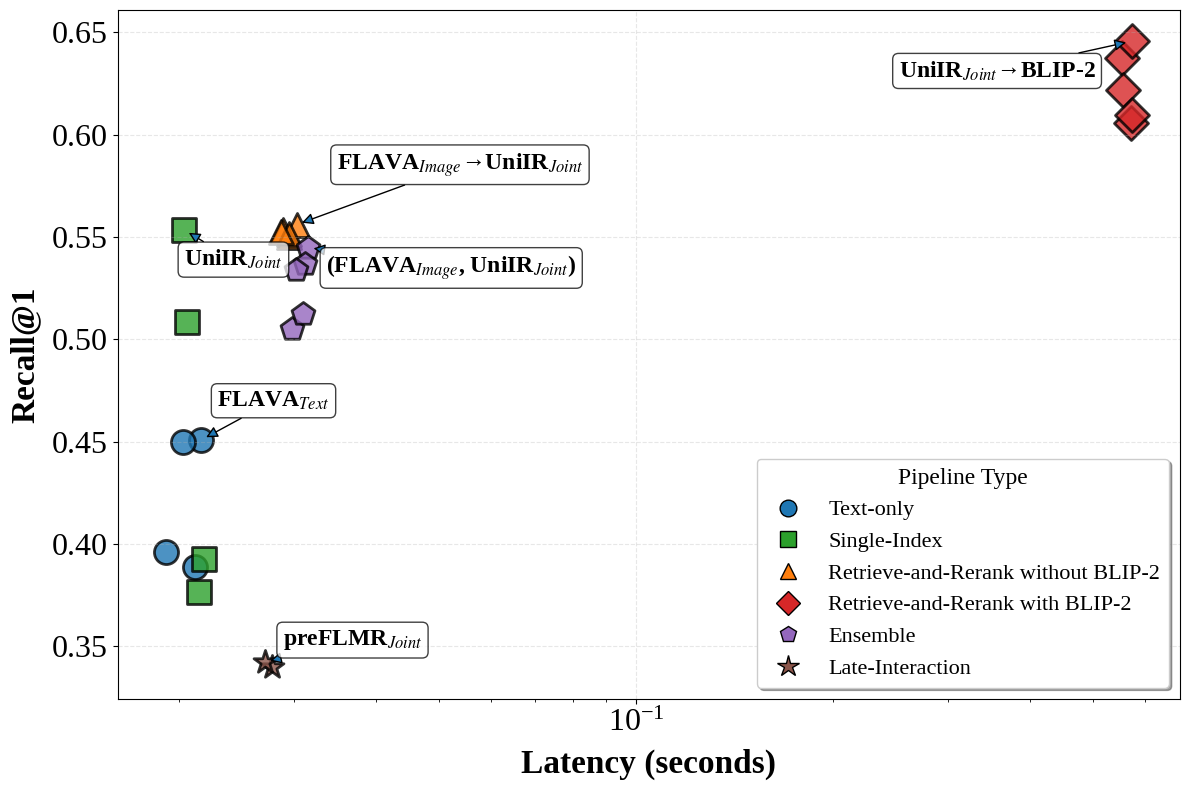

✓ MSCOCO scatter plot saved as 'recall_vs_latency_mscoco_labeled.png'
  Total MSCOCO data points: 25


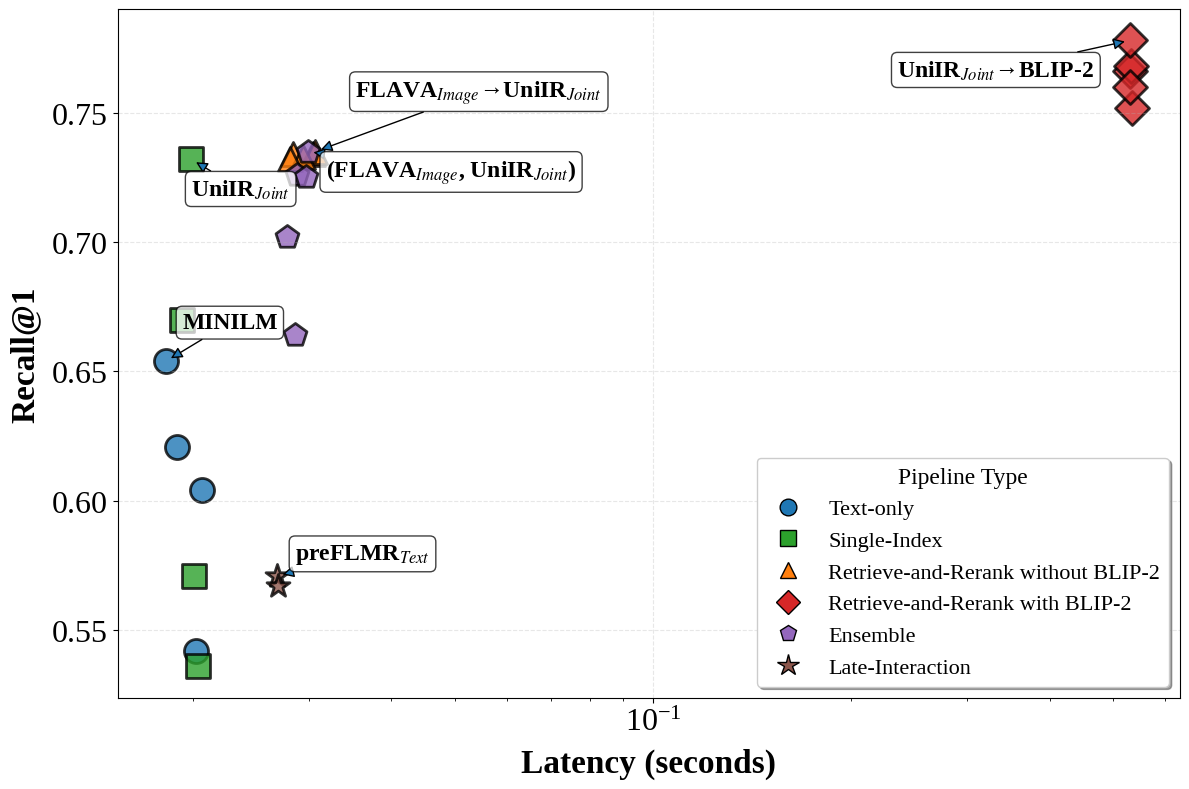

✓ Flickr scatter plot saved as 'recall_vs_latency_flickr_labeled.png'
  Total Flickr data points: 25

SUMMARY STATISTICS - RECALL VS LATENCY (best per pipeline marked on plots)

📊 MSCOCO Dataset (25 points):
  Text-only                               :  4 points | Recall@1: 0.3886-0.4508, Latency: 0.019094-0.021610s
  Single-Index                            :  4 points | Recall@1: 0.3766-0.5534, Latency: 0.020339-0.021800s
  Retrieve-and-Rerank without BLIP-2      :  5 points | Recall@1: 0.5500-0.5560, Latency: 0.028592-0.030241s
  Retrieve-and-Rerank with BLIP-2         :  5 points | Recall@1: 0.6056-0.6456, Latency: 0.554640-0.573004s
  Ensemble                                :  5 points | Recall@1: 0.5050-0.5448, Latency: 0.029770-0.031480s
  Late-Interaction                        :  2 points | Recall@1: 0.3396-0.3422, Latency: 0.027030-0.027720s

📊 Flickr Dataset (25 points):
  Text-only                               :  4 points | Recall@1: 0.5420-0.6540, Latency: 0.018180-0.020610

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.transforms import Bbox
import math, re  # <-- added re

# =========================
# Font sizing controls (only axes/ticks)
# =========================
AXIS_LABEL_FONTSIZE = 24   # axis label size
TICK_LABEL_FONTSIZE = 23   # tick label size
TITLE_FONTSIZE = 25        # figure titles
LEGEND_FONTSIZE = 16       # keep legend same
LEGEND_TITLE_FONTSIZE = 17 # keep legend title same
ANNOT_FONTSIZE = 17        # label text size

# =========================
# Data (R@1, total_time without retrieval)
# Format: (name, dataset, recall_r1, latency, pipeline_type, marker_type)
# =========================
data = [
    # -------- MSCOCO: Text-only --------
    ("MINILM", "MSCOCO", 0.3962, 0.019094, "Text-only", "circle"),
    ("CLIP_Text", "MSCOCO", 0.3886, 0.021109, "Text-only", "circle"),
    ("FLAVA_Text", "MSCOCO", 0.4508, 0.02161, "Text-only", "circle"),
    ("UniIR_Text", "MSCOCO", 0.4500, 0.020292, "Text-only", "circle"),

    # -------- MSCOCO: Single-Index --------
    ("CLIP_Image", "MSCOCO", 0.3766, 0.02147 , "Single-Index", "square"),
    ("FLAVA_Image", "MSCOCO", 0.3926, 0.02180, "Single-Index", "square"),
    ("UniIR_Image", "MSCOCO", 0.5082, 0.02058, "Single-Index", "square"),
    ("UniIR_Joint", "MSCOCO", 0.5534, 0.020339, "Single-Index", "square"),

    # -------- MSCOCO: Retrieve-and-Rerank without BLIP-2 --------
    ("CLIP_Image→UniIR_Joint", "MSCOCO", 0.55,  0.029465 , "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "MSCOCO", 0.556,  0.030241, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint", "MSCOCO", 0.5532, 0.028836, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Text→UniIR_Joint",  "MSCOCO", 0.5516, 0.02942, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint",  "MSCOCO", 0.5522, 0.028592, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # -------- MSCOCO: Retrieve-and-Rerank with BLIP-2 --------
    ("UniIR_Image→BLIP-2",             "MSCOCO", 0.6374, 0.554640,   "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→BLIP-2",             "MSCOCO", 0.6218, 0.556091,   "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2",              "MSCOCO", 0.6056,  0.571018,   "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→BLIP-2",              "MSCOCO", 0.6098, 0.573004,   "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2",             "MSCOCO", 0.6456, 0.572662,   "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # -------- MSCOCO: Ensemble --------
    ("(UniIR_Text, UniIR_Joint)",   "MSCOCO", 0.5050, 0.02977,  "Ensemble", "pentagon"),
    ("(FLAVA_Text, UniIR_Joint)",   "MSCOCO", 0.5124, 0.03095,  "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)",  "MSCOCO", 0.5448, 0.03148,  "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)",   "MSCOCO", 0.5370, 0.03109,  "Ensemble", "pentagon"),
    ("(UniIR_Image, UniIR_Joint)",  "MSCOCO", 0.5336, 0.030219, "Ensemble", "pentagon"),

    # -------- MSCOCO: Late-Interaction (PreFLMR) --------
    ("preFLMR_Text",  "MSCOCO", 0.3396, 0.02772, "Late-Interaction", "star"),
    ("preFLMR_Joint", "MSCOCO", 0.3422, 0.02703, "Late-Interaction", "star"),

    # -------- Flickr: Text-only --------
    ("MINILM", "Flickr", 0.6540,  0.01818, "Text-only", "circle"),
    ("CLIP_Text", "Flickr", 0.5420, 0.020210, "Text-only", "circle"),
    ("FLAVA_Text", "Flickr", 0.6040, 0.02061, "Text-only", "circle"),
    ("UniIR_Text", "Flickr", 0.6210, 0.01891, "Text-only", "circle"),

    # -------- Flickr: Single-Index --------
    ("CLIP_Image", "Flickr", 0.5710,  0.02003, "Single-Index", "square"),
    ("FLAVA_Image", "Flickr", 0.5360,  0.02033, "Single-Index", "square"),
    ("UniIR_Image", "Flickr", 0.6700, 0.019216, "Single-Index", "square"),
    ("UniIR_Joint", "Flickr", 0.7320, 0.019853, "Single-Index", "square"),

    # -------- Flickr: Retrieve-and-Rerank without BLIP-2 --------
    ("MINILM→UniIR_Joint",       "Flickr", 0.734,0.028369, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint",   "Flickr", 0.734, 0.030409, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint",  "Flickr", 0.735, 0.030661, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint",  "Flickr", 0.733, 0.029364, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint",   "Flickr", 0.732, 0.028055, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # -------- Flickr: Retrieve-and-Rerank with BLIP-2 --------
    ("MINILM→BLIP-2",                   "Flickr", 0.7660, 0.530582,  "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→BLIP-2",              "Flickr", 0.7680, 0.531725,  "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→BLIP-2",               "Flickr", 0.7520, 0.53319,   "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2",              "Flickr", 0.7780, 0.53063,   "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2",               "Flickr", 0.7600, 0.53068,   "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # -------- Flickr: Ensemble --------
    ("(UniIR_Text, UniIR_Joint)",  "Flickr", 0.6640, 0.0285869,   "Ensemble", "pentagon"),
    ("(UniIR_Image, UniIR_Joint)", "Flickr", 0.7260, 0.028742,    "Ensemble", "pentagon"),
    ("(MINILM, UniIR_Joint)",      "Flickr", 0.7020, 0.0277139,   "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)",  "Flickr", 0.7250, 0.029614,    "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "Flickr", 0.7350, 0.0298564,   "Ensemble", "pentagon"),

    # -------- Flickr: Late-Interaction (PreFLMR) --------
    ("preFLMR_Text",  "Flickr", 0.5710, 0.026807, "Late-Interaction", "star"),
    ("preFLMR_Joint", "Flickr", 0.5670, 0.02686,  "Late-Interaction", "star"),
]

# =========================
# Colors / markers
# =========================
pipeline_colors = {
    "Text-only": "#1f77b4",
    "Single-Index": "#2ca02c",
    "Retrieve-and-Rerank without BLIP-2": "#ff7f0e",
    "Retrieve-and-Rerank with BLIP-2": "#d62728",
    "Ensemble": "#9467bd",
    "Late-Interaction": "#8c564b",
}
marker_styles = {
    "circle": "o",
    "square": "s",
    "triangle": "^",
    "diamond": "D",
    "pentagon": "p",
    "star": "*",
}

# =========================
# Label layout controls
# =========================
OFFSETS = {
    "Text-only": (16, 28),
    "Single-Index": (-14, -12),
    "Retrieve-and-Rerank without BLIP-2": (40, 46),
    "Retrieve-and-Rerank with BLIP-2": (-36, 18),
    "Ensemble": (18, -6),
    "Late-Interaction": (18, 10),
}
LABEL_BBOX = dict(boxstyle="round,pad=0.25", fc="white", ec="black", alpha=0.75)
ARROW = dict(arrowstyle="-|>", shrinkA=0, shrinkB=4, lw=1)
EDGE_PAD_PX = 4  # min pixels from axes edge

def _bboxes_overlap(b1, b2):
    return not (b1.x1 <= b2.x0 or b1.x0 >= b2.x1 or b1.y1 <= b2.y0 or b1.y0 >= b2.y1)

def _candidate_offsets(dx, dy):
    # Offsets in **pixels** for precise boundary fitting
    return [
        ( dx,  dy), ( dx, -dy), (-dx,  dy), (-dx, -dy),
        (1.5*dx, 0), (0, 1.5*dy), (-1.5*dx, 0), (0, -1.5*dy),
        (2*dx,  2*dy), (-2*dx, 2*dy), (2*dx, -2*dy), (-2*dx, -2*dy),
        (2.5*dx, 0), (0, 2.5*dy), (-2.5*dx, 0), (0, -2.5*dy),
    ]

def _bbox_inside_axes(ax, bbox, pad_px=EDGE_PAD_PX):
    renderer = ax.figure.canvas.get_renderer()
    axbb = ax.get_window_extent(renderer=renderer)
    inner = Bbox.from_extents(axbb.x0 + pad_px, axbb.y0 + pad_px,
                              axbb.x1 - pad_px, axbb.y1 - pad_px)
    return (inner.x0 <= bbox.x0) and (bbox.x1 <= inner.x1) and \
           (inner.y0 <= bbox.y0) and (bbox.y1 <= inner.y1)

def _fallback_offset_inside(ax, x, y, base_dx, base_dy):
    # Choose a direction that points inward if the point is near an edge.
    renderer = ax.figure.canvas.get_renderer()
    axbb = ax.get_window_extent(renderer=renderer)
    px, py = ax.transData.transform((x, y))
    dx, dy = base_dx, base_dy
    if px > axbb.x1 - 80:  dx = -abs(dx)  # near right edge -> push left
    if px < axbb.x0 + 80:  dx =  abs(dx)  # near left edge  -> push right
    if py > axbb.y1 - 60:  dy = -abs(dy)  # near top edge   -> push down
    if py < axbb.y0 + 60:  dy =  abs(dy)  # near bottom     -> push up
    return dx, dy

def _nudge_to_fit(ax, ann, dx, dy, pad_px=EDGE_PAD_PX):
    # Shift (in pixels) to bring the annotation box inside the axes.
    renderer = ax.figure.canvas.get_renderer()
    axbb = ax.get_window_extent(renderer=renderer)
    bbox = ann.get_window_extent(renderer=renderer)
    shift_x = shift_y = 0
    if bbox.x0 < axbb.x0 + pad_px: shift_x = (axbb.x0 + pad_px) - bbox.x0
    if bbox.x1 > axbb.x1 - pad_px: shift_x = (axbb.x1 - pad_px) - bbox.x1
    if bbox.y0 < axbb.y0 + pad_px: shift_y = (axbb.y0 + pad_px) - bbox.y0
    if bbox.y1 > axbb.y1 - pad_px: shift_y = (axbb.y1 - pad_px) - bbox.y1
    if shift_x or shift_y:
        ann.set_position((dx + shift_x, dy + shift_y))
        ann.figure.canvas.draw()
        return dx + shift_x, dy + shift_y
    return dx, dy

# ---------- underscore→subscript in labels ----------
def _format_modality_subscripts(s: str) -> str:
    """
    Convert every `_Token` into `$_{Token}$` so modalities render as subscripts.
    Examples:
      UniIR_Text→FLAVA_Image           -> UniIR$_{Text}$→FLAVA$_{Image}$
      (UniIR_Image, UniIR_Joint)       -> (UniIR$_{Image}$, UniIR$_{Joint}$)
    """
    return re.sub(r'([A-Za-z0-9\)])_([A-Za-z0-9\-]+)', r'\1$_{\2}$', s)

# ---------- NEW: pick best-by-pipeline (max recall, tie -> min latency) ----------
def pick_best_point_by_pipeline(subset, pipeline_type):
    """
    Returns (latency, recall, name) of the best model for a pipeline_type
    according to highest Recall@1; ties are broken by lower latency.
    """
    pts = [(lat, rec, name) for (name, _d, rec, lat, p, _m) in subset if p == pipeline_type]
    if not pts:
        return None
    # Max recall; if tie, min latency
    best = max(pts, key=lambda t: (t[1], -t[0]*-1))  # simpler: sort by (recall, -latency)
    # Alternatively, be explicit:
    # best_recall = max(r for (_x, r, _n) in pts)
    # candidates = [t for t in pts if t[1] == best_recall]
    # best = min(candidates, key=lambda t: t[0])
    return best

def annotate_best_per_pipeline(ax, subset):
    """
    Annotate exactly ONE label per pipeline type at the BEST point
    (max Recall@1, tie-broken by min latency), ensuring labels stay inside axes.
    """
    types_here = sorted({ptype for (_n,_d,_r,_x,ptype,_m) in subset})
    placed = []
    for ptype in types_here:
        rep = pick_best_point_by_pipeline(subset, ptype)
        if rep is None:
            continue
        latency, recall, model_name = rep
        base_dx, base_dy = OFFSETS.get(ptype, (12, 12))

        ann = None
        # Try a set of candidate offsets and keep only those that fit inside.
        for dx, dy in _candidate_offsets(base_dx, base_dy):
            ann = ax.annotate(
                _format_modality_subscripts(model_name),
                xy=(latency, recall), xytext=(dx, dy), textcoords="offset pixels",
                fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx >= 0 else "right",
                va="bottom" if dy >= 0 else "top",
                bbox=LABEL_BBOX, arrowprops=ARROW, clip_on=False, zorder=5
            )
            ax.figure.canvas.draw()
            bbox = ann.get_window_extent(renderer=ax.figure.canvas.get_renderer()).expanded(1.02, 1.08)
            if (not _bbox_inside_axes(ax, bbox)) or any(_bboxes_overlap(bbox, b) for b in placed):
                ann.remove()
                ann = None
                continue
            placed.append(bbox)
            break

        if ann is None:
            # Fallback: choose an inward offset based on proximity to edges, then nudge into view.
            fdx, fdy = _fallback_offset_inside(ax, latency, recall, base_dx, base_dy)
            ann = ax.annotate(
                _format_modality_subscripts(model_name),
                xy=(latency, recall), xytext=(fdx, fdy), textcoords="offset pixels",
                fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if fdx >= 0 else "right",
                va="bottom" if fdy >= 0 else "top",
                bbox=LABEL_BBOX, arrowprops=ARROW, clip_on=False, zorder=5
            )
            ax.figure.canvas.draw()
            _nudge_to_fit(ax, ann, fdx, fdy)
            bbox = ann.get_window_extent(renderer=ax.figure.canvas.get_renderer()).expanded(1.02, 1.08)
            placed.append(bbox)

# ---------- legend spec reused for both plots ----------
legend_elements = [
    Line2D([0],[0], marker='o', color='w', markerfacecolor=pipeline_colors["Text-only"],
           markersize=12, label='Text-only', markeredgecolor='black', linewidth=2),
    Line2D([0],[0], marker='s', color='w', markerfacecolor=pipeline_colors["Single-Index"],
           markersize=12, label='Single-Index', markeredgecolor='black', linewidth=2),
    Line2D([0],[0], marker='^', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank without BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank without BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0],[0], marker='D', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank with BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank with BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0],[0], marker='p', color='w', markerfacecolor=pipeline_colors["Ensemble"],
           markersize=12, label='Ensemble', markeredgecolor='black', linewidth=2),
    Line2D([0],[0], marker='*', color='w', markerfacecolor=pipeline_colors["Late-Interaction"],
           markersize=16, label='Late-Interaction', markeredgecolor='black', linewidth=2),
]

# ---------- Split by dataset (MSCOCO fixed) ----------
mscoco_data  = [d for d in data if d[1] == "MSCOCO"]
flickr_data  = [d for d in data if d[1] == "Flickr"]

# ================= MSCOCO plot =================
fig_mscoco, ax_mscoco = plt.subplots(figsize=(12, 8))
for name, dataset, recall, latency, pipeline_type, marker_type in mscoco_data:
    ax_mscoco.scatter(
        latency, recall, s=300, alpha=0.8,
        color=pipeline_colors[pipeline_type],
        marker=marker_styles[marker_type],
        edgecolors='black', linewidth=2
    )

ax_mscoco.set_xlabel("Latency (seconds)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_mscoco.set_ylabel("Recall@1", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
# ax_mscoco.set_title("MSCOCO Dataset: Recall@1 vs Latency", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
ax_mscoco.grid(True, alpha=0.3, linestyle='--')
ax_mscoco.set_xscale('log')
ax_mscoco.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)

# >>> annotate best per pipeline (MSCOCO)
annotate_best_per_pipeline(ax_mscoco, mscoco_data)

ax_mscoco.legend(handles=legend_elements, loc='best', fontsize=LEGEND_FONTSIZE,
                 frameon=True, shadow=True, title='Pipeline Type',
                 title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('recall_vs_latency_mscoco_labeled.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ MSCOCO scatter plot saved as 'recall_vs_latency_mscoco_labeled.png'")
print(f"  Total MSCOCO data points: {len(mscoco_data)}")

# ================= Flickr plot =================
fig_flickr, ax_flickr = plt.subplots(figsize=(12, 8))
for name, dataset, recall, latency, pipeline_type, marker_type in flickr_data:
    ax_flickr.scatter(
        latency, recall, s=300, alpha=0.8,
        color=pipeline_colors[pipeline_type],
        marker=marker_styles[marker_type],
        edgecolors='black', linewidth=2
    )

ax_flickr.set_xlabel("Latency (seconds)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_flickr.set_ylabel("Recall@1", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_flickr.set_title("", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
ax_flickr.grid(True, alpha=0.3, linestyle='--')
ax_flickr.set_xscale('log')
ax_flickr.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)

# >>> annotate best per pipeline (Flickr)
annotate_best_per_pipeline(ax_flickr, flickr_data)

ax_flickr.legend(handles=legend_elements, loc='best', fontsize=LEGEND_FONTSIZE,
                 frameon=True, shadow=True, title='Pipeline Type',
                 title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('recall_vs_latency_flickr_labeled.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Flickr scatter plot saved as 'recall_vs_latency_flickr_labeled.png'")
print(f"  Total Flickr data points: {len(flickr_data)}")

# ================= Summary statistics =================
print("\n" + "="*70)
print("SUMMARY STATISTICS - RECALL VS LATENCY (best per pipeline marked on plots)")
print("="*70)

print(f"\n📊 MSCOCO Dataset ({len(mscoco_data)} points):")
for pipeline_type in pipeline_colors.keys():
    mscoco_subset = [d for d in mscoco_data if d[4] == pipeline_type]
    if mscoco_subset:
        recalls = [d[2] for d in mscoco_subset]
        latencies = [d[3] for d in mscoco_subset]
        print(f"  {pipeline_type:40s}: {len(mscoco_subset):2d} points | "
              f"Recall@1: {min(recalls):.4f}-{max(recalls):.4f}, "
              f"Latency: {min(latencies):.6f}-{max(latencies):.6f}s")

print(f"\n📊 Flickr Dataset ({len(flickr_data)} points):")
for pipeline_type in pipeline_colors.keys():
    flickr_subset = [d for d in flickr_data if d[4] == pipeline_type]
    if flickr_subset:
        recalls = [d[2] for d in flickr_subset]
        latencies = [d[3] for d in flickr_subset]
        print(f"  {pipeline_type:40s}: {len(flickr_subset):2d} points | "
              f"Recall@1: {min(recalls):.4f}-{max(recalls):.4f}, "
              f"Latency: {min(latencies):.6f}-{max(latencies):.6f}s")

print("\n" + "="*70)


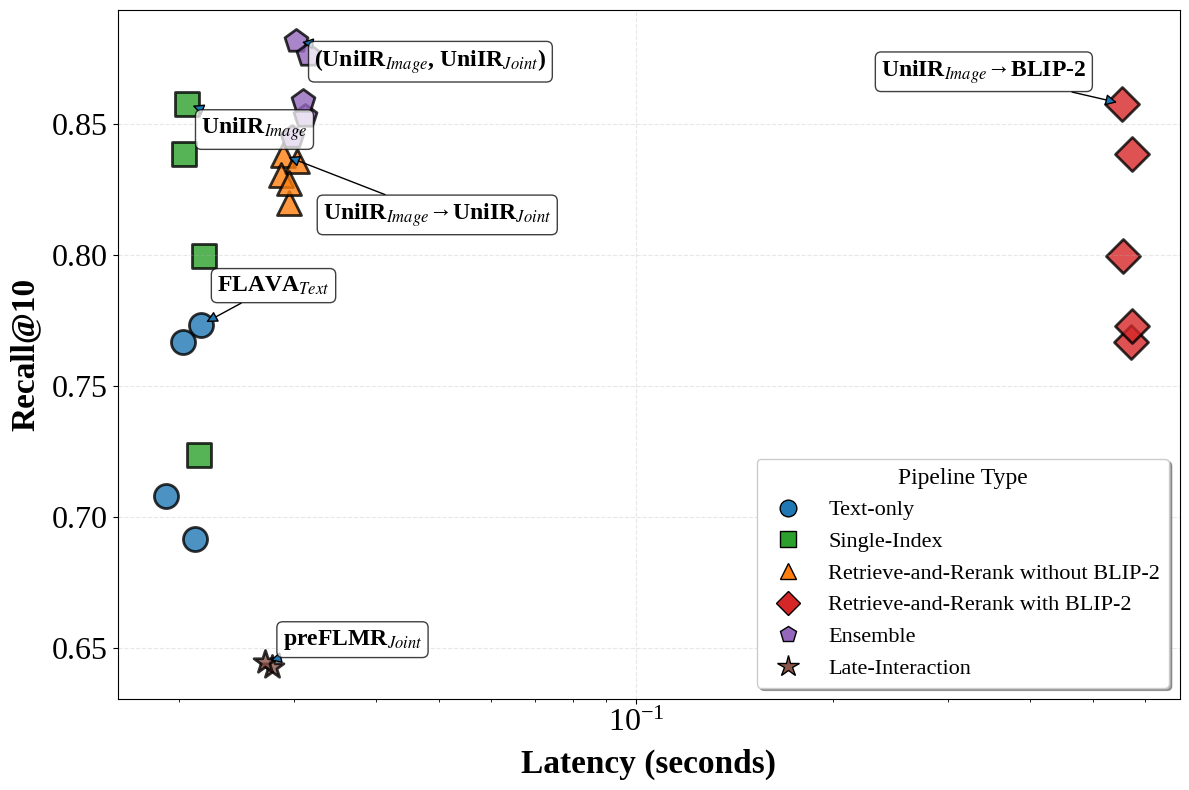

✓ COCO scatter plot saved as 'recall10_vs_latency_coco_labeled.png'
  Total COCO data points: 25


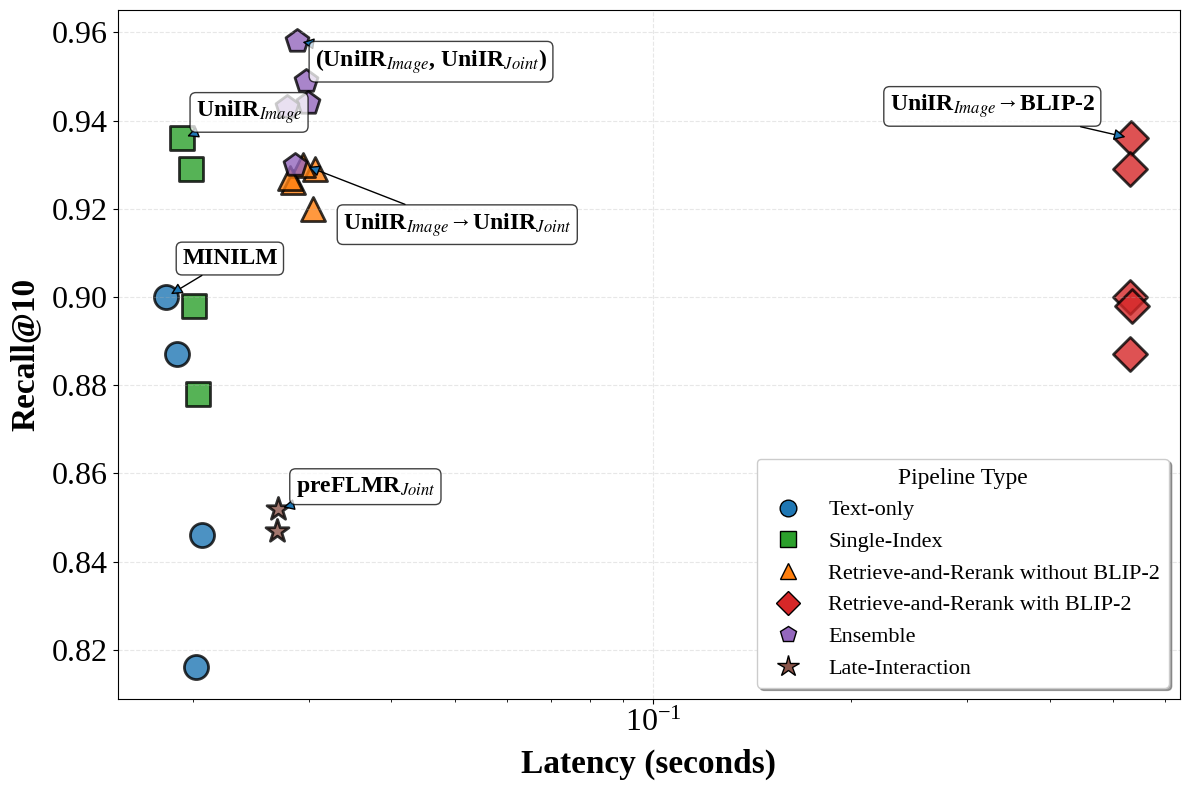

✓ Flickr scatter plot saved as 'recall10_vs_latency_flickr_labeled.png'
  Total Flickr data points: 25

SUMMARY STATISTICS - RECALL VS LATENCY (R@10; best per pipeline annotated)

📊 COCO Dataset (25 points):
  Text-only                               :  4 points | R@10: 0.6916-0.7734, Latency: 0.019094-0.021610s
  Single-Index                            :  4 points | R@10: 0.7238-0.8578, Latency: 0.020339-0.021800s
  Retrieve-and-Rerank without BLIP-2      :  5 points | R@10: 0.8200-0.8382, Latency: 0.028592-0.030241s
  Retrieve-and-Rerank with BLIP-2         :  5 points | R@10: 0.7668-0.8578, Latency: 0.554640-0.573004s
  Ensemble                                :  5 points | R@10: 0.8450-0.8816, Latency: 0.029770-0.031480s
  Late-Interaction                        :  2 points | R@10: 0.6426-0.6448, Latency: 0.027030-0.027720s

📊 Flickr Dataset (25 points):
  Text-only                               :  4 points | R@10: 0.8160-0.9000, Latency: 0.018180-0.020610s
  Single-Index            

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.transforms import Bbox
import re

# =========================
# Font sizing controls
# =========================
AXIS_LABEL_FONTSIZE = 24
TICK_LABEL_FONTSIZE = 23
TITLE_FONTSIZE = 25
LEGEND_FONTSIZE = 16
LEGEND_TITLE_FONTSIZE = 17
ANNOT_FONTSIZE = 17

# =========================
# Data (R@10 values)
# Format: (name, dataset, recall_r10, latency, pipeline_type, marker_type)
# =========================
data = [
    # COCO - Text-only
    ("MINILM", "COCO", 0.7082, 0.019094, "Text-only", "circle"),
    ("UniIR_Text", "COCO", 0.7668, 0.020292, "Text-only", "circle"),
    ("CLIP_Text", "COCO", 0.6916, 0.021109, "Text-only", "circle"),
    ("FLAVA_Text", "COCO", 0.7734, 0.02161, "Text-only", "circle"),

    # COCO - Single-Index
    ("UniIR_Image", "COCO", 0.8578, 0.02058, "Single-Index", "square"),
    ("CLIP_Image", "COCO", 0.7238, 0.02147, "Single-Index", "square"),
    ("FLAVA_Image", "COCO", 0.7998, 0.02180, "Single-Index", "square"),
    ("UniIR_Joint", "COCO", 0.8384, 0.020339, "Single-Index", "square"),

    # COCO - Retrieve-and-Rerank → UniIR_Joint (no BLIP-2)
    ("UniIR_Image→UniIR_Joint", "COCO", 0.8382, 0.028836, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint", "COCO", 0.8200, 0.029465, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "COCO", 0.8360, 0.030241, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "COCO", 0.8304, 0.028592, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Text→UniIR_Joint", "COCO", 0.8276, 0.02942, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # COCO - Retrieve-and-Rerank → BLIP-2
    ("UniIR_Image→BLIP-2", "COCO", 0.8578, 0.554640, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→BLIP-2", "COCO", 0.7998, 0.556091, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "COCO", 0.7668, 0.571018, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "COCO", 0.8384, 0.572662, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→BLIP-2", "COCO", 0.7728, 0.573004, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # COCO - Ensemble (RRF)
    ("(UniIR_Image, UniIR_Joint)", "COCO", 0.8816, 0.030219, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)",  "COCO", 0.8532, 0.03109,  "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "COCO", 0.8764, 0.03148,  "Ensemble", "pentagon"),
    ("(UniIR_Text, UniIR_Joint)",  "COCO", 0.8450, 0.02977,  "Ensemble", "pentagon"),
    ("(FLAVA_Text, UniIR_Joint)",  "COCO", 0.8590, 0.03095,  "Ensemble", "pentagon"),

    # COCO - Late Interaction
    ("preFLMR_Text", "COCO", 0.6426, 0.02772, "Late-Interaction", "star"),
    ("preFLMR_Joint", "COCO", 0.6448, 0.02703, "Late-Interaction", "star"),

    # Flickr - Text-only
    ("MINILM", "Flickr", 0.9000, 0.01818,  "Text-only", "circle"),
    ("UniIR_Text", "Flickr", 0.8870, 0.01891,  "Text-only", "circle"),
    ("CLIP_Text", "Flickr", 0.8160, 0.020210, "Text-only", "circle"),
    ("FLAVA_Text", "Flickr", 0.8460, 0.02061,  "Text-only", "circle"),

    # Flickr - Single-Index
    ("UniIR_Image", "Flickr", 0.9360, 0.019216, "Single-Index", "square"),
    ("CLIP_Image", "Flickr", 0.8980, 0.02003,  "Single-Index", "square"),
    ("FLAVA_Image", "Flickr", 0.8780, 0.02033,  "Single-Index", "square"),
    ("UniIR_Joint", "Flickr", 0.9290, 0.019853, "Single-Index", "square"),

    # Flickr - Retrieve-and-Rerank → UniIR_Joint (no BLIP-2)
    ("MINILM→UniIR_Joint", "Flickr", 0.9260, 0.028369, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint", "Flickr", 0.9200, 0.030409, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "Flickr", 0.9290, 0.030661, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint", "Flickr", 0.9300, 0.029364, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "Flickr", 0.9270, 0.028055, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # Flickr - Retrieve-and-Rerank → BLIP-2
    ("MINILM→BLIP-2", "Flickr", 0.9000, 0.530582, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→BLIP-2", "Flickr", 0.9360, 0.531725, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "Flickr", 0.8870, 0.53068,  "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "Flickr", 0.9290, 0.53063,  "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→BLIP-2", "Flickr", 0.8980, 0.53319,  "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # Flickr - Ensemble (RRF) — using R@10
    ("(UniIR_Image, UniIR_Joint)", "Flickr", 0.9580, 0.028742,  "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)",  "Flickr", 0.9490, 0.029614,  "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "Flickr", 0.9440, 0.0298564, "Ensemble", "pentagon"),
    ("(UniIR_Text, UniIR_Joint)",  "Flickr", 0.9300, 0.0285869, "Ensemble", "pentagon"),
    ("(MINILM, UniIR_Joint)",      "Flickr", 0.9430, 0.0277139, "Ensemble", "pentagon"),

    # Flickr - Late Interaction
    ("preFLMR_Text", "Flickr", 0.8470, 0.026807, "Late-Interaction", "star"),
    ("preFLMR_Joint", "Flickr", 0.8520, 0.02686,  "Late-Interaction", "star"),
]



# =========================
# Colors / markers
# =========================
pipeline_colors = {
    "Text-only": "#1f77b4",
    "Single-Index": "#2ca02c",
    "Retrieve-and-Rerank without BLIP-2": "#ff7f0e",
    "Retrieve-and-Rerank with BLIP-2": "#d62728",
    "Ensemble": "#9467bd",
    "Late-Interaction": "#8c564b",
    # "BM25": "#17becf",  # commented out
}
marker_styles = {
    "circle": "o",
    "square": "s",
    "triangle": "^",
    "diamond": "D",
    "pentagon": "p",
    "star": "*",
    # "hexagon": "h",     # commented out
}

# =========================
# Label layout controls
# =========================
OFFSETS = {
    "Text-only": (16, 28),
    "Single-Index": (-14, -12),
    "Retrieve-and-Rerank without BLIP-2": (40, 46),
    "Retrieve-and-Rerank with BLIP-2": (-36, 18),
    "Ensemble": (18, -6),
    "Late-Interaction": (18, 10),
    # "BM25": (24, -14),
}
LABEL_BBOX = dict(boxstyle="round,pad=0.25", fc="white", ec="black", alpha=0.75)
ARROW = dict(arrowstyle="-|>", shrinkA=0, shrinkB=4, lw=1)
EDGE_PAD_PX = 4  # min pixels from axes edge

def _bboxes_overlap(b1, b2):
    return not (b1.x1 <= b2.x0 or b1.x0 >= b2.x1 or b1.y1 <= b2.y0 or b1.y0 >= b2.y1)

def _candidate_offsets(dx, dy):
    # Offsets in **pixels** for precise boundary fitting
    return [
        ( dx,  dy), ( dx, -dy), (-dx,  dy), (-dx, -dy),
        (1.5*dx, 0), (0, 1.5*dy), (-1.5*dx, 0), (0, -1.5*dy),
        (2*dx,  2*dy), (-2*dx, 2*dy), (2*dx, -2*dy), (-2*dx, -2*dy),
        (2.5*dx, 0), (0, 2.5*dy), (-2.5*dx, 0), (0, -2.5*dy),
    ]

def _bbox_inside_axes(ax, bbox, pad_px=EDGE_PAD_PX):
    renderer = ax.figure.canvas.get_renderer()
    axbb = ax.get_window_extent(renderer=renderer)
    inner = Bbox.from_extents(axbb.x0 + pad_px, axbb.y0 + pad_px,
                              axbb.x1 - pad_px, axbb.y1 - pad_px)
    return (inner.x0 <= bbox.x0) and (bbox.x1 <= inner.x1) and \
           (inner.y0 <= bbox.y0) and (bbox.y1 <= inner.y1)

def _fallback_offset_inside(ax, x, y, base_dx, base_dy):
    # Choose a direction that points inward if the point is near an edge.
    renderer = ax.figure.canvas.get_renderer()
    axbb = ax.get_window_extent(renderer=renderer)
    px, py = ax.transData.transform((x, y))
    dx, dy = base_dx, base_dy
    if px > axbb.x1 - 80:  dx = -abs(dx)  # near right edge -> push left
    if px < axbb.x0 + 80:  dx =  abs(dx)  # near left edge  -> push right
    if py > axbb.y1 - 60:  dy = -abs(dy)  # near top edge   -> push down
    if py < axbb.y0 + 60:  dy =  abs(dy)  # near bottom     -> push up
    return dx, dy

def _nudge_to_fit(ax, ann, dx, dy, pad_px=EDGE_PAD_PX):
    # Shift (in pixels) to bring the annotation box inside the axes.
    renderer = ax.figure.canvas.get_renderer()
    axbb = ax.get_window_extent(renderer=renderer)
    bbox = ann.get_window_extent(renderer=renderer)
    shift_x = shift_y = 0
    if bbox.x0 < axbb.x0 + pad_px: shift_x = (axbb.x0 + pad_px) - bbox.x0
    if bbox.x1 > axbb.x1 - pad_px: shift_x = (axbb.x1 - pad_px) - bbox.x1
    if bbox.y0 < axbb.y0 + pad_px: shift_y = (axbb.y0 + pad_px) - bbox.y0
    if bbox.y1 > axbb.y1 - pad_px: shift_y = (axbb.y1 - pad_px) - bbox.y1
    if shift_x or shift_y:
        ann.set_position((dx + shift_x, dy + shift_y))
        ann.figure.canvas.draw()
        return dx + shift_x, dy + shift_y
    return dx, dy

# ---------- underscore→subscript in labels (FIXED regex) ----------
def _format_modality_subscripts(s: str) -> str:
    """
    Convert every `_Token` into `$_{Token}$` so modalities render as subscripts.
    Examples:
      UniIR_Text→FLAVA_Image           -> UniIR$_{Text}$→FLAVA$_{Image}$
      (UniIR_Image, UniIR_Joint)       -> (UniIR$_{Image}$, UniIR$_{Joint}$)
    """
    return re.sub(r'([A-Za-z0-9\)])_([A-Za-z0-9\-]+)', r'\1$_{\2}$', s)

# ---------- BEST per pipeline (max recall; tie -> lower latency) ----------
def pick_best_point_by_pipeline(subset, pipeline_type):
    """
    Returns (latency, recall, name) of the best model for pipeline_type
    according to highest Recall; ties are broken by lower latency.
    """
    pts = [(lat, rec, name) for (name, _d, rec, lat, p, _m) in subset if p == pipeline_type]
    if not pts:
        return None
    # sort by (-recall, latency) and take first
    lat, rec, name = sorted(pts, key=lambda t: (-t[1], t[0]))[0]
    return (lat, rec, name)

def annotate_best_per_pipeline(ax, subset):
    """
    Annotate exactly ONE label per pipeline type at the BEST point.
    Ensures labels stay inside axes and avoid overlap.
    """
    types_here = sorted({ptype for (_n,_d,_r,_x,ptype,_m) in subset})
    placed = []
    for ptype in types_here:
        rep = pick_best_point_by_pipeline(subset, ptype)
        if rep is None:
            continue
        latency, recall, model_name = rep
        base_dx, base_dy = OFFSETS.get(ptype, (12, 12))

        ann = None
        # Try a set of candidate offsets and keep only those that fit inside.
        for dx, dy in _candidate_offsets(base_dx, base_dy):
            ann = ax.annotate(
                _format_modality_subscripts(model_name),
                xy=(latency, recall), xytext=(dx, dy), textcoords="offset pixels",
                fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx >= 0 else "right",
                va="bottom" if dy >= 0 else "top",
                bbox=LABEL_BBOX, arrowprops=ARROW, clip_on=False, zorder=5
            )
            ax.figure.canvas.draw()
            bbox = ann.get_window_extent(renderer=ax.figure.canvas.get_renderer()).expanded(1.02, 1.08)
            if (not _bbox_inside_axes(ax, bbox)) or any(_bboxes_overlap(bbox, b) for b in placed):
                ann.remove()
                ann = None
                continue
            placed.append(bbox)
            break

        if ann is None:
            # Fallback: choose an inward offset, then nudge.
            fdx, fdy = _fallback_offset_inside(ax, latency, recall, base_dx, base_dy)
            ann = ax.annotate(
                _format_modality_subscripts(model_name),
                xy=(latency, recall), xytext=(fdx, fdy), textcoords="offset pixels",
                fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if fdx >= 0 else "right",
                va="bottom" if fdy >= 0 else "top",
                bbox=LABEL_BBOX, arrowprops=ARROW, clip_on=False, zorder=5
            )
            ax.figure.canvas.draw()
            _nudge_to_fit(ax, ann, fdx, fdy)
            bbox = ann.get_window_extent(renderer=ax.figure.canvas.get_renderer()).expanded(1.02, 1.08)
            placed.append(bbox)

# ---------- legend spec reused for both plots (BM25 removed) ----------
legend_elements = [
    Line2D([0],[0], marker='o', color='w', markerfacecolor=pipeline_colors["Text-only"],
           markersize=12, label='Text-only', markeredgecolor='black', linewidth=2),
    Line2D([0],[0], marker='s', color='w', markerfacecolor=pipeline_colors["Single-Index"],
           markersize=12, label='Single-Index', markeredgecolor='black', linewidth=2),
    Line2D([0],[0], marker='^', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank without BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank without BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0],[0], marker='D', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank with BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank with BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0],[0], marker='p', color='w', markerfacecolor=pipeline_colors["Ensemble"],
           markersize=12, label='Ensemble', markeredgecolor='black', linewidth=2),
    Line2D([0],[0], marker='*', color='w', markerfacecolor=pipeline_colors["Late-Interaction"],
           markersize=16, label='Late-Interaction', markeredgecolor='black', linewidth=2),
]

# ---------- Split by dataset ----------
coco_data   = [d for d in data if d[1] == "COCO"]
flickr_data = [d for d in data if d[1] == "Flickr"]

# ================= COCO plot =================
fig_coco, ax_coco = plt.subplots(figsize=(12, 8))
for name, dataset, recall, latency, pipeline_type, marker_type in coco_data:
    ax_coco.scatter(
        latency, recall, s=300, alpha=0.8,
        color=pipeline_colors[pipeline_type],
        marker=marker_styles[marker_type],
        edgecolors='black', linewidth=2
    )
ax_coco.set_xlabel("Latency (seconds)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_coco.set_ylabel("Recall@10", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
# ax_coco.set_title("MSCOCO Dataset: Recall@10 vs Latency", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
ax_coco.grid(True, alpha=0.3, linestyle='--')
ax_coco.set_xscale('log')  # keep log-scale for latency
ax_coco.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)
# No y-limit set → not locked to [0,1]

# annotate best per pipeline (COCO)
annotate_best_per_pipeline(ax_coco, coco_data)

ax_coco.legend(handles=legend_elements, loc='best', fontsize=LEGEND_FONTSIZE,
               frameon=True, shadow=True, title='Pipeline Type',
               title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('recall10_vs_latency_coco_labeled.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ COCO scatter plot saved as 'recall10_vs_latency_coco_labeled.png'")
print(f"  Total COCO data points: {len(coco_data)}")

# ================= Flickr plot =================
fig_flickr, ax_flickr = plt.subplots(figsize=(12, 8))
for name, dataset, recall, latency, pipeline_type, marker_type in flickr_data:
    ax_flickr.scatter(
        latency, recall, s=300, alpha=0.8,
        color=pipeline_colors[pipeline_type],
        marker=marker_styles[marker_type],
        edgecolors='black', linewidth=2
    )
ax_flickr.set_xlabel("Latency (seconds)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_flickr.set_ylabel("Recall@10", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_flickr.set_title("", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
ax_flickr.grid(True, alpha=0.3, linestyle='--')
ax_flickr.set_xscale('log')
ax_flickr.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)
# No y-limit set → not locked to [0,1]

# annotate best per pipeline (Flickr)
annotate_best_per_pipeline(ax_flickr, flickr_data)

ax_flickr.legend(handles=legend_elements, loc='best', fontsize=LEGEND_FONTSIZE,
                 frameon=True, shadow=True, title='Pipeline Type',
                 title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('recall10_vs_latency_flickr_labeled.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Flickr scatter plot saved as 'recall10_vs_latency_flickr_labeled.png'")
print(f"  Total Flickr data points: {len(flickr_data)}")

# ================= Summary statistics =================
print("\n" + "="*70)
print("SUMMARY STATISTICS - RECALL VS LATENCY (R@10; best per pipeline annotated)")
print("="*70)

def _summarize(subset_name, subset):
    print(f"\n📊 {subset_name} ({len(subset)} points):")
    for pipeline_type in pipeline_colors.keys():
        s = [d for d in subset if d[4] == pipeline_type]
        if s:
            recalls = [d[2] for d in s]
            latencies = [d[3] for d in s]
            print(f"  {pipeline_type:40s}: {len(s):2d} points | "
                  f"R@10: {min(recalls):.4f}-{max(recalls):.4f}, "
                  f"Latency: {min(latencies):.6f}-{max(latencies):.6f}s")

_summarize("COCO Dataset", coco_data)
_summarize("Flickr Dataset", flickr_data)
print("\n" + "="*70)


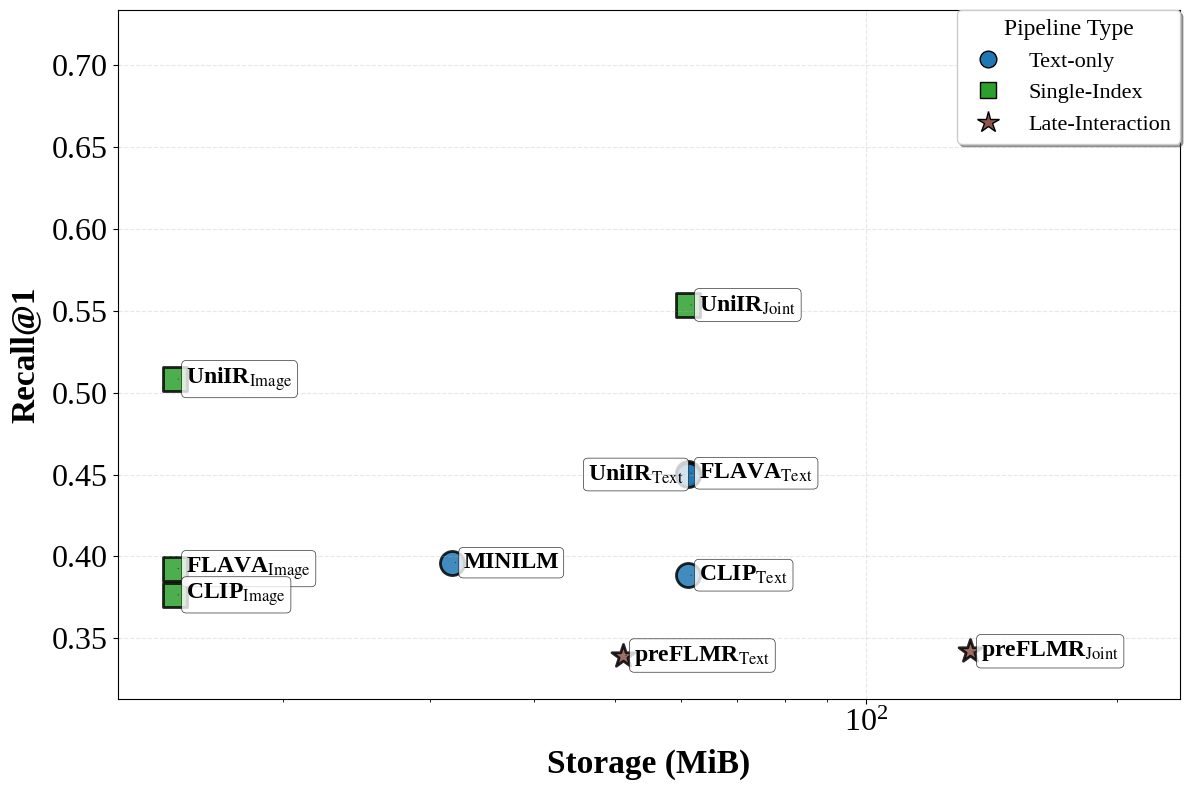

Saved: storage_vs_recall_coco_labeled.png


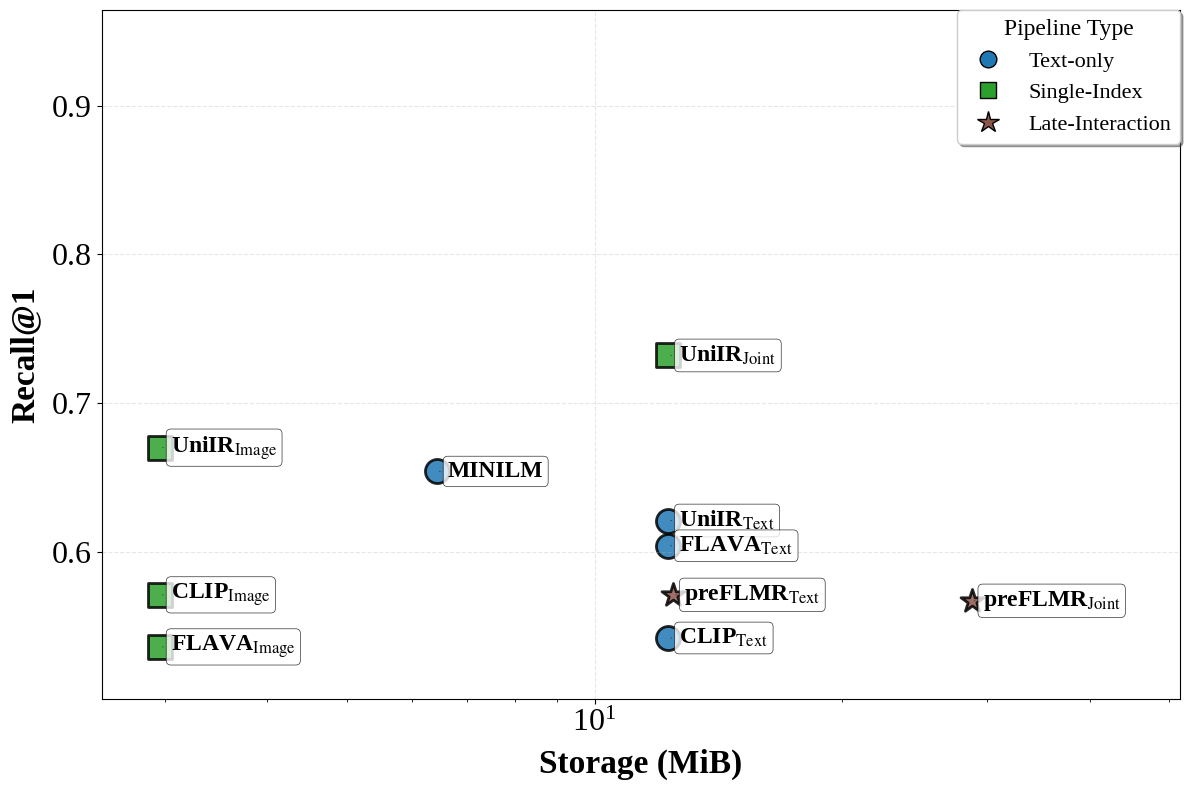

Saved: storage_vs_recall_flickr_labeled.png

SUMMARY STATISTICS - COCO

📊 Text-only (4 point(s)):
    Storage (MiB): 31.93 - 61.23
    Recall@1:      0.3886 - 0.4508
    Models:
      - MINILM
      - CLIP_Text
      - FLAVA_Text
      - UniIR_Text

📊 Single-Index (4 point(s)):
    Storage (MiB): 14.85 - 61.23
    Recall@1:      0.3766 - 0.5534
    Models:
      - CLIP_Image
      - FLAVA_Image
      - UniIR_Image
      - UniIR_Joint

📊 Late-Interaction (2 point(s)):
    Storage (MiB): 51.17 - 133.46
    Recall@1:      0.3396 - 0.3422
    Models:
      - preFLMR_Text
      - preFLMR_Joint

Totals:
    Total COCO points: 10

SUMMARY STATISTICS - Flickr

📊 Text-only (4 point(s)):
    Storage (MiB): 6.43 - 12.29
    Recall@1:      0.5420 - 0.6540
    Models:
      - MINILM
      - CLIP_Text
      - FLAVA_Text
      - UniIR_Text

📊 Single-Index (4 point(s)):
    Storage (MiB): 2.96 - 12.29
    Recall@1:      0.5360 - 0.7320
    Models:
      - CLIP_Image
      - FLAVA_Image
      - UniIR_I

In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np  # for spiral label placement math
import re

# ========== Font sizing controls (axes/ticks only) ==========
AXIS_LABEL_FONTSIZE = 24
TICK_LABEL_FONTSIZE = 23
TITLE_FONTSIZE = 25
LEGEND_FONTSIZE = 16
LEGEND_TITLE_FONTSIZE = 17
ANNOT_FONTSIZE = 17


# ---------- modality→subscript formatter ----------
_SUB_RE = re.compile(r'([A-Za-z0-9]+)_([A-Za-z0-9]+)')
def fmt_modality(name: str) -> str:
    """
    Convert tokens like 'UniIR_Text' -> 'UniIR$_{\\mathrm{Text}}$'
    Works inside chains, parentheses, etc.
    """
    return _SUB_RE.sub(lambda m: f"{m.group(1)}$_{{\\mathrm{{{m.group(2)}}}}}$", name)

# ============================================================
# 1) Recall data  (name, dataset, recall_r1, energy, pipeline_type, marker_type)
#    — energy is unused here; we plot Storage vs Recall@1
# ============================================================
recall_data = [
    # -------- COCO: Text-only --------
    ("MINILM", "COCO", 0.3962, 5811.429, "Text-only", "circle"),
    ("CLIP_Text", "COCO", 0.3886, 7966.375, "Text-only", "circle"),
    ("FLAVA_Text", "COCO", 0.4508, 8192.518, "Text-only", "circle"),
    ("UniIR_Text", "COCO", 0.4500, 8558.791, "Text-only", "circle"),

    # -------- COCO: Single-Index --------
    ("CLIP_Image", "COCO", 0.3766, 5440.233, "Single-Index", "square"),
    ("FLAVA_Image", "COCO", 0.3926, 5671.572, "Single-Index", "square"),
    ("UniIR_Image", "COCO", 0.5082, 6096.318, "Single-Index", "square"),
    ("UniIR_Joint", "COCO", 0.5534, 8610.995, "Single-Index", "square"),

    # -------- COCO: Retrieve-and-Rerank without BLIP-2 --------
    ("CLIP_Image→UniIR_Joint", "COCO", 0.55, 8126.193, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "COCO", 0.556, 8371.911, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint", "COCO", 0.5532, 8731.663, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Text→UniIR_Joint", "COCO", 0.5516, 10726.097, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "COCO", 0.5522, 11040.448, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # -------- COCO: Retrieve-and-Rerank with BLIP-2 --------
    ("UniIR_Image→BLIP-2", "COCO", 0.6374, 186549.050, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→BLIP-2", "COCO", 0.6218, 186615.231, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "COCO", 0.6056, 189141.903, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→BLIP-2", "COCO", 0.6098, 189222.290, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "COCO", 0.6456, 189307.593, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→UniIR_Joint→BLIP-2", "COCO", 0.6446, 236120.681, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→UniIR_Joint→BLIP-2", "COCO", 0.6458, 245911.588, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→UniIR_Joint→BLIP-2", "COCO", 0.6434, 262924.2185, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→UniIR_Joint→BLIP-2", "COCO", 0.6458, 288618.468, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→UniIR_Joint→BLIP-2", "COCO", 0.644, 315481.771, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # -------- COCO: Ensemble --------
    ("(UniIR_Text, UniIR_Joint)", "COCO", 0.5050, 90641.2095, "Ensemble", "pentagon"),
    ("(FLAVA_Text, UniIR_Joint)", "COCO", 0.5124, 92778.6565, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "COCO", 0.5448, 105274.773, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)", "COCO", 0.5370, 105455.913, "Ensemble", "pentagon"),
    ("(UniIR_Image, UniIR_Joint)", "COCO", 0.5336, 105677.2855, "Ensemble", "pentagon"),

    # -------- COCO: Late-Interaction (PreFLMR) --------
    ("preFLMR_Text", "COCO", 0.3396, 12944.118, "Late-Interaction", "star"),
    ("preFLMR_Joint", "COCO", 0.3422, 13292.001, "Late-Interaction", "star"),

    # -------- Flickr: Text-only --------
    ("MINILM", "Flickr", 0.6540, 870.461, "Text-only", "circle"),
    ("CLIP_Text", "Flickr", 0.5420, 1039.328, "Text-only", "circle"),
    ("FLAVA_Text", "Flickr", 0.6040, 1080.792, "Text-only", "circle"),
    ("UniIR_Text", "Flickr", 0.6210, 1164.629, "Text-only", "circle"),

    # -------- Flickr: Single-Index --------
    ("CLIP_Image", "Flickr", 0.5710, 937.406, "Single-Index", "square"),
    ("FLAVA_Image", "Flickr", 0.5360, 975.371, "Single-Index", "square"),
    ("UniIR_Image", "Flickr", 0.6700, 1074.525, "Single-Index", "square"),
    ("UniIR_Joint", "Flickr", 0.7320, 1189.419, "Single-Index", "square"),

    # -------- Flickr: Retrieve-and-Rerank without BLIP-2 --------
    ("MINILM→UniIR_Joint", "Flickr", 0.734, 1422.089, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint", "Flickr", 0.734, 1509.416, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "Flickr", 0.735, 1544.724, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint", "Flickr", 0.733, 1624.571, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "Flickr", 0.732, 1745.200, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # -------- Flickr: Retrieve-and-Rerank with BLIP-2 --------
    ("MINILM→BLIP-2", "Flickr", 0.7660, 37289.005, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→BLIP-2", "Flickr", 0.7680, 37359.645, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→BLIP-2", "Flickr", 0.7520, 37413.210, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "Flickr", 0.7780, 37509.338, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "Flickr", 0.7600, 37662.098, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("MINILM→UniIR_Image→BLIP-2", "Flickr", 0.779, 37676.546, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→FLAVA_Image→BLIP-2", "Flickr", 0.778, 38148.502, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→UniIR_Joint→BLIP-2", "Flickr", 0.784, 48526.450, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→UniIR_Joint→BLIP-2", "Flickr", 0.78, 50759.5645, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("MINILM→UniIR_Joint→BLIP-2", "Flickr", 0.784, 65925.648, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # -------- Flickr: Ensemble --------
    ("(UniIR_Text, UniIR_Joint)", "Flickr", 0.6640, 2525.118, "Ensemble", "pentagon"),
    ("(UniIR_Image, UniIR_Joint)", "Flickr", 0.7260, 3923.4045, "Ensemble", "pentagon"),
    ("(MINILM, UniIR_Joint)", "Flickr", 0.7020, 2892.695, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)", "Flickr", 0.7250, 2875.456, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "Flickr", 0.7350, 2916.763, "Ensemble", "pentagon"),

    # -------- Flickr: Late-Interaction (PreFLMR) --------
    ("preFLMR_Text", "Flickr", 0.5710, 2482.026, "Late-Interaction", "star"),
    ("preFLMR_Joint", "Flickr", 0.5670, 2619.403, "Late-Interaction", "star"),
]

# ============================================================
# 2) Storage lookup (MiB, "Total")
# ============================================================
storage_lookup = {
    # COCO: Text-only
    ("COCO", "MINILM"): 31.93,
    ("COCO", "CLIP_Text"): 61.23,
    ("COCO", "FLAVA_Text"): 61.23,
    ("COCO", "UniIR_Text"): 61.23,

    # COCO: Single-Index
    ("COCO", "CLIP_Image"): 14.85,
    ("COCO", "FLAVA_Image"): 14.85,
    ("COCO", "UniIR_Image"): 14.85,
    ("COCO", "UniIR_Joint"): 61.23,
    ("COCO", "UniIR_JointImgText"): 61.23,

    # COCO: Late-Interaction (PreFLMR)
    ("COCO", "preFLMR_Text"): 51.17,
    ("COCO", "preFLMR_Joint"): 133.46,

    # Flickr: Text-only
    ("Flickr", "MINILM"): 6.43,
    ("Flickr", "CLIP_Text"): 12.29,
    ("Flickr", "FLAVA_Text"): 12.29,
    ("Flickr", "UniIR_Text"): 12.29,

    # Flickr: Single-Index
    ("Flickr", "CLIP_Image"): 2.96,
    ("Flickr", "FLAVA_Image"): 2.96,
    ("Flickr", "UniIR_Image"): 2.96,
    ("Flickr", "UniIR_Joint"): 12.29,
    ("Flickr", "UniIR_JointImgText"): 12.29,

    # Flickr: Late-Interaction (PreFLMR)
    ("Flickr", "preFLMR_Text"): 12.46,
    ("Flickr", "preFLMR_Joint"): 28.75,
}

# ============================================================
# 3) Merge recall with storage (keep points that have storage)
#    -> (name, dataset, storage_mib, recall_r1, pipeline_type, marker_type)
# ============================================================
merged_points = []
for (name, dataset, recall_r1, _energy, pipeline_type, marker_type) in recall_data:
    key = (dataset, name)  # keep raw name for lookup
    if key in storage_lookup:
        merged_points.append(
            (name, dataset, storage_lookup[key], recall_r1, pipeline_type, marker_type)
        )

coco_points   = [p for p in merged_points if p[1] == "COCO"]
flickr_points = [p for p in merged_points if p[1] == "Flickr"]

# ============================================================
# 4) Plot styles + helpers (legend, smart labels)
# ============================================================
pipeline_colors = {
    "Text-only": "#1f77b4",
    "Single-Index": "#2ca02c",
    "Late-Interaction": "#8c564b",
    "Retrieve-and-Rerank without BLIP-2": "#ff7f0e",
    "Retrieve-and-Rerank with BLIP-2": "#d62728",
    "Ensemble": "#9467bd",
}
marker_styles = {
    "circle": "o",
    "square": "s",
    "triangle": "^",
    "diamond": "D",
    "pentagon": "p",
    "star": "*",
}

def place_labels_no_overlap(ax, fig, items, pad_px=2):
    """
    Greedy spiral-ish search to place labels w/o overlapping.
    items: list of (label, x_val, y_val, color, marker)
    """
    from matplotlib.transforms import Bbox
    placed_bboxes = []
    annotations = []
    # sort by descending y, then x — helps dense clusters first
    items_sorted = sorted(items, key=lambda t: (-t[2], t[1]))
    radii  = list(range(8, 201, 4))
    angles = list(range(0, 360, 15))

    for (label, x_pt, y_pt, color, marker) in items_sorted:
        chosen = None
        for r in radii:
            placed_this_one = False
            for a in angles:
                dx = r * np.cos(np.deg2rad(a))
                dy = r * np.sin(np.deg2rad(a))
                trial = ax.annotate(
                    label, xy=(x_pt, y_pt), xytext=(dx, dy), textcoords="offset points",
                    fontsize=ANNOT_FONTSIZE, fontweight="bold", ha="left", va="center",
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", linewidth=0.5, alpha=0.8),
                    arrowprops=dict(arrowstyle='-', color='black', linewidth=0.6, alpha=0.7),
                )
                fig.canvas.draw()
                bb = trial.get_window_extent(renderer=fig.canvas.get_renderer())
                bb = Bbox.from_extents(bb.x0 - pad_px, bb.y0 - pad_px, bb.x1 + pad_px, bb.y1 + pad_px)
                if any(bb.overlaps(prev) for prev in placed_bboxes):
                    trial.remove()
                else:
                    placed_bboxes.append(bb)
                    annotations.append(trial)
                    chosen = trial
                    placed_this_one = True
                    break
            if placed_this_one:
                break

        # guaranteed fallback to the right if everything overlaps
        if chosen is None:
            dx, dy = 220, 0
            fallback = ax.annotate(
                label, xy=(x_pt, y_pt), xytext=(dx, dy), textcoords="offset points",
                fontsize=ANNOT_FONTSIZE, fontweight="bold", ha="left", va="center",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", linewidth=0.5, alpha=0.8),
                arrowprops=dict(arrowstyle='-', color='black', linewidth=0.6, alpha=0.7),
            )
            fig.canvas.draw()
            placed_bboxes.append(fallback.get_window_extent(renderer=fig.canvas.get_renderer()))
            annotations.append(fallback)
    return annotations

def expand_limits_after_labels(ax, x_expand_hi=1.6, y_expand_hi=1.3, x_expand_lo=1.05, y_expand_lo=1.05):
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    ax.set_xlim(xmin / x_expand_lo, xmax * x_expand_hi)
    ax.set_ylim(ymin / y_expand_lo, ymax * y_expand_hi)

def legend_for(ax, active_types, type_to_marker):
    handles = [
        Line2D(
            [0],[0],
            marker=type_to_marker[t], color="w",
            markerfacecolor=pipeline_colors[t], markeredgecolor="black",
            markersize=12 if type_to_marker[t] != "*" else 16,
            linewidth=2, label=t
        )
        for t in active_types
    ]
    ax.legend(
        handles=handles,
        loc="upper right", #bbox_to_anchor=(1.02, 1.00),
        borderaxespad=0., frameon=True, shadow=True,
        title="Pipeline Type",
        title_fontsize=LEGEND_TITLE_FONTSIZE,
        fontsize=LEGEND_FONTSIZE
    )

# ============================================================
# 5) Scatter + labels
# ============================================================
def make_plot(points, title, outfile):
    """
    points: (name, dataset, storage_mib, recall_r1, pipeline_type, marker_type)
    """
    fig, ax = plt.subplots(figsize=(12, 8))

    active_types = []
    type_to_marker = {}
    label_targets = []

    for (name, dataset, storage_mib, recall_r1, pipeline_type, marker_type) in points:
        if pipeline_type not in active_types:
            active_types.append(pipeline_type)
            type_to_marker[pipeline_type] = marker_styles[marker_type]

        ax.scatter(
            storage_mib, recall_r1, s=300, alpha=0.85,
            color=pipeline_colors[pipeline_type],
            marker=marker_styles[marker_type],
            edgecolors="black", linewidth=2
        )

        # queue for overlap-free placement (formatted with subscripts)
        label_targets.append((
            fmt_modality(name), storage_mib, recall_r1,
            pipeline_colors[pipeline_type], marker_styles[marker_type]
        ))

    # Axes styles — log on X (storage), linear on Y (recall)
    ax.set_xscale("log")
    ax.grid(True, alpha=0.3, linestyle="--")

    # boosted fonts
    ax.set_xlabel("Storage (MiB)", fontsize=AXIS_LABEL_FONTSIZE, fontweight="bold", labelpad=8)
    ax.set_ylabel("Recall@1", fontsize=AXIS_LABEL_FONTSIZE, fontweight="bold", labelpad=8)
    # ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight="bold", pad=18)
    ax.tick_params(axis="both", which="both", labelsize=TICK_LABEL_FONTSIZE)

    # smart labels + margin expansion to fit them
    place_labels_no_overlap(ax, fig, label_targets, pad_px=2)
    expand_limits_after_labels(ax)

    # side legend
    legend_for(ax, active_types, type_to_marker)

    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {outfile}")

# ============================================================
# 6) Generate plots
# ============================================================
make_plot(coco_points,   title="MSCOCO: Storage vs Recall@1",   outfile="storage_vs_recall_coco_labeled.png")
make_plot(flickr_points, title="Flickr: Storage vs Recall@1", outfile="storage_vs_recall_flickr_labeled.png")

# ============================================================
# 7) Summary (unchanged printing of raw names)
# ============================================================
def print_summary(points, dataset_name):
    print("\n" + "="*70)
    print(f"SUMMARY STATISTICS - {dataset_name}")
    print("="*70)

    by_type = {}
    for (name, dataset, storage_mib, recall_r1, pipeline_type, marker_type) in points:
        by_type.setdefault(pipeline_type, []).append((storage_mib, recall_r1, name))

    for ptype, vals in by_type.items():
        storages = [v[0] for v in vals]
        recalls  = [v[1] for v in vals]
        print(f"\n📊 {ptype} ({len(vals)} point(s)):")
        print(f"    Storage (MiB): {min(storages):.2f} - {max(storages):.2f}")
        print(f"    Recall@1:      {min(recalls):.4f} - {max(recalls):.4f}")
        print("    Models:")
        for (_s, _r, model_name) in vals:
            print(f"      - {model_name}")

    print("\nTotals:")
    print(f"    Total {dataset_name} points: {len(points)}")
    print("="*70)

print_summary(coco_points, "COCO")
print_summary(flickr_points, "Flickr")


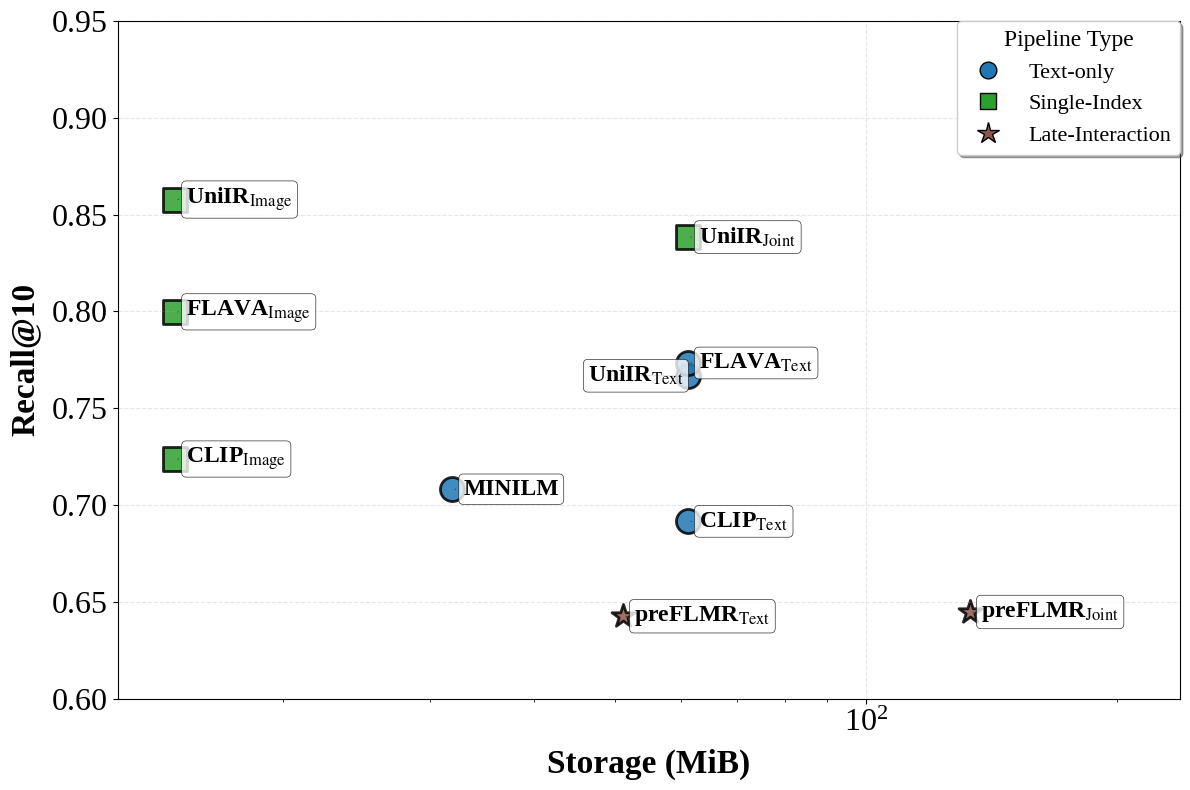

Saved: storage_vs_recall_coco_labeled.png


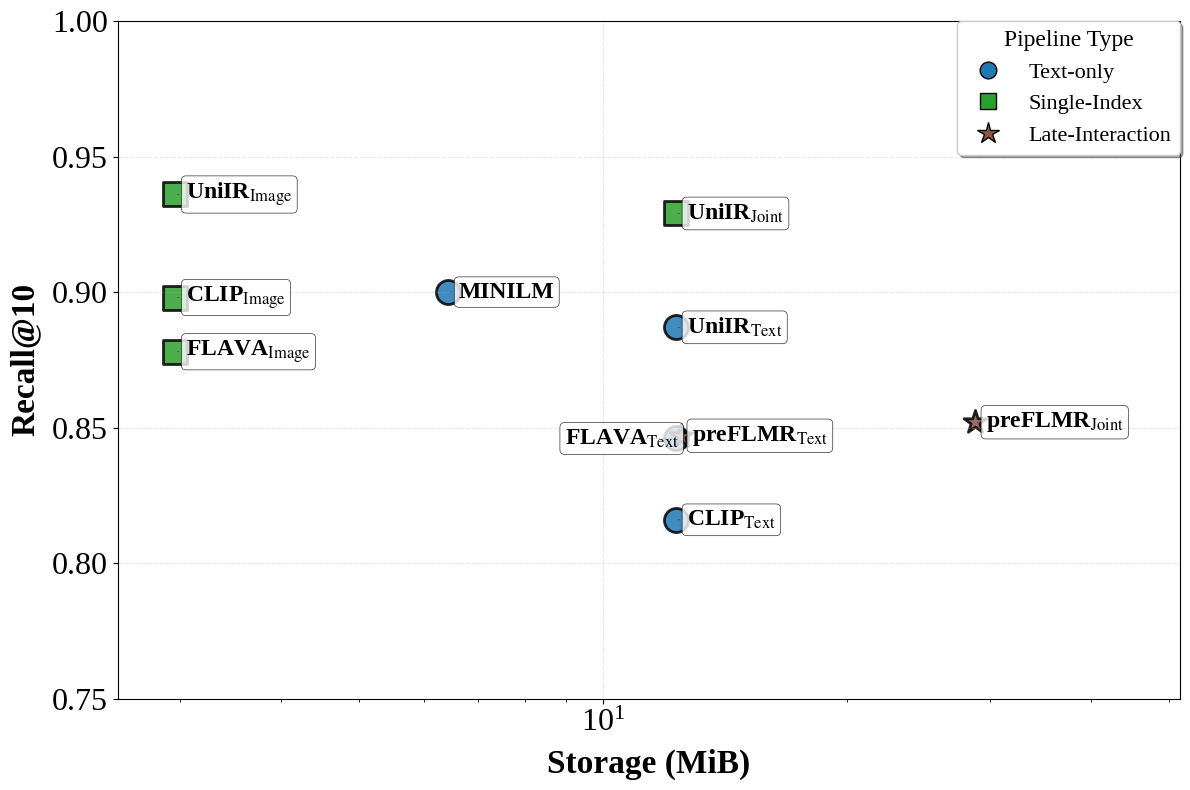

Saved: storage_vs_recall_flickr_labeled.png

SUMMARY STATISTICS - COCO (R@10)

📊 Text-only (4 point(s)):
    Storage (MiB): 31.93 - 61.23
    Recall@10:     0.6916 - 0.7734
    Models:
      - MINILM
      - UniIR_Text
      - CLIP_Text
      - FLAVA_Text

📊 Single-Index (4 point(s)):
    Storage (MiB): 14.85 - 61.23
    Recall@10:     0.7238 - 0.8578
    Models:
      - UniIR_Image
      - CLIP_Image
      - FLAVA_Image
      - UniIR_Joint

📊 Late-Interaction (2 point(s)):
    Storage (MiB): 51.17 - 133.46
    Recall@10:     0.6426 - 0.6448
    Models:
      - preFLMR_Text
      - preFLMR_Joint

Totals:
    Total COCO points: 10

SUMMARY STATISTICS - Flickr (R@10)

📊 Text-only (4 point(s)):
    Storage (MiB): 6.43 - 12.29
    Recall@10:     0.8160 - 0.9000
    Models:
      - MINILM
      - UniIR_Text
      - CLIP_Text
      - FLAVA_Text

📊 Single-Index (4 point(s)):
    Storage (MiB): 2.96 - 12.29
    Recall@10:     0.8780 - 0.9360
    Models:
      - UniIR_Image
      - CLIP_Image
 

In [9]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np  # for spiral label placement math & ticks
import re

# ========== Font sizing controls (axes/ticks only) ==========
AXIS_LABEL_FONTSIZE = 24
TICK_LABEL_FONTSIZE = 23
TITLE_FONTSIZE = 25
LEGEND_FONTSIZE = 16
LEGEND_TITLE_FONTSIZE = 17
ANNOT_FONTSIZE = 17

# ---------- modality→subscript formatter ----------
_SUB_RE = re.compile(r'([A-Za-z0-9]+)_([A-Za-z0-9]+)')
def fmt_modality(name: str) -> str:
    """
    Convert tokens like 'UniIR_Text' -> 'UniIR$_{\\mathrm{Text}}$'
    Works inside chains, parentheses, etc.
    """
    return _SUB_RE.sub(lambda m: f"{m.group(1)}$_{{\\mathrm{{{m.group(2)}}}}}$", name)

# ============================================================
# 1) Recall data  (name, dataset, recall_r10, _unused, pipeline_type, marker_type)
#    — the 4th value is unused here; we plot Storage vs Recall@10
# ============================================================
recall_data = [
    # COCO - Text-only
    ("MINILM", "COCO", 0.7082, 0.029935, "Text-only", "circle"),
    ("UniIR_Text", "COCO", 0.7668, 0.041275, "Text-only", "circle"),
    ("CLIP_Text", "COCO", 0.6916, 0.042034, "Text-only", "circle"),
    ("FLAVA_Text", "COCO", 0.7734, 0.042460, "Text-only", "circle"),

    # COCO - Single-Index
    ("UniIR_Image", "COCO", 0.8578, 0.0260013, "Single-Index", "square"),
    ("CLIP_Image", "COCO", 0.7238, 0.026881, "Single-Index", "square"),
    ("FLAVA_Image", "COCO", 0.7998, 0.027210, "Single-Index", "square"),
    ("UniIR_Joint", "COCO", 0.8384, 0.041576, "Single-Index", "square"),

    # COCO - Retrieve-and-Rerank → UniIR_Joint (no BLIP-2)
    ("UniIR_Image→UniIR_Joint", "COCO", 0.8382, 0.034189, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint", "COCO", 0.8200, 0.034812, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "COCO", 0.8360, 0.035594, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "COCO", 0.8304, 0.049600, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Text→UniIR_Joint", "COCO", 0.8276, 0.050398, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # COCO - Retrieve-and-Rerank → BLIP-2
    ("UniIR_Image→BLIP-2", "COCO", 0.8578, 0.554640, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→BLIP-2", "COCO", 0.7998, 0.556091, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "COCO", 0.7668, 0.571018, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "COCO", 0.8384, 0.572662, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→BLIP-2", "COCO", 0.7728, 0.573004, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # COCO - Retrieve-and-Rerank → UniIR_Joint → BLIP-2
    ("CLIP_Image→UniIR_Joint→BLIP-2", "COCO", 0.8200, 0.562469, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→UniIR_Joint→BLIP-2", "COCO", 0.8360, 0.564600, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→UniIR_Joint→BLIP-2", "COCO", 0.8382, 0.570765, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→UniIR_Joint→BLIP-2", "COCO", 0.8276, 0.578169, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→UniIR_Joint→BLIP-2", "COCO", 0.8304, 0.579810, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # COCO - Ensemble (RRF)
    ("(UniIR_Image, UniIR_Joint)", "COCO", 0.8816, 0.079296, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)",  "COCO", 0.8532, 0.079693, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "COCO", 0.8764, 0.080066, "Ensemble", "pentagon"),
    ("(UniIR_Text, UniIR_Joint)",  "COCO", 0.8450, 0.082520, "Ensemble", "pentagon"),
    ("(FLAVA_Text, UniIR_Joint)",  "COCO", 0.8590, 0.083135, "Ensemble", "pentagon"),

    # COCO - Late Interaction
    ("preFLMR_Text", "COCO", 0.6426, 0.032712, "Late-Interaction", "star"),
    ("preFLMR_Joint", "COCO", 0.6448, 0.033582, "Late-Interaction", "star"),

    # ---------- NEW: COCO - BM25 (R@10 and total latency provided)
    ("BM25_Text", "COCO", 0.5622, 0.01360, "BM25", "hexagon"),

    # Flickr - Text-only
    ("MINILM", "Flickr", 0.9000, 0.020586, "Text-only", "circle"),
    ("UniIR_Text", "Flickr", 0.8870, 0.023326, "Text-only", "circle"),
    ("CLIP_Text", "Flickr", 0.8160, 0.024509, "Text-only", "circle"),
    ("FLAVA_Text", "Flickr", 0.8460, 0.024991, "Text-only", "circle"),

    # Flickr - Single-Index
    ("UniIR_Image", "Flickr", 0.9360, 0.020462, "Single-Index", "square"),
    ("CLIP_Image", "Flickr", 0.8980, 0.021269, "Single-Index", "square"),
    ("FLAVA_Image", "Flickr", 0.8780, 0.021523, "Single-Index", "square"),
    ("UniIR_Joint", "Flickr", 0.9290, 0.024338, "Single-Index", "square"),

    # Flickr - Retrieve-and-Rerank → UniIR_Joint (no BLIP-2)
    ("MINILM→UniIR_Joint", "Flickr", 0.9260, 0.030526, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint", "Flickr", 0.9200, 0.031557, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "Flickr", 0.9290, 0.031800, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint", "Flickr", 0.9300, 0.031807, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "Flickr", 0.9270, 0.032340, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # Flickr - Retrieve-and-Rerank → BLIP-2
    ("MINILM→BLIP-2", "Flickr", 0.9000, 0.532178, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→BLIP-2", "Flickr", 0.9360, 0.533093, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "Flickr", 0.8870, 0.533816, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "Flickr", 0.9290, 0.535330, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→BLIP-2", "Flickr", 0.8980, 0.537770, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # Flickr - Retrieve-and-Rerank → UniIR → BLIP-2
    ("MINILM→UniIR_Image→BLIP-2", "Flickr", 0.9530, 0.538228, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→UniIR_Joint→BLIP-2", "Flickr", 0.9440, 0.539769, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→UniIR_Joint→BLIP-2", "Flickr", 0.9200, 0.541981, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→FLAVA_Image→BLIP-2", "Flickr", 0.9340, 0.544663, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("MINILM→UniIR_Joint→BLIP-2", "Flickr", 0.9260, 0.581779, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # Flickr - Ensemble (RRF) — using R@10
    ("(UniIR_Image, UniIR_Joint)", "Flickr", 0.9580, 0.062990, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)",  "Flickr", 0.9490, 0.063460, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "Flickr", 0.9440, 0.063764, "Ensemble", "pentagon"),
    ("(UniIR_Text, UniIR_Joint)",  "Flickr", 0.9300, 0.065280, "Ensemble", "pentagon"),
    ("(MINILM, UniIR_Joint)",      "Flickr", 0.9430, 0.066417, "Ensemble", "pentagon"),

    # Flickr - Late Interaction
    ("preFLMR_Text", "Flickr", 0.8470, 0.031436, "Late-Interaction", "star"),
    ("preFLMR_Joint", "Flickr", 0.8520, 0.033128, "Late-Interaction", "star"),

    # ---------- NEW: Flickr - BM25 (R@10 and total latency provided)
    ("BM25_Text", "Flickr", 0.7440, 0.00982, "BM25", "hexagon"),
]

# ============================================================
# 2) Storage lookup (MiB, "Total")
# (BM25 storage not provided—BM25 points will be skipped until added here.)
# ============================================================
storage_lookup = {
    # COCO: Text-only
    ("COCO", "MINILM"): 31.93,
    ("COCO", "CLIP_Text"): 61.23,
    ("COCO", "FLAVA_Text"): 61.23,
    ("COCO", "UniIR_Text"): 61.23,

    # COCO: Single-Index
    ("COCO", "CLIP_Image"): 14.85,
    ("COCO", "FLAVA_Image"): 14.85,
    ("COCO", "UniIR_Image"): 14.85,
    ("COCO", "UniIR_Joint"): 61.23,
    ("COCO", "UniIR_JointImgText"): 61.23,

    # COCO: Late-Interaction (PreFLMR)
    ("COCO", "preFLMR_Text"): 51.17,
    ("COCO", "preFLMR_Joint"): 133.46,

    # Flickr: Text-only
    ("Flickr", "MINILM"): 6.43,
    ("Flickr", "CLIP_Text"): 12.29,
    ("Flickr", "FLAVA_Text"): 12.29,
    ("Flickr", "UniIR_Text"): 12.29,

    # Flickr: Single-Index
    ("Flickr", "CLIP_Image"): 2.96,
    ("Flickr", "FLAVA_Image"): 2.96,
    ("Flickr", "UniIR_Image"): 2.96,
    ("Flickr", "UniIR_Joint"): 12.29,
    ("Flickr", "UniIR_JointImgText"): 12.29,

    # Flickr: Late-Interaction (PreFLMR)
    ("Flickr", "preFLMR_Text"): 12.46,
    ("Flickr", "preFLMR_Joint"): 28.75,
}

# ============================================================
# 3) Merge recall with storage (keep points that have storage)
#    -> (name, dataset, storage_mib, recall_r10, pipeline_type, marker_type)
# ============================================================
merged_points = []
for (name, dataset, recall_r10, _unused, pipeline_type, marker_type) in recall_data:
    key = (dataset, name)  # raw name for lookup
    if key in storage_lookup:
        merged_points.append((name, dataset, storage_lookup[key], recall_r10, pipeline_type, marker_type))

coco_points   = [p for p in merged_points if p[1] == "COCO"]
flickr_points = [p for p in merged_points if p[1] == "Flickr"]

# ============================================================
# 4) Plot styles + helpers (legend, smart labels, axis clamps)
# ============================================================
pipeline_colors = {
    "Text-only": "#1f77b4",
    "Single-Index": "#2ca02c",
    "Late-Interaction": "#8c564b",
    "Retrieve-and-Rerank without BLIP-2": "#ff7f0e",
    "Retrieve-and-Rerank with BLIP-2": "#d62728",
    "Ensemble": "#9467bd",
    "BM25": "#17becf",   # will appear if BM25 gets storage
}
marker_styles = {
    "circle": "o",
    "square": "s",
    "triangle": "^",
    "diamond": "D",
    "pentagon": "p",
    "star": "*",
    "hexagon": "h",
}

def place_labels_no_overlap(ax, fig, items, pad_px=2):
    """
    Greedy spiral-ish search to place labels w/o overlapping.
    items: list of (label, x_val, y_val, color, marker)
    """
    from matplotlib.transforms import Bbox
    placed_bboxes = []
    annotations = []
    items_sorted = sorted(items, key=lambda t: (-t[2], t[1]))  # high y first
    radii  = list(range(8, 201, 4))
    angles = list(range(0, 360, 15))

    for (label, x_pt, y_pt, color, marker) in items_sorted:
        chosen = None
        for r in radii:
            for a in angles:
                dx = r * np.cos(np.deg2rad(a))
                dy = r * np.sin(np.deg2rad(a))
                trial = ax.annotate(
                    label, xy=(x_pt, y_pt), xytext=(dx, dy), textcoords="offset points",
                    fontsize=ANNOT_FONTSIZE, fontweight="bold", ha="left", va="center",
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", linewidth=0.5, alpha=0.8),
                    arrowprops=dict(arrowstyle='-', color='black', linewidth=0.6, alpha=0.7),
                )
                fig.canvas.draw()
                bb = trial.get_window_extent(renderer=fig.canvas.get_renderer())
                bb = Bbox.from_extents(bb.x0 - pad_px, bb.y0 - pad_px, bb.x1 + pad_px, bb.y1 + pad_px)
                if any(bb.overlaps(prev) for prev in placed_bboxes):
                    trial.remove()
                else:
                    placed_bboxes.append(bb)
                    annotations.append(trial)
                    chosen = trial
                    break
            if chosen:
                break

        # guaranteed fallback if everything overlaps
        if chosen is None:
            dx, dy = 220, 0
            fallback = ax.annotate(
                label, xy=(x_pt, y_pt), xytext=(dx, dy), textcoords="offset points",
                fontsize=ANNOT_FONTSIZE, fontweight="bold", ha="left", va="center",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", linewidth=0.5, alpha=0.8),
                arrowprops=dict(arrowstyle='-', color='black', linewidth=0.6, alpha=0.7),
            )
            fig.canvas.draw()
            placed_bboxes.append(fallback.get_window_extent(renderer=fig.canvas.get_renderer()))
            annotations.append(fallback)
    return annotations

def set_y_limits_clamped(ax, y_vals, pad_low=0.03, pad_high=0.08, tick_step=0.05):
    """
    Clamp recall-style axis to [0, 1] with a little headroom for labels,
    and set nice 0.05-spaced ticks.
    """
    y_min = max(0.0, min(y_vals) - pad_low)
    y_max = min(0.999, max(y_vals) + pad_high)

    # round to nearest tick_step boundaries
    lo = max(0.0, np.floor(y_min / tick_step) * tick_step)
    hi = min(1.0, np.ceil(y_max / tick_step) * tick_step)

    ax.set_ylim(lo, hi)
    ax.set_yticks(np.arange(lo, hi + 1e-9, tick_step))
    ax.set_yticklabels([f"{t:.2f}" for t in ax.get_yticks()])

def expand_limits_after_labels(ax, x_expand_hi=1.6, y_expand_hi=1.0, x_expand_lo=1.05, y_expand_lo=1.0):
    """
    Only expand X to leave room for labels on the right; keep Y as already clamped.
    """
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    ax.set_xlim(xmin / x_expand_lo, xmax * x_expand_hi)
    # y-limits unchanged (clamped by set_y_limits_clamped)

def legend_for(ax, active_types, type_to_marker):
    handles = [
        Line2D([0],[0],
               marker=type_to_marker[t], color="w",
               markerfacecolor=pipeline_colors[t], markeredgecolor="black",
               markersize=12 if type_to_marker[t] != "*" else 16,
               linewidth=2, label=t)
        for t in active_types
    ]
    ax.legend(handles=handles, loc="upper right", #bbox_to_anchor=(1.02, 1.00),
              borderaxespad=0., frameon=True, shadow=True,
              title="Pipeline Type", title_fontsize=LEGEND_TITLE_FONTSIZE,
              fontsize=LEGEND_FONTSIZE)

# ============================================================
# 5) Scatter + labels
# ============================================================
def make_plot(points, title, outfile):
    """
    points: (name, dataset, storage_mib, recall_r10, pipeline_type, marker_type)
    """
    fig, ax = plt.subplots(figsize=(12, 8))

    active_types = []
    type_to_marker = {}
    label_targets = []
    y_vals = []

    for (name, dataset, storage_mib, recall_r10, pipeline_type, marker_type) in points:
        if pipeline_type not in active_types:
            active_types.append(pipeline_type)
            type_to_marker[pipeline_type] = marker_styles[marker_type]

        ax.scatter(
            storage_mib, recall_r10, s=300, alpha=0.85,
            color=pipeline_colors[pipeline_type],
            marker=marker_styles[marker_type],
            edgecolors="black", linewidth=2
        )

        # queue for overlap-free placement (formatted with subscripts)
        label_targets.append((
            fmt_modality(name), storage_mib, recall_r10,
            pipeline_colors[pipeline_type], marker_styles[marker_type]
        ))
        y_vals.append(recall_r10)

    # Axes styles — log on X (storage), linear on Y (recall)
    ax.set_xscale("log")
    ax.grid(True, alpha=0.3, linestyle="--")

    # labels/titles
    ax.set_xlabel("Storage (MiB)", fontsize=AXIS_LABEL_FONTSIZE, fontweight="bold", labelpad=8)
    ax.set_ylabel("Recall@10", fontsize=AXIS_LABEL_FONTSIZE, fontweight="bold", labelpad=8)
    # ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight="bold", pad=18)
    ax.tick_params(axis="both", which="both", labelsize=TICK_LABEL_FONTSIZE)

    # Clamp y to ≤ 1.0 with clean ticks, then place labels
    set_y_limits_clamped(ax, y_vals, pad_low=0.03, pad_high=0.08, tick_step=0.05)
    place_labels_no_overlap(ax, fig, label_targets, pad_px=2)

    # Expand only X to make room for labels; keep Y clamped
    expand_limits_after_labels(ax, x_expand_hi=1.6, y_expand_hi=1.0, x_expand_lo=1.05, y_expand_lo=1.0)

    # side legend
    legend_for(ax, active_types, type_to_marker)

    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {outfile}")

# ============================================================
# 6) Generate plots
# ============================================================
make_plot(coco_points,   title="COCO: Storage vs Recall@10",   outfile="storage_vs_recall_coco_labeled.png")
make_plot(flickr_points, title="Flickr: Storage vs Recall@10", outfile="storage_vs_recall_flickr_labeled.png")

# ============================================================
# 7) Summary (prints raw names)
# ============================================================
def print_summary(points, dataset_name):
    print("\n" + "="*70)
    print(f"SUMMARY STATISTICS - {dataset_name} (R@10)")
    print("="*70)

    by_type = {}
    for (name, dataset, storage_mib, recall_r10, pipeline_type, marker_type) in points:
        by_type.setdefault(pipeline_type, []).append((storage_mib, recall_r10, name))

    for ptype, vals in by_type.items():
        storages = [v[0] for v in vals]
        recalls  = [v[1] for v in vals]
        print(f"\n📊 {ptype} ({len(vals)} point(s)):")
        print(f"    Storage (MiB): {min(storages):.2f} - {max(storages):.2f}")
        print(f"    Recall@10:     {min(recalls):.4f} - {max(recalls):.4f}")
        print("    Models:")
        for (_s, _r, model_name) in vals:
            print(f"      - {model_name}")

    print("\nTotals:")
    print(f"    Total {dataset_name} points: {len(points)}")
    print("="*70)

print_summary(coco_points, "COCO")
print_summary(flickr_points, "Flickr")


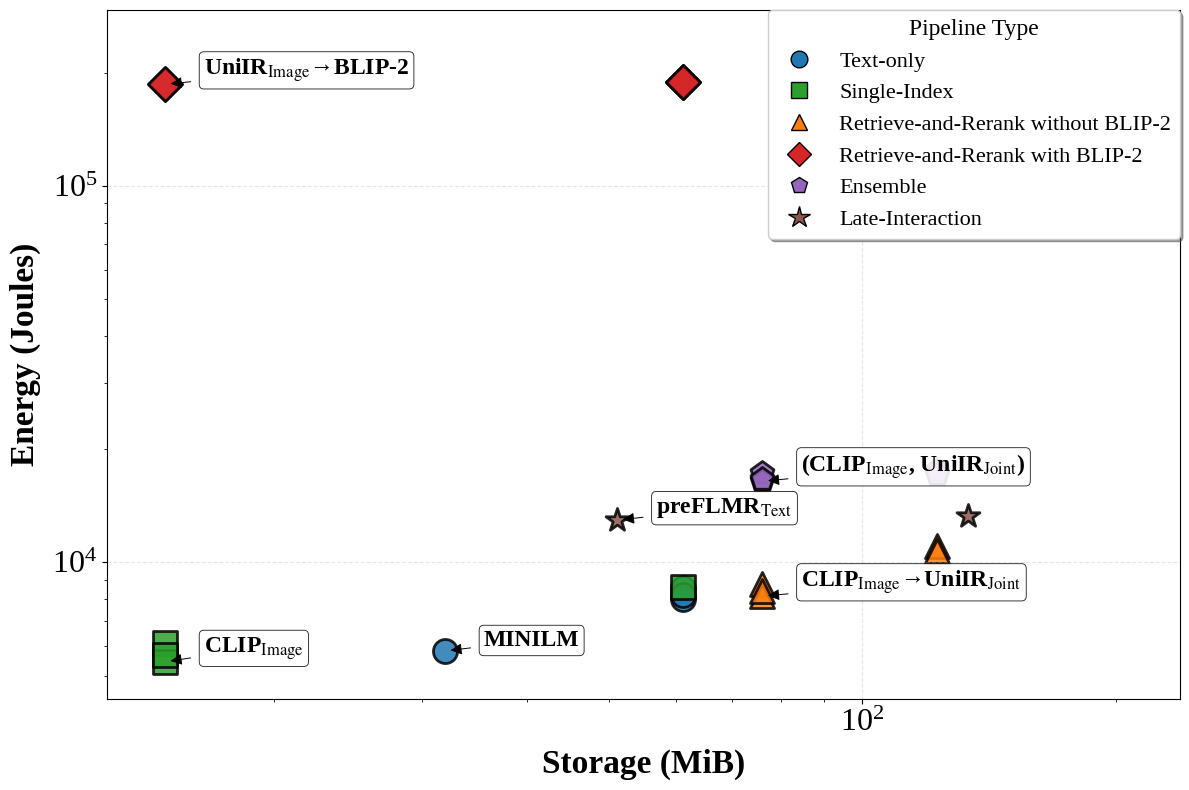

Saved: storage_vs_energy_coco_labeled.png


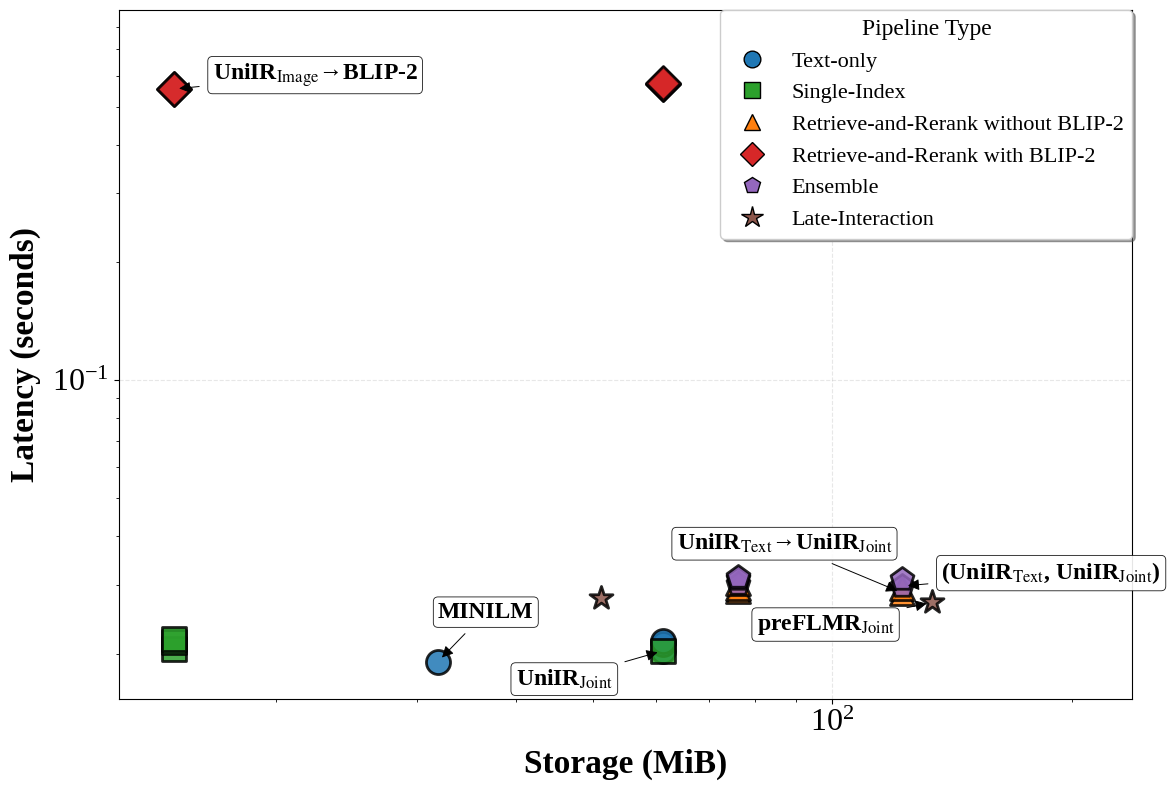

Saved: storage_vs_latency_coco_labeled.png


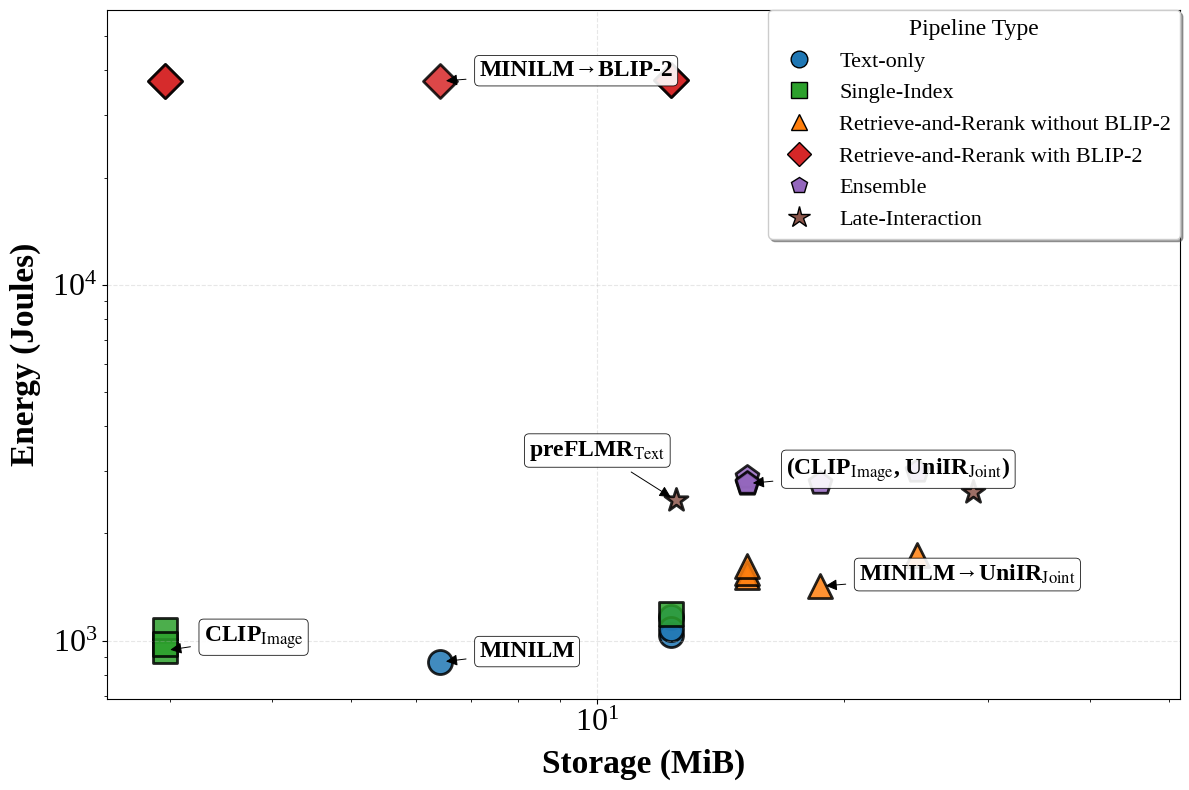

Saved: storage_vs_energy_flickr_labeled.png


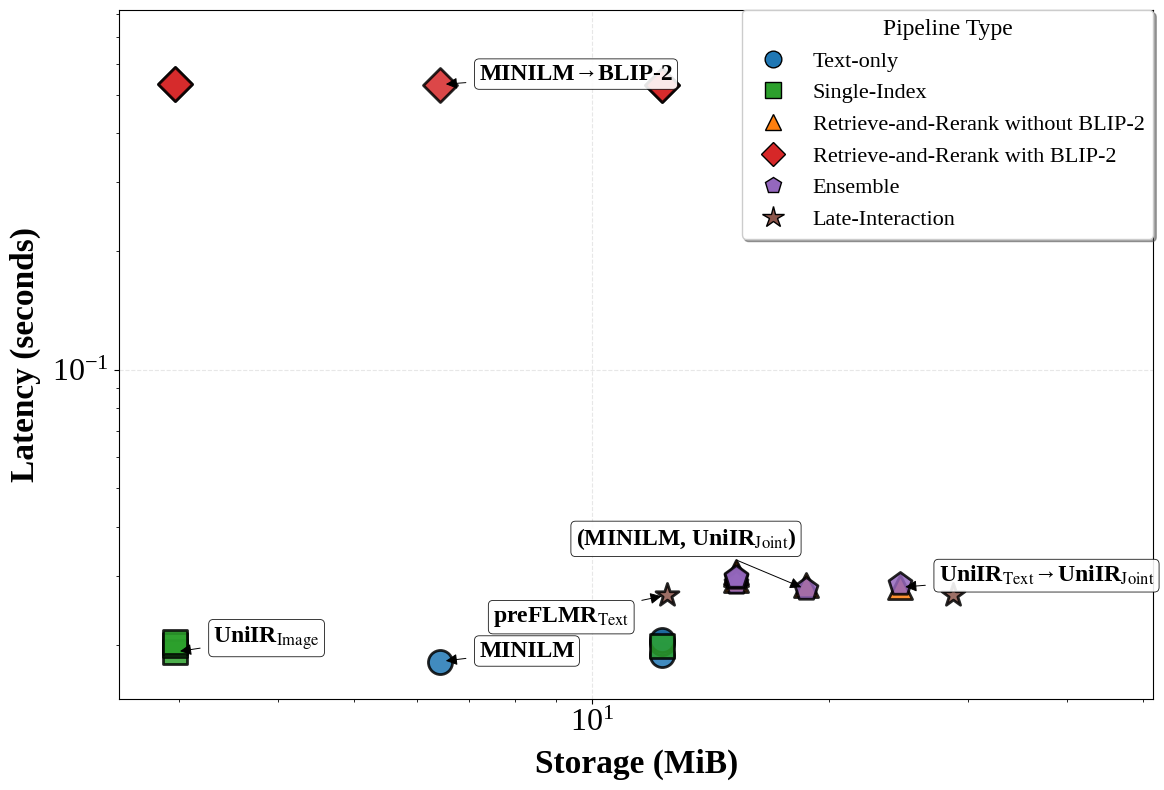

Saved: storage_vs_latency_flickr_labeled.png


In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np  # spiral math
import re

# ========== Font sizing controls ==========
AXIS_LABEL_FONTSIZE = 24
TICK_LABEL_FONTSIZE = 23
TITLE_FONTSIZE = 25
LEGEND_FONTSIZE = 16
LEGEND_TITLE_FONTSIZE = 17
ANNOT_FONTSIZE = 17

# ---------- modality→subscript formatter ----------
_SUB_RE = re.compile(r'([A-Za-z0-9]+)_([A-Za-z0-9]+)')
def fmt_modality(name: str) -> str:
    """'UniIR_Text' -> 'UniIR$_{\\mathrm{Text}}$'"""
    return _SUB_RE.sub(lambda m: f"{m.group(1)}$_{{\\mathrm{{{m.group(2)}}}}}$", name)

# ============================================================
# 1) Data  (name, dataset, ENERGY[J], LATENCY[s], pipeline_type, marker)
# ============================================================
data = [
    # COCO - Text-only
    ("MINILM", "COCO", 5811.429, 0.019094, "Text-only", "circle"),
    ("UniIR_Text", "COCO", 8558.791, 0.020292, "Text-only", "circle"),
    ("CLIP_Text", "COCO", 7966.375, 0.021109, "Text-only", "circle"),
    ("FLAVA_Text", "COCO", 8192.518, 0.02161,  "Text-only", "circle"),

    # COCO - Single-Index
    ("UniIR_Image", "COCO", 6096.318, 0.02058,  "Single-Index", "square"),
    ("CLIP_Image",  "COCO", 5440.233, 0.02147,  "Single-Index", "square"),
    ("FLAVA_Image", "COCO", 5671.572, 0.02180,  "Single-Index", "square"),
    ("UniIR_Joint", "COCO", 8610.995, 0.020339, "Single-Index", "square"),

    # COCO - Retrieve-and-Rerank → UniIR_Joint (no BLIP-2)
    ("UniIR_Image→UniIR_Joint", "COCO", 8731.663, 0.028836, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint",  "COCO", 8126.193, 0.029465, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "COCO", 8371.911, 0.030241, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint",  "COCO", 11040.448, 0.028592, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Text→UniIR_Joint",  "COCO", 10726.097, 0.02942,  "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # COCO - Retrieve-and-Rerank → BLIP-2
    ("UniIR_Image→BLIP-2", "COCO", 186549.050, 0.554640, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→BLIP-2", "COCO", 186615.231, 0.556091, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2",  "COCO", 189141.903, 0.571018, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "COCO", 189307.593, 0.572662, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→BLIP-2",  "COCO", 189222.290, 0.573004, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # COCO - Ensemble (RRF)  *** UPDATED ENERGIES (J) ***
    ("(UniIR_Image, UniIR_Joint)", "COCO", 17239.507,  0.030219, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)",  "COCO", 16426.7665, 0.031090, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "COCO", 16605.247,  0.031480, "Ensemble", "pentagon"),
    ("(UniIR_Text, UniIR_Joint)",  "COCO", 17628.148,  0.029770, "Ensemble", "pentagon"),
    ("(FLAVA_Text, UniIR_Joint)",  "COCO", 17165.479,  0.030950, "Ensemble", "pentagon"),

    # COCO - Late Interaction
    ("preFLMR_Text",  "COCO", 12944.118, 0.02772, "Late-Interaction", "star"),
    ("preFLMR_Joint", "COCO", 13292.001, 0.02703, "Late-Interaction", "star"),

    # Flickr - Text-only
    ("MINILM",     "Flickr",  870.461, 0.01818,  "Text-only", "circle"),
    ("UniIR_Text", "Flickr", 1164.629, 0.01891,  "Text-only", "circle"),
    ("CLIP_Text",  "Flickr", 1039.328, 0.020210, "Text-only", "circle"),
    ("FLAVA_Text", "Flickr", 1080.792, 0.02061,  "Text-only", "circle"),

    # Flickr - Single-Index
    ("UniIR_Image", "Flickr", 1074.525, 0.019216, "Single-Index", "square"),
    ("CLIP_Image",  "Flickr",  937.406, 0.020030, "Single-Index", "square"),
    ("FLAVA_Image", "Flickr",  975.371, 0.020330, "Single-Index", "square"),
    ("UniIR_Joint", "Flickr", 1189.419, 0.019853, "Single-Index", "square"),

    # Flickr - Retrieve-and-Rerank → UniIR_Joint (no BLIP-2)
    ("MINILM→UniIR_Joint",     "Flickr", 1422.089, 0.028369, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint", "Flickr", 1509.416, 0.030409, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint","Flickr", 1544.724, 0.030661, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint","Flickr", 1624.571, 0.029364, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "Flickr", 1745.200, 0.028055, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # Flickr - Retrieve-and-Rerank → BLIP-2
    ("MINILM→BLIP-2",      "Flickr", 37289.005, 0.530582, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→BLIP-2",  "Flickr", 37359.645, 0.531725, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2",   "Flickr", 37662.098, 0.530680, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2",  "Flickr", 37509.338, 0.530630, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→BLIP-2",   "Flickr", 37413.210, 0.533190, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # Flickr - Ensemble (RRF) — using R@10  *** UPDATED ENERGIES (J) ***
    ("(UniIR_Image, UniIR_Joint)", "Flickr", 2886.028,  0.028742,  "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)",  "Flickr", 2760.984,  0.029614,  "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "Flickr", 2779.996,  0.0298564, "Ensemble", "pentagon"),
    ("(UniIR_Text, UniIR_Joint)",  "Flickr", 2990.843,  0.0285869, "Ensemble", "pentagon"),
    ("(MINILM, UniIR_Joint)",      "Flickr", 2765.645,  0.0277139, "Ensemble", "pentagon"),

    # Flickr - Late Interaction
    ("preFLMR_Text",  "Flickr", 2482.026, 0.026807, "Late-Interaction", "star"),
    ("preFLMR_Joint", "Flickr", 2619.403, 0.026860, "Late-Interaction", "star"),
]


# ============================================================
# 2) Storage lookup (MiB) — base models only
# ============================================================
storage_lookup = {
    # COCO : Text-only
    ("COCO", "MINILM"): 31.93,
    ("COCO", "CLIP_Text"): 61.23,
    ("COCO", "FLAVA_Text"): 61.23,
    ("COCO", "UniIR_Text"): 61.23,

    # COCO : Single-Index
    ("COCO", "CLIP_Image"): 14.85,
    ("COCO", "FLAVA_Image"): 14.85,
    ("COCO", "UniIR_Image"): 14.85,
    ("COCO", "UniIR_Joint"): 61.23,
    ("COCO", "UniIR_JointImgText"): 61.23,   # alias if you ever use it

    # COCO : Late-Interaction (PreFLMR)
    ("COCO", "preFLMR_Text"): 51.17,
    ("COCO", "preFLMR_Joint"): 133.46,

    # Flickr : Text-only
    ("Flickr", "MINILM"): 6.43,
    ("Flickr", "CLIP_Text"): 12.29,
    ("Flickr", "FLAVA_Text"): 12.29,
    ("Flickr", "UniIR_Text"): 12.29,

    # Flickr : Single-Index
    ("Flickr", "CLIP_Image"): 2.96,
    ("Flickr", "FLAVA_Image"): 2.96,
    ("Flickr", "UniIR_Image"): 2.96,
    ("Flickr", "UniIR_Joint"): 12.29,
    ("Flickr", "UniIR_JointImgText"): 12.29,  # alias

    # Flickr : Late-Interaction (PreFLMR)
    ("Flickr", "preFLMR_Text"): 12.46,
    ("Flickr", "preFLMR_Joint"): 28.75,
}

# ---------- Composite storage (copied/replicated from your recall script) ----------
BLIP2_STORAGE_MIB = 0.0  # treat BLIP-2 as stateless reranker

def model_storage(dataset: str, model_name: str):
    return storage_lookup.get((dataset, model_name), None)

def combo_storage(dataset: str, name: str):
    """Sum storage for A→B combos and (A, B) ensembles; skip 3-stage chains."""
    if "→" in name:
        parts = [p.strip() for p in name.split("→")]
        if len(parts) >= 3:  # skip 3-stage for storage summation
            return None
        a, b = parts
        if b == "BLIP-2":
            sa = model_storage(dataset, a)
            return None if sa is None else sa + BLIP2_STORAGE_MIB
        sa, sb = model_storage(dataset, a), model_storage(dataset, b)
        return None if (sa is None or sb is None) else sa + sb
    if name.startswith("(") and name.endswith(")"):  # ensembles "(A, B)"
        total = 0.0
        for c in [c.strip() for c in name[1:-1].split(",")]:
            sc = model_storage(dataset, c)
            if sc is None:
                return None
            total += sc
        return total
    return model_storage(dataset, name)

# ============================================================
# 3) Merge storage with energy/latency using composite rules
# ============================================================
merged_points, skipped = [], []
for (name, dataset, energy, latency, ptype, marker) in data:
    s = combo_storage(dataset, name)
    if s is None:
        skipped.append((dataset, name))
    else:
        merged_points.append((name, dataset, s, energy, latency, ptype, marker))

coco_points   = [p for p in merged_points if p[1] == "COCO"]
flickr_points = [p for p in merged_points if p[1] == "Flickr"]

# ============================================================
# 4) Plot styling + selectors
# ============================================================
pipeline_colors = {
    "Text-only": "#1f77b4",
    "Single-Index": "#2ca02c",
    "Late-Interaction": "#8c564b",
    "Retrieve-and-Rerank without BLIP-2": "#ff7f0e",
    "Retrieve-and-Rerank with BLIP-2": "#d62728",
    "Ensemble": "#9467bd",
}
marker_styles = {"circle":"o","square":"s","triangle":"^","diamond":"D","pentagon":"p","star":"*"}

# Manual label nudges (optional; used if the point gets labeled)
CUSTOM_OFFSETS_COCO = {
    ("COCO", "UniIR_Joint"): (-36, -12),
}
CUSTOM_OFFSETS_FLICKR = {
    ("Flickr", "preFLMR_Joint"): (40, -40),
}

MIN_LABEL_RADIUS_PX = 28

def place_labels_no_overlap(ax, fig, items, pad_px=2, custom_offsets=None):
    """Greedy, collision-safe label placement with spiral search."""
    from matplotlib.transforms import Bbox
    placed_bboxes, annotations = [], []

    # denser points first (sort by y desc, then x asc)
    items_sorted = sorted(items, key=lambda t: (-t[4], t[3]))

    radii  = list(range(MIN_LABEL_RADIUS_PX, 220, 4))
    angles = list(range(0, 360, 15))

    for (dataset, raw_name, label, x_pt, y_pt, color, marker) in items_sorted:
        tried = []
        if custom_offsets and (dataset, raw_name) in custom_offsets:
            tried.append(custom_offsets[(dataset, raw_name)])
        for r in radii:
            for a in angles:
                tried.append((r*np.cos(np.deg2rad(a)), r*np.sin(np.deg2rad(a))))

        placed = False
        for (dx, dy) in tried:
            ann = ax.annotate(
                label, xy=(x_pt, y_pt), xytext=(dx, dy), textcoords="offset points",
                fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx >= 0 else "right",
                va="bottom" if dy >= 0 else "top",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", linewidth=0.6, alpha=0.9),
                arrowprops=dict(arrowstyle="-|>", color="black", linewidth=0.7,
                                shrinkA=6, shrinkB=4),
                clip_on=False, zorder=5
            )
            fig.canvas.draw()
            bb = ann.get_window_extent(renderer=fig.canvas.get_renderer())
            bb = Bbox.from_extents(bb.x0 - pad_px, bb.y0 - pad_px, bb.x1 + pad_px, bb.y1 + pad_px)

            if any(bb.overlaps(prev) for prev in placed_bboxes):
                ann.remove()
            else:
                placed_bboxes.append(bb)
                annotations.append(ann)
                placed = True
                break
        if not placed:
            pass
    return annotations

def expand_limits_after_labels(ax, x_expand_hi=1.6, y_expand_hi=1.3, x_expand_lo=1.05, y_expand_lo=1.05):
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    ax.set_xlim(xmin / x_expand_lo, xmax * x_expand_hi)
    ax.set_ylim(ymin / y_expand_lo, ymax * y_expand_hi)

def legend_for(ax, active_types, type_to_marker):
    handles = [
        Line2D([0],[0],
               marker=type_to_marker[t], color="w",
               markerfacecolor=pipeline_colors[t], markeredgecolor="black",
               markersize=12 if type_to_marker[t] != "*" else 16,
               linewidth=2, label=t)
        for t in active_types
    ]
    ax.legend(handles=handles, loc="upper right",
              borderaxespad=0., frameon=True, shadow=True,
              title="Pipeline Type", title_fontsize=LEGEND_TITLE_FONTSIZE,
              fontsize=LEGEND_FONTSIZE)

# ---- Best-per-pipeline selector (for energy/latency: lower is better) ----
def select_best_per_pipeline(points, y_field):
    """
    points: (name, dataset, storage, energy, latency, type, marker)
    returns list of best points (min y_value) per pipeline type;
    tie-breaker = lower storage.
    """
    idx = 3 if y_field == "energy" else 4  # column for y-value
    by_type = {}
    for p in points:
        by_type.setdefault(p[5], []).append(p)
    chosen = []
    for ptype, lst in by_type.items():
        best = min(lst, key=lambda x: (x[idx], x[2]))  # (y, storage)
        chosen.append(best)
    return chosen

# ============================================================
# 5) Scatter + label only BEST per pipeline
# ============================================================
def make_plot(points, y_field, title, outfile):
    """
    points: (name, dataset, storage_mib, energy, latency, pipeline_type, marker)
    y_field: "energy" or "latency"
    """
    fig, ax = plt.subplots(figsize=(12, 8))

    active_types, type_to_marker, label_targets = [], {}, []

    for (name, dataset, storage_mib, energy, latency, ptype, marker) in points:
        if ptype not in active_types:
            active_types.append(ptype)
            type_to_marker[ptype] = marker_styles[marker]
        y_val = energy if y_field == "energy" else latency
        ax.scatter(storage_mib, y_val, s=300, alpha=0.85,
                   color=pipeline_colors[ptype],
                   marker=marker_styles[marker],
                   edgecolors="black", linewidth=2)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3, linestyle="--")
    ax.set_xlabel("Storage (MiB)", fontsize=AXIS_LABEL_FONTSIZE, fontweight="bold", labelpad=8)
    ax.set_ylabel("Energy (Joules)" if y_field == "energy" else "Latency (seconds)",
                  fontsize=AXIS_LABEL_FONTSIZE, fontweight="bold", labelpad=8)
    ax.tick_params(axis="both", which="both", labelsize=TICK_LABEL_FONTSIZE)
    # ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight="bold", pad=18)

    # --- build label list using BEST per pipeline ---
    best = select_best_per_pipeline(points, y_field)
    for (name, dataset, storage_mib, energy, latency, ptype, marker) in best:
        y_val = energy if y_field == "energy" else latency
        label_targets.append((
            dataset, name, fmt_modality(name), storage_mib, y_val,
            pipeline_colors[ptype], marker_styles[marker]
        ))

    # dataset-specific manual offsets
    custom = CUSTOM_OFFSETS_COCO if (len(points) and points[0][1] == "COCO") else CUSTOM_OFFSETS_FLICKR
    place_labels_no_overlap(ax, fig, label_targets, pad_px=2, custom_offsets=custom)

    expand_limits_after_labels(ax)
    legend_for(ax, active_types, type_to_marker)

    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {outfile}")

# ============================================================
# 6) Make plots
# ============================================================
make_plot(coco_points,   y_field="energy",  title="MSCOCO: Storage vs Energy",   outfile="storage_vs_energy_coco_labeled.png")
make_plot(coco_points,   y_field="latency", title="MSCOCO: Storage vs Latency",  outfile="storage_vs_latency_coco_labeled.png")
make_plot(flickr_points, y_field="energy",  title="Flickr: Storage vs Energy",   outfile="storage_vs_energy_flickr_labeled.png")
make_plot(flickr_points, y_field="latency", title="Flickr: Storage vs Latency",  outfile="storage_vs_latency_flickr_labeled.png")

# Optional: tell you what was skipped (e.g., 3-stage chains)
if skipped:
    print("\n[Info] Skipped entries (3-stage or missing component storage):")
    for ds, nm in skipped:
        print(f"  - {ds}: {nm}")


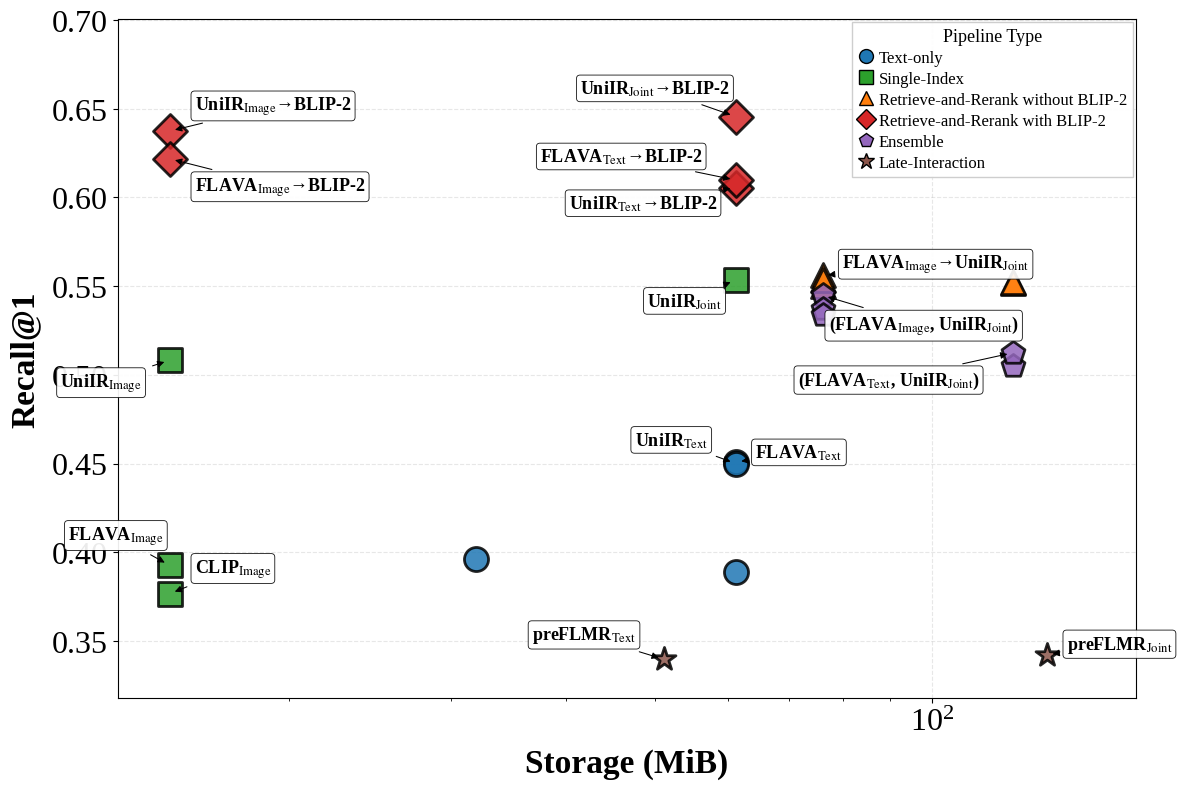

Saved: storage_vs_recall_coco.png


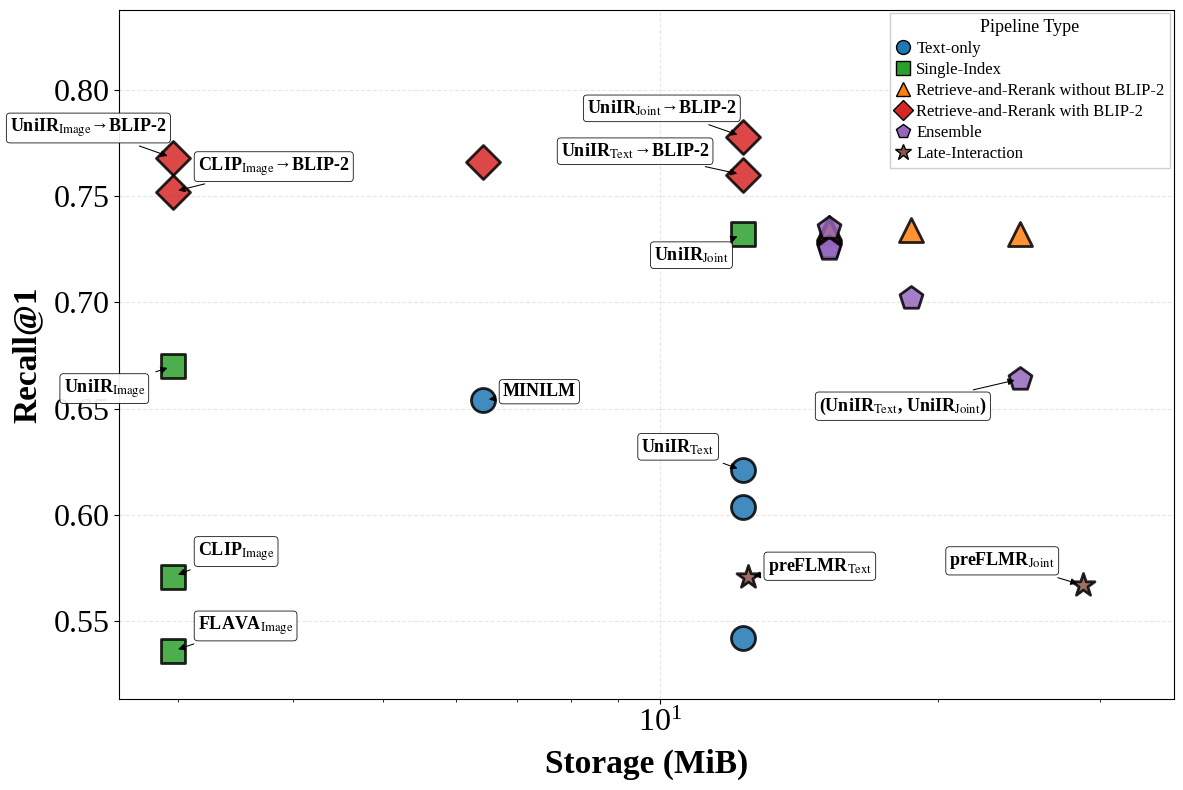

Saved: storage_vs_recall_flickr.png


In [11]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.transforms import Bbox
import numpy as np
import re

# ========== Font sizing controls (axes/ticks only) ==========
AXIS_LABEL_FONTSIZE = 24
TICK_LABEL_FONTSIZE = 23
TITLE_FONTSIZE = 25
LEGEND_FONTSIZE = 12
LEGEND_TITLE_FONTSIZE = 13
ANNOT_FONTSIZE = 13  # label font

# ---------- modality→subscript formatter ----------
_SUB_RE = re.compile(r'([A-Za-z0-9]+)_([A-Za-z0-9]+)')
def fmt_modality(name: str) -> str:
    return _SUB_RE.sub(lambda m: f"{m.group(1)}$_{{\\mathrm{{{m.group(2)}}}}}$", name)

# -------------------- DATA (Recall@1, Energy ignored here) --------------------
recall_data = [
    # -------- COCO: Text-only --------
    ("MINILM", "COCO", 0.3962, 5811.429, "Text-only", "circle"),
    ("CLIP_Text", "COCO", 0.3886, 7966.375, "Text-only", "circle"),
    ("FLAVA_Text", "COCO", 0.4508, 8192.518, "Text-only", "circle"),
    ("UniIR_Text", "COCO", 0.4500, 8558.791, "Text-only", "circle"),

    # -------- COCO: Single-Index --------
    ("CLIP_Image", "COCO", 0.3766, 5440.233, "Single-Index", "square"),
    ("FLAVA_Image", "COCO", 0.3926, 5671.572, "Single-Index", "square"),
    ("UniIR_Image", "COCO", 0.5082, 6096.318, "Single-Index", "square"),
    ("UniIR_Joint", "COCO", 0.5534, 8610.995, "Single-Index", "square"),

    # -------- COCO: Retrieve-and-Rerank without BLIP-2 --------
    ("CLIP_Image→UniIR_Joint", "COCO", 0.55,   8126.193, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "COCO", 0.556,  8371.911, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint", "COCO", 0.5532, 8731.663, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Text→UniIR_Joint",  "COCO", 0.5516, 10726.097, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint",  "COCO", 0.5522, 11040.448, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # -------- COCO: Retrieve-and-Rerank with BLIP-2 (two-stage only) --------
    ("UniIR_Image→BLIP-2", "COCO", 0.6374, 186549.050, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→BLIP-2", "COCO", 0.6218, 186615.231, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2",  "COCO", 0.6056, 189141.903, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→BLIP-2",  "COCO", 0.6098, 189222.290, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "COCO", 0.6456, 189307.593, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # -------- COCO: Ensemble --------
    ("(UniIR_Text, UniIR_Joint)",  "COCO", 0.5050, 90641.2095, "Ensemble", "pentagon"),
    ("(FLAVA_Text, UniIR_Joint)",  "COCO", 0.5124, 92778.6565, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "COCO", 0.5448, 105274.773, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)",  "COCO", 0.5370, 105455.913, "Ensemble", "pentagon"),
    ("(UniIR_Image, UniIR_Joint)", "COCO", 0.5336, 105677.2855, "Ensemble", "pentagon"),

    # -------- COCO: Late-Interaction (PreFLMR) --------
    ("preFLMR_Text", "COCO", 0.3396, 12944.118, "Late-Interaction", "star"),
    ("preFLMR_Joint", "COCO", 0.3422, 13292.001, "Late-Interaction", "star"),

    # -------- Flickr: Text-only --------
    ("MINILM", "Flickr", 0.6540, 870.461, "Text-only", "circle"),
    ("CLIP_Text", "Flickr", 0.5420, 1039.328, "Text-only", "circle"),
    ("FLAVA_Text", "Flickr", 0.6040, 1080.792, "Text-only", "circle"),
    ("UniIR_Text", "Flickr", 0.6210, 1164.629, "Text-only", "circle"),

    # -------- Flickr: Single-Index --------
    ("CLIP_Image", "Flickr", 0.5710, 937.406, "Single-Index", "square"),
    ("FLAVA_Image", "Flickr", 0.5360, 975.371, "Single-Index", "square"),
    ("UniIR_Image", "Flickr", 0.6700, 1074.525, "Single-Index", "square"),
    ("UniIR_Joint", "Flickr", 0.7320, 1189.419, "Single-Index", "square"),

    # -------- Flickr: Retrieve-and-Rerank without BLIP-2 --------
    ("MINILM→UniIR_Joint",   "Flickr", 0.734, 1422.089, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint","Flickr", 0.734, 1509.416, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint","Flickr", 0.735, 1544.724, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint","Flickr", 0.733, 1624.571, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "Flickr", 0.732, 1745.200, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # -------- Flickr: Retrieve-and-Rerank with BLIP-2 (two-stage only) --------
    ("MINILM→BLIP-2",     "Flickr", 0.7660, 37289.005, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→BLIP-2","Flickr", 0.7680, 37359.645, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→BLIP-2", "Flickr", 0.7520, 37413.210, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2","Flickr", 0.7780, 37509.338, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "Flickr", 0.7600, 37662.098, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # -------- Flickr: Ensemble --------
    ("(UniIR_Text, UniIR_Joint)",  "Flickr", 0.6640, 2525.118, "Ensemble", "pentagon"),
    ("(UniIR_Image, UniIR_Joint)", "Flickr", 0.7260, 3923.4045, "Ensemble", "pentagon"),
    ("(MINILM, UniIR_Joint)",      "Flickr", 0.7020, 2892.695, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)",  "Flickr", 0.7250, 2875.456, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "Flickr", 0.7350, 2916.763, "Ensemble", "pentagon"),

    # -------- Flickr: Late-Interaction (PreFLMR) --------
    ("preFLMR_Text", "Flickr", 0.5710, 2482.026, "Late-Interaction", "star"),
    ("preFLMR_Joint", "Flickr", 0.5670, 2619.403, "Late-Interaction", "star"),
]

# ============================================================
# Storage lookup (MiB)
# ============================================================
storage_lookup = {
    # COCO: Text-only
    ("COCO", "MINILM"): 31.93,
    ("COCO", "CLIP_Text"): 61.23,
    ("COCO", "FLAVA_Text"): 61.23,
    ("COCO", "UniIR_Text"): 61.23,
    # COCO: Single-Index
    ("COCO", "CLIP_Image"): 14.85,
    ("COCO", "FLAVA_Image"): 14.85,
    ("COCO", "UniIR_Image"): 14.85,
    ("COCO", "UniIR_Joint"): 61.23,
    # COCO: Late-Interaction
    ("COCO", "preFLMR_Text"): 51.17,
    ("COCO", "preFLMR_Joint"): 133.46,

    # Flickr: Text-only
    ("Flickr", "MINILM"): 6.43,
    ("Flickr", "CLIP_Text"): 12.29,
    ("Flickr", "FLAVA_Text"): 12.29,
    ("Flickr", "UniIR_Text"): 12.29,
    # Flickr: Single-Index
    ("Flickr", "CLIP_Image"): 2.96,
    ("Flickr", "FLAVA_Image"): 2.96,
    ("Flickr", "UniIR_Image"): 2.96,
    ("Flickr", "UniIR_Joint"): 12.29,
    # Flickr: Late-Interaction
    ("Flickr", "preFLMR_Text"): 12.46,
    ("Flickr", "preFLMR_Joint"): 28.75,
}

BLIP2_STORAGE_MIB = 0.0

def model_storage(dataset: str, model_name: str):
    return storage_lookup.get((dataset, model_name), None)

def combo_storage(dataset: str, name: str):
    if "→" in name:
        parts = [p.strip() for p in name.split("→")]
        if len(parts) >= 3:  # skip 3-stage
            return None
        a, b = parts
        if b == "BLIP-2":
            sa = model_storage(dataset, a)
            return None if sa is None else sa + BLIP2_STORAGE_MIB
        sa, sb = model_storage(dataset, a), model_storage(dataset, b)
        return None if (sa is None or sb is None) else sa + sb
    if name.startswith("(") and name.endswith(")"):
        total = 0.0
        for c in [c.strip() for c in name[1:-1].split(",")]:
            sc = model_storage(dataset, c)
            if sc is None: return None
            total += sc
        return total
    return model_storage(dataset, name)

# ---- merge storage with recall ----
merged_points, skipped = [], []
for (name, dataset, r1, _energy, ptype, m) in recall_data:
    s = combo_storage(dataset, name)
    if s is None: skipped.append((dataset, name))
    else: merged_points.append((name, dataset, s, r1, ptype, m))

coco_points   = [p for p in merged_points if p[1] == "COCO"]
flickr_points = [p for p in merged_points if p[1] == "Flickr"]

# ---- styles ----
pipeline_colors = {
    "Text-only": "#1f77b4",
    "Single-Index": "#2ca02c",
    "Late-Interaction": "#8c564b",
    "Retrieve-and-Rerank without BLIP-2": "#ff7f0e",
    "Retrieve-and-Rerank with BLIP-2": "#d62728",
    "Ensemble": "#9467bd",
}
marker_styles = {"circle":"o","square":"s","triangle":"^","diamond":"D","pentagon":"p","star":"*"}

def legend_for(ax, active_types, type_to_marker):
    handles = [
        Line2D([0],[0],
               marker=type_to_marker[t], color="w",
               markerfacecolor=pipeline_colors[t], markeredgecolor="black",
               markersize=10 if type_to_marker[t]!="*" else 12,
               linewidth=1.5, label=t)
        for t in active_types
    ]
    leg = ax.legend(
        handles=handles,
        loc="upper right",            # inside
        borderaxespad=0.2,
        frameon=True, framealpha=0.95,
        shadow=False, fancybox=False,
        title="Pipeline Type",
        title_fontsize=LEGEND_TITLE_FONTSIZE,
        fontsize=LEGEND_FONTSIZE,
        handlelength=0.9, handletextpad=0.35,
        borderpad=0.35, labelspacing=0.3, columnspacing=0.6, ncol=1
    )
    return leg

# ---------- offset candidates ----------
def candidate_offsets():
    radii  = [14, 22, 30, 40, 52, 66, 84, 104, 124, 148]   # px
    angles = range(0, 360, 18)
    for r in radii:
        for a in angles:
            yield (r*np.cos(np.deg2rad(a)), r*np.sin(np.deg2rad(a)))

# ---------- selectors ----------
def select_best_per_pipeline(points):
    """Best (max Recall) per pipeline; tie-breaker = lower storage."""
    by_type = {}
    for p in points:
        by_type.setdefault(p[4], []).append(p)
    chosen = []
    for ptype, lst in by_type.items():
        best = sorted(lst, key=lambda x: (-x[3], x[2]))[0]
        chosen.append(best)
    chosen.sort(key=lambda t: -t[3])
    return chosen

def select_rightmost_per_pipeline(points, exclude_names=None):
    """Highest storage per pipeline; tie-breaker = higher recall."""
    if exclude_names is None: exclude_names = set()
    by_type, chosen = {}, []
    for p in points:
        if p[0] in exclude_names:
            continue
        by_type.setdefault(p[4], []).append(p)
    for ptype, lst in by_type.items():
        rightmost = max(lst, key=lambda x: (x[2], x[3]))  # (storage, recall)
        chosen.append(rightmost)
    chosen.sort(key=lambda t: -t[2])
    return chosen

def select_leftmost_points(points, k=3, exclude_names=None):
    if exclude_names is None: exclude_names = set()
    sorted_pts = sorted(points, key=lambda p: p[2])
    chosen = []
    for p in sorted_pts:
        if p[0] in exclude_names:
            continue
        chosen.append(p)
        if len(chosen) >= k:
            break
    return chosen

def select_leftmost_by_type(points, pipeline_type, k, exclude_names=None):
    if exclude_names is None: exclude_names = set()
    pts = [p for p in points if p[4] == pipeline_type and p[0] not in exclude_names]
    pts.sort(key=lambda p: p[2])
    return pts[:k]

# ---------- annotators ----------
def annotate_best(ax, fig, best_points, avoid_bboxes=None,
                  manual_offsets=None, pipeline_offsets=None):
    if avoid_bboxes is None: avoid_bboxes = []
    if manual_offsets is None: manual_offsets = {}
    if pipeline_offsets is None: pipeline_offsets = {}
    renderer = fig.canvas.get_renderer()
    placed_bboxes = [bb for bb in avoid_bboxes]

    for (name, ds, x, r, ptype, _m) in best_points:
        txt = f"{fmt_modality(name)}"
        trials = []
        if (ds, name) in manual_offsets:
            trials.append(manual_offsets[(ds, name)])
        if ptype in pipeline_offsets:
            trials.append(pipeline_offsets[ptype])
        trials.extend(candidate_offsets())

        for (dx, dy) in trials:
            ann = ax.annotate(
                txt, xy=(x, r), xytext=(dx, dy), textcoords="offset points",
                fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx>=0 else "right",
                va="bottom" if dy>=0 else "top",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black",
                          linewidth=0.6, alpha=0.92),
                arrowprops=dict(arrowstyle="-|>", color="black", linewidth=0.75,
                                shrinkA=6, shrinkB=4, mutation_scale=10,
                                connectionstyle="arc3,rad=0"),
                clip_on=False, zorder=5
            )
            fig.canvas.draw()
            bb = ann.get_window_extent(renderer=renderer)
            bb = Bbox.from_extents(bb.x0-2, bb.y0-2, bb.x1+2, bb.y1+2)
            if any(bb.overlaps(prev) for prev in placed_bboxes):
                ann.remove()
            else:
                placed_bboxes.append(bb)
                break
    return placed_bboxes

def annotate_leftmost(ax, fig, left_points, avoid_bboxes=None, manual_offsets=None):
    if avoid_bboxes is None: avoid_bboxes = []
    if manual_offsets is None: manual_offsets = {}
    renderer = fig.canvas.get_renderer()
    placed_bboxes = [bb for bb in avoid_bboxes]

    right_biased = [(18, 10), (18, -10), (24, 12), (24, -12), (30, 0)]

    for (name, ds, x, r, _ptype, _m) in left_points:
        txt = f"{fmt_modality(name)}"
        trials = []
        if (ds, name) in manual_offsets:
            trials.append(manual_offsets[(ds, name)])
        trials.extend(right_biased)
        trials.extend(candidate_offsets())

        for (dx, dy) in trials:
            ann = ax.annotate(
                txt, xy=(x, r), xytext=(dx, dy), textcoords="offset points",
                fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx>=0 else "right",
                va="bottom" if dy>=0 else "top",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black",
                          linewidth=0.6, alpha=0.92),
                arrowprops=dict(arrowstyle="-|>", color="black", linewidth=0.75,
                                shrinkA=6, shrinkB=4, mutation_scale=10,
                                connectionstyle="arc3,rad=0"),
                clip_on=False, zorder=5
            )
            fig.canvas.draw()
            bb = ann.get_window_extent(renderer=renderer)
            bb = Bbox.from_extents(bb.x0-2, bb.y0-2, bb.x1+2, bb.y1+2)
            if any(bb.overlaps(prev) for prev in placed_bboxes):
                ann.remove()
            else:
                placed_bboxes.append(bb)
                break
    return placed_bboxes

def annotate_rightmost(ax, fig, rightmost_points, avoid_bboxes=None,
                       manual_offsets=None, pipeline_offsets=None):
    """
    Label the highest-storage point per pipeline.
    Tries strong left-biased offsets first so labels don't fall off the right edge.
    """
    if avoid_bboxes is None: avoid_bboxes = []
    if manual_offsets is None: manual_offsets = {}
    if pipeline_offsets is None: pipeline_offsets = {}
    renderer = fig.canvas.get_renderer()
    placed_bboxes = [bb for bb in avoid_bboxes]

    # strong left sweep, then generic candidates
    left_sweep = [(-24, 10), (-24, -10), (-32, 14), (-32, -14),
                  (-40, 0), (-48, 12), (-48, -12), (-64, 0), (-80, 0)]

    for (name, ds, x, r, ptype, _m) in rightmost_points:
        txt = f"{fmt_modality(name)}"
        trials = []
        if (ds, name) in manual_offsets:
            trials.append(manual_offsets[(ds, name)])
        if ptype in pipeline_offsets:
            trials.append(pipeline_offsets[ptype])
        trials.extend(left_sweep)
        trials.extend(candidate_offsets())

        for (dx, dy) in trials:
            ann = ax.annotate(
                txt, xy=(x, r), xytext=(dx, dy), textcoords="offset points",
                fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx>=0 else "right",
                va="bottom" if dy>=0 else "top",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black",
                          linewidth=0.6, alpha=0.92),
                arrowprops=dict(arrowstyle="-|>", color="black", linewidth=0.75,
                                shrinkA=6, shrinkB=4, mutation_scale=10,
                                connectionstyle="arc3,rad=0"),
                clip_on=False, zorder=6
            )
            fig.canvas.draw()
            bb = ann.get_window_extent(renderer=renderer)
            bb = Bbox.from_extents(bb.x0-2, bb.y0-2, bb.x1+2, bb.y1+2)
            if any(bb.overlaps(prev) for prev in placed_bboxes):
                ann.remove()
            else:
                placed_bboxes.append(bb)
                break
    return placed_bboxes

# ========= knobs =========
LEFTMOST_K = 3
FORCE_LEFT_BLIP2 = 2

# (dataset, exact name) -> (dx, dy) for BEST-per-pipeline labels
MANUAL_LABEL_OFFSETS = {
    ("COCO",   "UniIR_Joint"): (28, 16),
    ("Flickr", "UniIR_Joint"): (24,-12),
}

# default per-pipeline nudges (applied if no manual offset is set)
PIPELINE_LABEL_OFFSETS = {
    "Single-Index": (-10, -8),
    "Ensemble": (-10,-20),
}

# (dataset, exact name) -> (dx, dy) for RIGHTMOST labels (problem cases)
MANUAL_RIGHTMOST_LABEL_OFFSETS = {
    ("COCO", "UniIR_Text→UniIR_Joint"): (-36, 12),  # stubborn rightmost triangle
}

# default nudges for RIGHTMOST labels → bias leftwards
RIGHTMOST_PIPELINE_LABEL_OFFSETS = {
    "Text-only": (-20, 10),
    "Single-Index": (-20, -8),
    "Retrieve-and-Rerank without BLIP-2": (-4, -10),
    "Retrieve-and-Rerank with BLIP-2": (-24, 10),
    "Ensemble": (-24, -12),
    "Late-Interaction": (-20, 10),
}

# (dataset, exact name) -> (dx, dy) for LEFTMOST labels (including BLIP-2)
MANUAL_LEFT_LABEL_OFFSETS = {
    ("COCO", "UniIR_Image→BLIP-2"): (18, 10),
    ("COCO", "FLAVA_Image→BLIP-2"): (18, -12),
    ("Flickr", "UniIR_Image→BLIP-2"): (18, 10),
}

def expand_limits_after_labels(ax, x_expand_hi=1.12, y_expand_hi=1.06, x_expand_lo=1.02, y_expand_lo=1.02):
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    ax.set_xlim(xmin / x_expand_lo, xmax * x_expand_hi)
    ax.set_ylim(ymin / y_expand_lo, ymax * y_expand_hi)

# ---------- plot ----------
def make_plot(points, title, outfile):
    fig, ax = plt.subplots(figsize=(12, 8))

    active_types, type_to_marker = [], {}
    for (name, dataset, storage_mib, recall_r1, pipeline_type, marker_type) in points:
        if pipeline_type not in active_types:
            active_types.append(pipeline_type)
            type_to_marker[pipeline_type] = marker_styles[marker_type]
        ax.scatter(storage_mib, recall_r1, s=300, alpha=0.85,
                   color=pipeline_colors[pipeline_type],
                   marker=marker_styles[marker_type],
                   edgecolors="black", linewidth=2, zorder=3)

    ax.set_xscale("log")
    ax.grid(True, alpha=0.3, linestyle="--", zorder=0)
    ax.set_xlabel("Storage (MiB)", fontsize=AXIS_LABEL_FONTSIZE, fontweight="bold", labelpad=8)
    ax.set_ylabel("Recall@1",      fontsize=AXIS_LABEL_FONTSIZE, fontweight="bold", labelpad=8)
    ax.tick_params(axis="both", which="both", labelsize=TICK_LABEL_FONTSIZE)
    ax.set_title(title, fontsize=TITLE_FONTSIZE, pad=10)

    # Legend first (so labels avoid it)
    leg = legend_for(ax, active_types, type_to_marker)
    fig.canvas.draw()
    leg_bb = leg.get_window_extent(fig.canvas.get_renderer())
    leg_bb = Bbox.from_extents(leg_bb.x0-4, leg_bb.y0-4, leg_bb.x1+4, leg_bb.y1+4)

    # 1) BEST per pipeline
    best_points = select_best_per_pipeline(points)
    placed_boxes = annotate_best(
        ax, fig, best_points,
        avoid_bboxes=[leg_bb],
        manual_offsets=MANUAL_LABEL_OFFSETS,
        pipeline_offsets=PIPELINE_LABEL_OFFSETS
    )

    # 1b) HIGHEST-STORAGE per pipeline (skip ones already labeled)
    already = {p[0] for p in best_points}
    rightmost_points = select_rightmost_per_pipeline(points, exclude_names=already)
    placed_boxes = annotate_rightmost(
        ax, fig, rightmost_points,
        avoid_bboxes=placed_boxes,
        manual_offsets=MANUAL_RIGHTMOST_LABEL_OFFSETS,
        pipeline_offsets=RIGHTMOST_PIPELINE_LABEL_OFFSETS
    )

    # 2) LEFTMOST K points (any type), excluding already-labeled
    already |= {p[0] for p in rightmost_points}
    left_points = select_leftmost_points(points, k=LEFTMOST_K, exclude_names=already)

    # 3) Ensure we also label the leftmost BLIP-2 pipelines
    blip2_add = select_leftmost_by_type(
        points, "Retrieve-and-Rerank with BLIP-2", FORCE_LEFT_BLIP2,
        exclude_names=already | {p[0] for p in left_points}
    )
    left_points = blip2_add + left_points  # BLIP-2 first for priority

    placed_boxes = annotate_leftmost(
        ax, fig, left_points,
        avoid_bboxes=placed_boxes,
        manual_offsets=MANUAL_LEFT_LABEL_OFFSETS
    )

    expand_limits_after_labels(ax)

    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {outfile}")

# -------- run --------
make_plot(coco_points,   title="", outfile="storage_vs_recall_coco.png")
make_plot(flickr_points, title="",  outfile="storage_vs_recall_flickr.png")

if skipped:
    print("\n[Info] Skipped entries (3-stage or missing component storage):")
    for ds, nm in skipped:
        print(f"  - {ds}: {nm}")


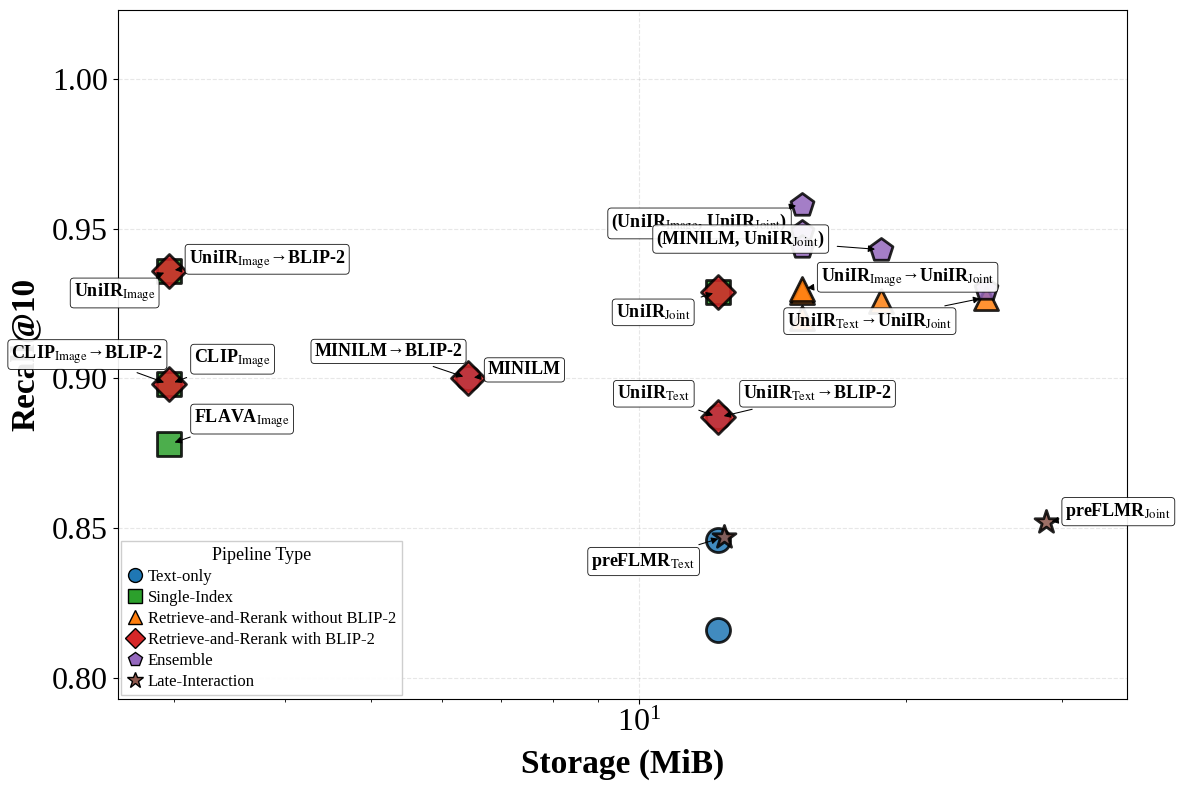

Saved: storage_vs_recall_flickr.png

[Info] Skipped entries (3-stage or missing component storage):
  - COCO: CLIP_Image→UniIR_Joint→BLIP-2
  - COCO: FLAVA_Image→UniIR_Joint→BLIP-2
  - COCO: UniIR_Image→UniIR_Joint→BLIP-2
  - COCO: FLAVA_Text→UniIR_Joint→BLIP-2
  - COCO: UniIR_Text→UniIR_Joint→BLIP-2
  - Flickr: MINILM→UniIR_Image→BLIP-2
  - Flickr: FLAVA_Image→UniIR_Joint→BLIP-2
  - Flickr: CLIP_Image→UniIR_Joint→BLIP-2
  - Flickr: UniIR_Text→FLAVA_Image→BLIP-2
  - Flickr: MINILM→UniIR_Joint→BLIP-2


In [12]:
#sammy find this
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.transforms import Bbox
import numpy as np
import re

# ========== Font sizing controls (axes/ticks only) ==========
AXIS_LABEL_FONTSIZE = 24
TICK_LABEL_FONTSIZE = 23
TITLE_FONTSIZE = 25
LEGEND_FONTSIZE = 12
LEGEND_TITLE_FONTSIZE = 13
ANNOT_FONTSIZE = 13  # label font

# ---------- modality→subscript formatter ----------
_SUB_RE = re.compile(r'([A-Za-z0-9]+)_([A-Za-z0-9]+)')
def fmt_modality(name: str) -> str:
    return _SUB_RE.sub(lambda m: f"{m.group(1)}$_{{\\mathrm{{{m.group(2)}}}}}$", name)

# -------------------- R@10 DATA --------------------
# (name, dataset, R@10, latency_unused, pipeline_type, marker)
recall_data = [
    # COCO - Text-only
    ("MINILM", "COCO", 0.7082, 0.029935, "Text-only", "circle"),
    ("UniIR_Text", "COCO", 0.7668, 0.041275, "Text-only", "circle"),
    ("CLIP_Text", "COCO", 0.6916, 0.042034, "Text-only", "circle"),
    ("FLAVA_Text", "COCO", 0.7734, 0.042460, "Text-only", "circle"),

    # COCO - Single-Index
    ("UniIR_Image", "COCO", 0.8578, 0.0260013, "Single-Index", "square"),
    ("CLIP_Image", "COCO", 0.7238, 0.026881, "Single-Index", "square"),
    ("FLAVA_Image", "COCO", 0.7998, 0.027210, "Single-Index", "square"),
    ("UniIR_Joint", "COCO", 0.8384, 0.041576, "Single-Index", "square"),

    # COCO - Retrieve-and-Rerank → UniIR_Joint (no BLIP-2)
    ("UniIR_Image→UniIR_Joint", "COCO", 0.8382, 0.034189, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint",  "COCO", 0.8200, 0.034812, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "COCO", 0.8360, 0.035594, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint",  "COCO", 0.8304, 0.049600, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Text→UniIR_Joint",  "COCO", 0.8276, 0.050398, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # COCO - Retrieve-and-Rerank → BLIP-2
    ("UniIR_Image→BLIP-2", "COCO", 0.8578, 0.554640, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→BLIP-2", "COCO", 0.7998, 0.556091, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2",  "COCO", 0.7668, 0.571018, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "COCO", 0.8384, 0.572662, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→BLIP-2",  "COCO", 0.7728, 0.573004, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # COCO - Retrieve-and-Rerank → UniIR_Joint → BLIP-2 (3-stage, skipped for storage sum)
    ("CLIP_Image→UniIR_Joint→BLIP-2", "COCO", 0.8200, 0.562469, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→UniIR_Joint→BLIP-2", "COCO", 0.8360, 0.564600, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→UniIR_Joint→BLIP-2", "COCO", 0.8382, 0.570765, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→UniIR_Joint→BLIP-2", "COCO", 0.8276, 0.578169, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→UniIR_Joint→BLIP-2", "COCO", 0.8304, 0.579810, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # COCO - Ensemble (RRF)
    ("(UniIR_Image, UniIR_Joint)", "COCO", 0.8816, 0.079296, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)",  "COCO", 0.8532, 0.079693, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "COCO", 0.8764, 0.080066, "Ensemble", "pentagon"),
    ("(UniIR_Text, UniIR_Joint)",  "COCO", 0.8450, 0.082520, "Ensemble", "pentagon"),
    ("(FLAVA_Text, UniIR_Joint)",  "COCO", 0.8590, 0.083135, "Ensemble", "pentagon"),

    # COCO - Late Interaction
    ("preFLMR_Text", "COCO", 0.6426, 0.032712, "Late-Interaction", "star"),
    ("preFLMR_Joint", "COCO", 0.6448, 0.033582, "Late-Interaction", "star"),

    # Flickr - Text-only
    ("MINILM", "Flickr", 0.9000, 0.020586, "Text-only", "circle"),
    ("UniIR_Text", "Flickr", 0.8870, 0.023326, "Text-only", "circle"),
    ("CLIP_Text", "Flickr", 0.8160, 0.024509, "Text-only", "circle"),
    ("FLAVA_Text", "Flickr", 0.8460, 0.024991, "Text-only", "circle"),

    # Flickr - Single-Index
    ("UniIR_Image", "Flickr", 0.9360, 0.020462, "Single-Index", "square"),
    ("CLIP_Image", "Flickr", 0.8980, 0.021269, "Single-Index", "square"),
    ("FLAVA_Image", "Flickr", 0.8780, 0.021523, "Single-Index", "square"),
    ("UniIR_Joint", "Flickr", 0.9290, 0.024338, "Single-Index", "square"),

    # Flickr - Retrieve-and-Rerank → UniIR_Joint (no BLIP-2)
    ("MINILM→UniIR_Joint",   "Flickr", 0.9260, 0.030526, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint","Flickr", 0.9200, 0.031557, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint","Flickr", 0.9290, 0.031800, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint","Flickr", 0.9300, 0.031807, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint","Flickr", 0.9270, 0.032340, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # Flickr - Retrieve-and-Rerank → BLIP-2
    ("MINILM→BLIP-2",      "Flickr", 0.9000, 0.532178, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→BLIP-2", "Flickr", 0.9360, 0.533093, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2",  "Flickr", 0.8870, 0.533816, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "Flickr", 0.9290, 0.535330, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→BLIP-2",  "Flickr", 0.8980, 0.537770, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # Flickr - Retrieve-and-Rerank → UniIR → BLIP-2 (3-stage, skipped for storage sum)
    ("MINILM→UniIR_Image→BLIP-2",      "Flickr", 0.9530, 0.538228, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→UniIR_Joint→BLIP-2", "Flickr", 0.9440, 0.539769, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→UniIR_Joint→BLIP-2",  "Flickr", 0.9200, 0.541981, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→FLAVA_Image→BLIP-2",  "Flickr", 0.9340, 0.544663, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("MINILM→UniIR_Joint→BLIP-2",      "Flickr", 0.9260, 0.581779, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # Flickr - Ensemble (RRF) — R@10
    ("(UniIR_Image, UniIR_Joint)", "Flickr", 0.9580, 0.062990, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)",  "Flickr", 0.9490, 0.063460, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "Flickr", 0.9440, 0.063764, "Ensemble", "pentagon"),
    ("(UniIR_Text, UniIR_Joint)",  "Flickr", 0.9300, 0.065280, "Ensemble", "pentagon"),
    ("(MINILM, UniIR_Joint)",      "Flickr", 0.9430, 0.066417, "Ensemble", "pentagon"),

    # Flickr - Late Interaction
    ("preFLMR_Text", "Flickr", 0.8470, 0.031436, "Late-Interaction", "star"),
    ("preFLMR_Joint", "Flickr", 0.8520, 0.033128, "Late-Interaction", "star"),
]

# ============================================================
# Storage lookup (MiB)
# ============================================================
storage_lookup = {
    # COCO: Text-only
    ("COCO", "MINILM"): 31.93,
    ("COCO", "CLIP_Text"): 61.23,
    ("COCO", "FLAVA_Text"): 61.23,
    ("COCO", "UniIR_Text"): 61.23,

    # COCO: Single-Index
    ("COCO", "CLIP_Image"): 14.85,
    ("COCO", "FLAVA_Image"): 14.85,
    ("COCO", "UniIR_Image"): 14.85,
    ("COCO", "UniIR_Joint"): 61.23,

    # COCO: Late-Interaction (PreFLMR)
    ("COCO", "preFLMR_Text"): 51.17,
    ("COCO", "preFLMR_Joint"): 133.46,

    # Flickr: Text-only
    ("Flickr", "MINILM"): 6.43,
    ("Flickr", "CLIP_Text"): 12.29,
    ("Flickr", "FLAVA_Text"): 12.29,
    ("Flickr", "UniIR_Text"): 12.29,

    # Flickr: Single-Index
    ("Flickr", "CLIP_Image"): 2.96,
    ("Flickr", "FLAVA_Image"): 2.96,
    ("Flickr", "UniIR_Image"): 2.96,
    ("Flickr", "UniIR_Joint"): 12.29,

    # Flickr: Late-Interaction (PreFLMR)
    ("Flickr", "preFLMR_Text"): 12.46,
    ("Flickr", "preFLMR_Joint"): 28.75,
}

BLIP2_STORAGE_MIB = 0.0  # treat BLIP-2 as stateless reranker here

def model_storage(dataset: str, model_name: str):
    return storage_lookup.get((dataset, model_name), None)

def combo_storage(dataset: str, name: str):
    if "→" in name:
        parts = [p.strip() for p in name.split("→")]
        if len(parts) >= 3:  # skip 3-stage for storage summation
            return None
        a, b = parts
        if b == "BLIP-2":
            sa = model_storage(dataset, a)
            return None if sa is None else sa + BLIP2_STORAGE_MIB
        sa, sb = model_storage(dataset, a), model_storage(dataset, b)
        return None if (sa is None or sb is None) else sa + sb
    if name.startswith("(") and name.endswith(")"):  # ensembles (sum)
        total = 0.0
        for c in [c.strip() for c in name[1:-1].split(",")]:
            sc = model_storage(dataset, c)
            if sc is None: return None
            total += sc
        return total
    return model_storage(dataset, name)

# ---- merge storage with recall ----
merged_points, skipped = [], []
for (name, dataset, r10, _lat, ptype, m) in recall_data:
    s = combo_storage(dataset, name)
    if s is None: skipped.append((dataset, name))
    else: merged_points.append((name, dataset, s, r10, ptype, m))

coco_points   = [p for p in merged_points if p[1] == "COCO"]
flickr_points = [p for p in merged_points if p[1] == "Flickr"]

# ---- styles ----
pipeline_colors = {
    "Text-only": "#1f77b4",
    "Single-Index": "#2ca02c",
    "Late-Interaction": "#8c564b",
    "Retrieve-and-Rerank without BLIP-2": "#ff7f0e",
    "Retrieve-and-Rerank with BLIP-2": "#d62728",
    "Ensemble": "#9467bd",
}
marker_styles = {"circle":"o","square":"s","triangle":"^","diamond":"D","pentagon":"p","star":"*"}

def legend_for(ax, active_types, type_to_marker):
    handles = [
        Line2D([0],[0],
               marker=type_to_marker[t], color="w",
               markerfacecolor=pipeline_colors[t], markeredgecolor="black",
               markersize=10 if type_to_marker[t]!="*" else 12,
               linewidth=1.5, label=t)
        for t in active_types
    ]
    leg = ax.legend(
        handles=handles,
        loc="lower left",
        borderaxespad=0.2,
        frameon=True, framealpha=0.95,
        shadow=False, fancybox=False,
        title="Pipeline Type",
        title_fontsize=LEGEND_TITLE_FONTSIZE,
        fontsize=LEGEND_FONTSIZE,
        handlelength=0.9, handletextpad=0.35,
        borderpad=0.35, labelspacing=0.3, columnspacing=0.6, ncol=1
    )
    return leg

# ---------- label helpers ----------
def candidate_offsets():
    radii  = [14, 22, 30, 40, 52, 66, 84, 104, 124, 148]
    angles = range(0, 360, 18)
    for r in radii:
        for a in angles:
            yield (r*np.cos(np.deg2rad(a)), r*np.sin(np.deg2rad(a)))

def select_best_per_pipeline(points):
    by_type = {}
    for p in points:
        by_type.setdefault(p[4], []).append(p)
    chosen = []
    for ptype, lst in by_type.items():
        best = sorted(lst, key=lambda x: (-x[3], x[2]))[0]  # highest recall, then smallest storage
        chosen.append(best)
    chosen.sort(key=lambda t: -t[3])
    return chosen

def select_rightmost_per_pipeline(points, exclude_names=None):
    """Highest storage per pipeline; tie-breaker = higher recall."""
    if exclude_names is None: exclude_names = set()
    by_type, chosen = {}, []
    for p in points:
        if p[0] in exclude_names:
            continue
        by_type.setdefault(p[4], []).append(p)
    for ptype, lst in by_type.items():
        rightmost = max(lst, key=lambda x: (x[2], x[3]))  # (storage, recall)
        chosen.append(rightmost)
    chosen.sort(key=lambda t: -t[2])  # label the biggest first
    return chosen

def select_leftmost_points(points, k=3, exclude_names=None):
    if exclude_names is None: exclude_names = set()
    sorted_pts = sorted(points, key=lambda p: p[2])
    chosen = []
    for p in sorted_pts:
        if p[0] in exclude_names:
            continue
        chosen.append(p)
        if len(chosen) >= k:
            break
    return chosen

def select_leftmost_by_type(points, pipeline_type, k, exclude_names=None):
    if exclude_names is None: exclude_names = set()
    pts = [p for p in points if p[4] == pipeline_type and p[0] not in exclude_names]
    pts.sort(key=lambda p: p[2])
    return pts[:k]

def annotate_best(ax, fig, best_points, avoid_bboxes=None,
                  manual_offsets=None, pipeline_offsets=None):
    if avoid_bboxes is None: avoid_bboxes = []
    if manual_offsets is None: manual_offsets = {}
    if pipeline_offsets is None: pipeline_offsets = {}
    renderer = fig.canvas.get_renderer()
    placed_bboxes = [bb for bb in avoid_bboxes]

    for (name, ds, x, r, ptype, _m) in best_points:
        txt = f"{fmt_modality(name)}"
        trials = []
        if (ds, name) in manual_offsets: trials.append(manual_offsets[(ds, name)])
        if ptype in pipeline_offsets:     trials.append(pipeline_offsets[ptype])
        trials.extend(candidate_offsets())

        for (dx, dy) in trials:
            ann = ax.annotate(
                txt, xy=(x, r), xytext=(dx, dy), textcoords="offset points",
                fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx>=0 else "right",
                va="bottom" if dy>=0 else "top",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black",
                          linewidth=0.6, alpha=0.92),
                arrowprops=dict(arrowstyle="-|>", color="black", linewidth=0.75,
                                shrinkA=6, shrinkB=4, mutation_scale=10,
                                connectionstyle="arc3,rad=0"),
                clip_on=False, zorder=6
            )
            fig.canvas.draw()
            bb = ann.get_window_extent(renderer=renderer)
            bb = Bbox.from_extents(bb.x0-2, bb.y0-2, bb.x1+2, bb.y1+2)
            if any(bb.overlaps(prev) for prev in placed_bboxes):
                ann.remove()
            else:
                placed_bboxes.append(bb)
                break
    return placed_bboxes

def annotate_leftmost(ax, fig, left_points, avoid_bboxes=None, manual_offsets=None):
    if avoid_bboxes is None: avoid_bboxes = []
    if manual_offsets is None: manual_offsets = {}
    renderer = fig.canvas.get_renderer()
    placed_bboxes = [bb for bb in avoid_bboxes]
    right_biased = [(18, 10), (18, -10), (24, 12), (24, -12), (30, 0)]

    for (name, ds, x, r, _ptype, _m) in left_points:
        txt = f"{fmt_modality(name)}"
        trials = []
        if (ds, name) in manual_offsets: trials.append(manual_offsets[(ds, name)])
        trials.extend(right_biased)
        trials.extend(candidate_offsets())

        for (dx, dy) in trials:
            ann = ax.annotate(
                txt, xy=(x, r), xytext=(dx, dy), textcoords="offset points",
                fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx>=0 else "right",
                va="bottom" if dy>=0 else "top",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black",
                          linewidth=0.6, alpha=0.92),
                arrowprops=dict(arrowstyle="-|>", color="black", linewidth=0.75,
                                shrinkA=6, shrinkB=4, mutation_scale=10,
                                connectionstyle="arc3,rad=0"),
                clip_on=False, zorder=5
            )
            fig.canvas.draw()
            bb = ann.get_window_extent(renderer=renderer)
            bb = Bbox.from_extents(bb.x0-2, bb.y0-2, bb.x1+2, bb.y1+2)
            if any(bb.overlaps(prev) for prev in placed_bboxes):
                ann.remove()
            else:
                placed_bboxes.append(bb)
                break
    return placed_bboxes

def annotate_rightmost(ax, fig, rightmost_points, avoid_bboxes=None,
                       manual_offsets=None, pipeline_offsets=None):
    """Label the highest-storage point per pipeline with a left-biased sweep."""
    if avoid_bboxes is None: avoid_bboxes = []
    if manual_offsets is None: manual_offsets = {}
    if pipeline_offsets is None: pipeline_offsets = {}
    renderer = fig.canvas.get_renderer()
    placed_bboxes = [bb for bb in avoid_bboxes]

    left_sweep = [(-24, 10), (-24, -10), (-32, 14), (-32, -14),
                  (-40, 0), (-48, 12), (-48, -12), (-64, 0), (-80, 0)]

    for (name, ds, x, r, ptype, _m) in rightmost_points:
        txt = f"{fmt_modality(name)}"
        trials = []
        if (ds, name) in manual_offsets: trials.append(manual_offsets[(ds, name)])
        if ptype in pipeline_offsets:     trials.append(pipeline_offsets[ptype])
        trials.extend(left_sweep)
        trials.extend(candidate_offsets())

        for (dx, dy) in trials:
            ann = ax.annotate(
                txt, xy=(x, r), xytext=(dx, dy), textcoords="offset points",
                fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx>=0 else "right",
                va="bottom" if dy>=0 else "top",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black",
                          linewidth=0.6, alpha=0.92),
                arrowprops=dict(arrowstyle="-|>", color="black", linewidth=0.75,
                                shrinkA=6, shrinkB=4, mutation_scale=10,
                                connectionstyle="arc3,rad=0"),
                clip_on=False, zorder=6
            )
            fig.canvas.draw()
            bb = ann.get_window_extent(renderer=renderer)
            bb = Bbox.from_extents(bb.x0-2, bb.y0-2, bb.x1+2, bb.y1+2)
            if any(bb.overlaps(prev) for prev in placed_bboxes):
                ann.remove()
            else:
                placed_bboxes.append(bb)
                break
    return placed_bboxes

# ========= knobs =========
LEFTMOST_K = 3
FORCE_LEFT_BLIP2 = 2

# (dataset, exact name) -> (dx, dy) for BEST-per-pipeline labels
MANUAL_LABEL_OFFSETS = {
    ("COCO",   "UniIR_Joint"): (28, 16),
    ("Flickr", "UniIR_Joint"): (24, -12),
}
# default per-pipeline nudges for BEST labels
PIPELINE_LABEL_OFFSETS = {
    "Single-Index": (-10, -8),
    "Ensemble": (-10, -5),
}

# (dataset, exact name) -> (dx, dy) for RIGHTMOST labels (problem cases)
MANUAL_RIGHTMOST_LABEL_OFFSETS = {
    ("COCO",   "UniIR_Text→UniIR_Joint"): (-36, 12),
    ("Flickr", "UniIR_Text→UniIR_Joint"): (-14, 36),            # ↑ clear preFLMR
    ("Flickr", "(UniIR_Text, UniIR_Joint)"): (0, 0),         # move Ensemble up-left
    ("Flickr", "preFLMR_Joint"): (-14, -52),
}
# default nudges for RIGHTMOST labels → bias leftwards
RIGHTMOST_PIPELINE_LABEL_OFFSETS = {
    "Text-only": (-20, 10),
    "Single-Index": (-20, -8),
    "Retrieve-and-Rerank without BLIP-2": (-24, 10),
    "Retrieve-and-Rerank with BLIP-2": (-24, 10),
    "Ensemble": (-24, 22),
    "Late-Interaction": (-20, -10),
}

# (dataset, exact name) -> (dx, dy) for LEFTMOST labels (including BLIP-2)
MANUAL_LEFT_LABEL_OFFSETS = {
    ("COCO",   "UniIR_Image→BLIP-2"): (18, 10),
    ("Flickr", "UniIR_Image→BLIP-2"): (18, 10),
}

# --------- NEVER LABEL these exact (dataset, name) pairs ----------
LABEL_BLACKLIST = {
    ("COCO",   "FLAVA_Image→BLIP-2"),
    ("Flickr", "FLAVA_Image→BLIP-2"),  # remove this line if you want Flickr labeled
    ("Flickr", "(UniIR_Text, UniIR_Joint)")
}

def expand_limits_after_labels(ax, x_expand_hi=1.10, y_expand_hi=1.06, x_expand_lo=1.02, y_expand_lo=1.02):
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    ax.set_xlim(xmin / x_expand_lo, xmax * x_expand_hi)
    ax.set_ylim(ymin / y_expand_lo, ymax * y_expand_hi)

# ---------- plot ----------
def make_plot(points, title, outfile):
    fig, ax = plt.subplots(figsize=(12, 8))

    # scatter all points (plotting unaffected by blacklist)
    active_types, type_to_marker = [], {}
    for (name, dataset, storage_mib, recall_r10, pipeline_type, marker_type) in points:
        if pipeline_type not in active_types:
            active_types.append(pipeline_type)
            type_to_marker[pipeline_type] = marker_styles[marker_type]
        ax.scatter(storage_mib, recall_r10, s=300, alpha=0.85,
                   color=pipeline_colors[pipeline_type],
                   marker=marker_styles[marker_type],
                   edgecolors="black", linewidth=2, zorder=3)

    ax.set_xscale("log")
    ax.grid(True, alpha=0.3, linestyle="--", zorder=0)
    ax.set_xlabel("Storage (MiB)", fontsize=AXIS_LABEL_FONTSIZE, fontweight="bold", labelpad=8)
    ax.set_ylabel("Recall@10",      fontsize=AXIS_LABEL_FONTSIZE, fontweight="bold", labelpad=8)
    ax.tick_params(axis="both", which="both", labelsize=TICK_LABEL_FONTSIZE)
    if title:
        ax.set_title(title, fontsize=TITLE_FONTSIZE, pad=8)

    # Legend first (so labels avoid it)
    leg = legend_for(ax, active_types, type_to_marker)
    fig.canvas.draw()
    leg_bb = leg.get_window_extent(fig.canvas.get_renderer())
    leg_bb = Bbox.from_extents(leg_bb.x0-4, leg_bb.y0-4, leg_bb.x1+4, leg_bb.y1+4)

    # ---------- filter points for LABEL SELECTION ONLY ----------
    dataset = points[0][1] if points else None
    blk_names = {name for (ds, name) in LABEL_BLACKLIST if ds == dataset}
    points_sel = [p for p in points if p[0] not in blk_names]
    # ------------------------------------------------------------

    # 1) BEST per pipeline
    best_points = select_best_per_pipeline(points_sel)
    placed_boxes = annotate_best(
        ax, fig, best_points,
        avoid_bboxes=[leg_bb],
        manual_offsets=MANUAL_LABEL_OFFSETS,
        pipeline_offsets=PIPELINE_LABEL_OFFSETS
    )

    # 1b) HIGHEST-STORAGE per pipeline (skip ones already labeled)
    already = {p[0] for p in best_points}
    rightmost_points = select_rightmost_per_pipeline(points_sel, exclude_names=already)
    placed_boxes = annotate_rightmost(
        ax, fig, rightmost_points,
        avoid_bboxes=placed_boxes,
        manual_offsets=MANUAL_RIGHTMOST_LABEL_OFFSETS,
        pipeline_offsets=RIGHTMOST_PIPELINE_LABEL_OFFSETS
    )

    # 2) LEFTMOST K points (any type), excluding already-labeled
    already |= {p[0] for p in rightmost_points}
    left_points = select_leftmost_points(points_sel, k=LEFTMOST_K, exclude_names=already)

    # 3) Ensure we also label the leftmost BLIP-2 pipelines
    blip2_add = select_leftmost_by_type(
        points_sel, "Retrieve-and-Rerank with BLIP-2", FORCE_LEFT_BLIP2,
        exclude_names=already | {p[0] for p in left_points} | blk_names
    )
    left_points = blip2_add + left_points  # BLIP-2 first for priority

    placed_boxes = annotate_leftmost(
        ax, fig, left_points,
        avoid_bboxes=placed_boxes,
        manual_offsets=MANUAL_LEFT_LABEL_OFFSETS
    )

    expand_limits_after_labels(ax)

    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {outfile}")

# -------- run --------
#make_plot(coco_points,   title="", outfile="storage_vs_recall_coco.png")
make_plot(flickr_points, title="",  outfile="storage_vs_recall_flickr.png")

if skipped:
    print("\n[Info] Skipped entries (3-stage or missing component storage):")
    for ds, nm in skipped:
        print(f"  - {ds}: {nm}")


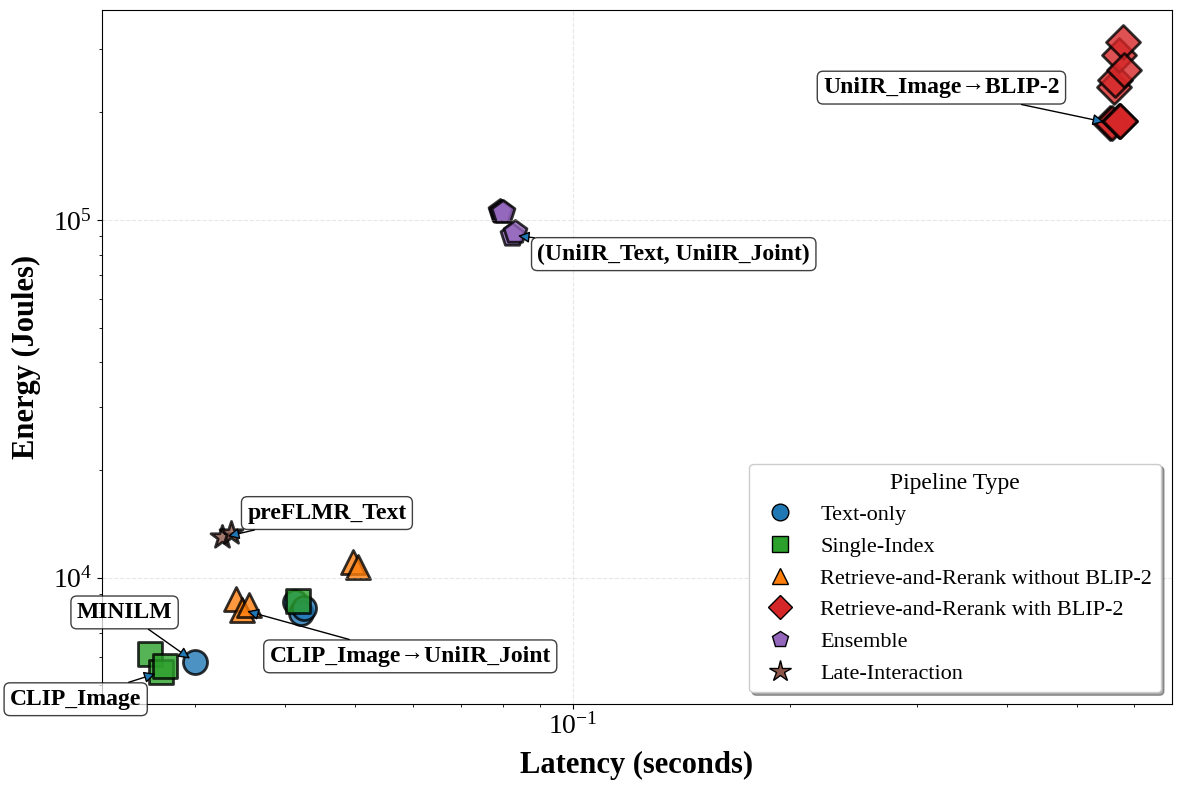

✓ COCO scatter plot saved as 'energy_vs_latency_coco.png'
  Total COCO data points: 30


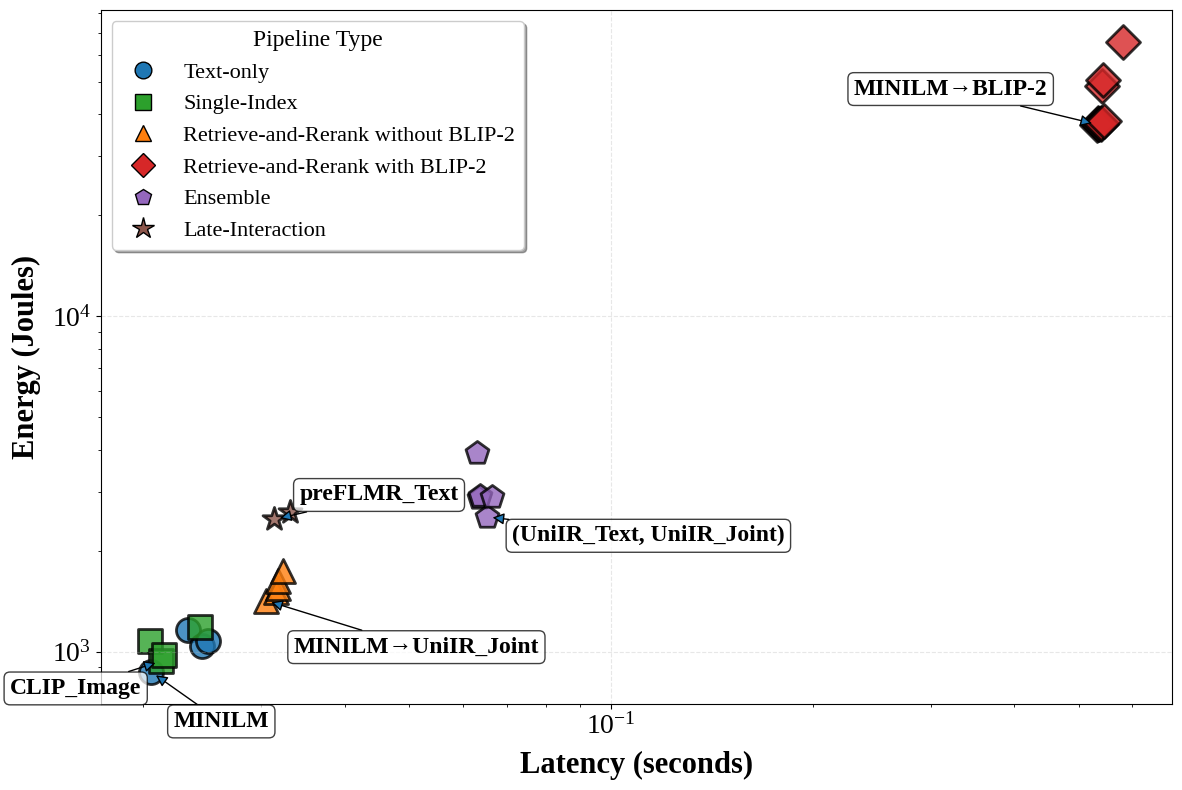

✓ Flickr scatter plot saved as 'energy_vs_latency_flickr.png'
  Total Flickr data points: 30

SUMMARY STATISTICS - ENERGY VS LATENCY (CORRECTED)

📊 COCO Dataset:
  Text-only                               : 4 points
    ├─ Energy: 5811.43 - 8558.79 J
    └─ Latency: 0.029935 - 0.042460s
  Single-Index                            : 4 points
    ├─ Energy: 5440.23 - 8611.00 J
    └─ Latency: 0.026001 - 0.041576s
  Retrieve-and-Rerank without BLIP-2      : 5 points
    ├─ Energy: 8126.19 - 11040.45 J
    └─ Latency: 0.034189 - 0.050398s
  Retrieve-and-Rerank with BLIP-2         : 10 points
    ├─ Energy: 186549.05 - 315481.77 J
    └─ Latency: 0.554640 - 0.579810s
  Ensemble                                : 5 points
    ├─ Energy: 90641.21 - 105677.29 J
    └─ Latency: 0.079296 - 0.083135s
  Late-Interaction                        : 2 points
    ├─ Energy: 12944.12 - 13292.00 J
    └─ Latency: 0.032712 - 0.033582s

📊 Flickr Dataset:
  Text-only                               : 4 points
    ├

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import math

# =========================
# Font sizing controls (only axes/ticks)
# =========================
AXIS_LABEL_FONTSIZE = 22
TICK_LABEL_FONTSIZE = 20
TITLE_FONTSIZE = 18
LEGEND_FONTSIZE = 16
LEGEND_TITLE_FONTSIZE = 17
ANNOT_FONTSIZE = 17

# =========================
# How to choose "best" within a pipeline
#   "product"  -> minimize (energy * latency)  [default]
#   "weighted" -> minimize w*E_norm + (1-w)*L_norm  (log-normalized)
#   "pareto"   -> minimize max(E_norm, L_norm)     (Chebyshev/Pareto-ish)
# =========================
BEST_SELECTION_MODE = "product"
WEIGHT_W = 0.5  # used only when BEST_SELECTION_MODE == "weighted"

# Carefully matched data from the tables
# Format: (name, dataset, energy, latency, pipeline_type, marker_type)
data = [
    # ============ COCO - Text-only ============
    ("MINILM", "COCO", 5811.429, 0.029935, "Text-only", "circle"),
    ("UniIR_Text", "COCO", 8558.791, 0.041275, "Text-only", "circle"),
    ("CLIP_Text", "COCO", 7966.375, 0.042034, "Text-only", "circle"),
    ("FLAVA_Text", "COCO", 8192.518, 0.042460, "Text-only", "circle"),

    # ============ COCO - Single-Index ============
    ("UniIR_Image", "COCO", 6096.318, 0.0260013, "Single-Index", "square"),
    ("CLIP_Image", "COCO", 5440.233, 0.026881, "Single-Index", "square"),
    ("FLAVA_Image", "COCO", 5671.572, 0.027210, "Single-Index", "square"),
    ("UniIR_Joint", "COCO", 8610.995, 0.041576, "Single-Index", "square"),

    # ============ COCO - Retrieve-and-Rerank WITHOUT BLIP-2 ============
    ("UniIR_Image→UniIR_Joint", "COCO", 8731.663, 0.034189, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint", "COCO", 8126.193, 0.034812, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "COCO", 8371.911, 0.035594, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "COCO", 11040.448, 0.049600, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Text→UniIR_Joint", "COCO", 10726.097, 0.050398, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # ============ COCO - Retrieve-and-Rerank WITH BLIP-2 ============
    ("UniIR_Image→BLIP-2", "COCO", 186549.050, 0.554640, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→BLIP-2", "COCO", 186615.231, 0.558244, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "COCO", 189141.903, 0.571018, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "COCO", 189307.593, 0.572662, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→BLIP-2", "COCO", 189222.290, 0.573004, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→UniIR_Joint→BLIP-2", "COCO", 236120.681, 0.562469, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→UniIR_Joint→BLIP-2", "COCO", 245911.588, 0.564600, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→UniIR_Joint→BLIP-2", "COCO", 288618.468, 0.570765, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→UniIR_Joint→BLIP-2", "COCO", 315481.771, 0.578169, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→UniIR_Joint→BLIP-2", "COCO", 262924.2185, 0.579810, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # ============ COCO - Ensemble ============
    ("(UniIR_Image, UniIR_Joint)", "COCO", 105677.2855, 0.079296, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)", "COCO", 105455.913, 0.079693, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "COCO", 105274.773, 0.080066, "Ensemble", "pentagon"),
    ("(UniIR_Text, UniIR_Joint)", "COCO", 90641.2095, 0.08252, "Ensemble", "pentagon"),
    ("(FLAVA_Text, UniIR_Joint)", "COCO", 92778.6565, 0.083135, "Ensemble", "pentagon"),

    # ============ COCO - Late Interaction ============
    ("preFLMR_Text", "COCO", 12944.118, 0.032712, "Late-Interaction", "star"),
    ("preFLMR_Joint", "COCO", 13292.001, 0.033582, "Late-Interaction", "star"),

    # ============ Flickr - Text-only ============
    ("MINILM", "Flickr", 870.461, 0.020586, "Text-only", "circle"),
    ("UniIR_Text", "Flickr", 1164.629, 0.023326, "Text-only", "circle"),
    ("CLIP_Text", "Flickr", 1039.328, 0.024509, "Text-only", "circle"),
    ("FLAVA_Text", "Flickr", 1080.792, 0.024991, "Text-only", "circle"),

    # ============ Flickr - Single-Index ============
    ("UniIR_Image", "Flickr", 1074.525, 0.020462, "Single-Index", "square"),
    ("CLIP_Image", "Flickr", 937.406, 0.021269, "Single-Index", "square"),
    ("FLAVA_Image", "Flickr", 975.371, 0.021523, "Single-Index", "square"),
    ("UniIR_Joint", "Flickr", 1189.419, 0.024338, "Single-Index", "square"),

    # ============ Flickr - Retrieve-and-Rerank WITHOUT BLIP-2 ============
    ("MINILM→UniIR_Joint", "Flickr", 1422.089, 0.030526, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint", "Flickr", 1509.416, 0.031557, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "Flickr", 1544.724, 0.03180, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint", "Flickr", 1624.571, 0.031807, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "Flickr", 1745.200, 0.03234, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # ============ Flickr - Retrieve-and-Rerank WITH BLIP-2 ============
    ("MINILM→BLIP-2", "Flickr", 37289.005, 0.532178, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→BLIP-2", "Flickr", 37359.645, 0.533093, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "Flickr", 37662.098, 0.533816, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "Flickr", 37509.338, 0.535330, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→BLIP-2", "Flickr", 37413.210, 0.537770, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("MINILM→UniIR_Image→BLIP-2", "Flickr", 37676.546, 0.538228, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→UniIR_Joint→BLIP-2", "Flickr", 48526.450, 0.539769, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→UniIR_Joint→BLIP-2", "Flickr", 50759.5645, 0.541981, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→FLAVA_Image→BLIP-2", "Flickr", 38148.502, 0.544663, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("MINILM→UniIR_Joint→BLIP-2", "Flickr", 65925.648, 0.581779, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # ============ Flickr - Ensemble ============
    ("(UniIR_Image, UniIR_Joint)", "Flickr", 3923.4045, 0.062990, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)", "Flickr", 2875.456, 0.06346, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "Flickr", 2916.763, 0.063764, "Ensemble", "pentagon"),
    ("(UniIR_Text, UniIR_Joint)", "Flickr", 2525.118, 0.06528, "Ensemble", "pentagon"),
    ("(MINILM, UniIR_Joint)", "Flickr", 2892.695, 0.066417, "Ensemble", "pentagon"),

    # ============ Flickr - Late Interaction ============
    ("preFLMR_Text", "Flickr", 2482.026, 0.031436, "Late-Interaction", "star"),
    ("preFLMR_Joint", "Flickr", 2619.403, 0.033128, "Late-Interaction", "star"),
]

# Define colors for pipeline types
pipeline_colors = {
    "Text-only": "#1f77b4",
    "Single-Index": "#2ca02c",
    "Retrieve-and-Rerank without BLIP-2": "#ff7f0e",
    "Retrieve-and-Rerank with BLIP-2": "#d62728",
    "Ensemble": "#9467bd",
    "Late-Interaction": "#8c564b",
}
marker_styles = {"circle":"o","square":"s","triangle":"^","diamond":"D","pentagon":"p","star":"*"}

# Label offsets (in points) per type to keep labels away from markers/other points
OFFSETS = {
    "Text-only": (16, 28),
    "Single-Index": (-14, -12),
    "Retrieve-and-Rerank without BLIP-2": (20, -26),
    "Retrieve-and-Rerank with BLIP-2": (-36, 18),
    "Ensemble": (18, -6),
    "Late-Interaction": (18, 10),
}
LABEL_BBOX = dict(boxstyle="round,pad=0.25", fc="white", ec="black", alpha=0.75)
ARROW = dict(arrowstyle="-|>", shrinkA=0, shrinkB=4, lw=1)

# ---------- helpers ----------
def separate_by_dataset(data):
    coco = [d for d in data if d[1] == "COCO"]
    flickr = [d for d in data if d[1] == "Flickr"]
    return coco, flickr

def _normalize_log(vals):
    """Return log10-normalized values in [0,1]; stable if all equal."""
    logs = np.log10(np.array(vals, dtype=float))
    lo, hi = logs.min(), logs.max()
    if hi - lo < 1e-12:
        return np.zeros_like(logs)
    return (logs - lo) / (hi - lo)

def pick_best_point(subset, pipeline_type):
    """
    Pick the best model from this pipeline within 'subset', according to
    BEST_SELECTION_MODE (product / weighted / pareto).
    Returns (latency, energy, name) or None.
    """
    pts = [(lat, eng, name)
           for (name, _ds, eng, lat, ptype, _m) in subset
           if ptype == pipeline_type]
    if not pts:
        return None

    if BEST_SELECTION_MODE == "product":
        # minimize energy * latency
        return min(pts, key=lambda t: (t[0]*t[1], t[0], t[1]))

    # For weighted & pareto we need normalization (log-scale)
    energies = [p[1] for p in pts]
    latencies = [p[0] for p in pts]
    E = _normalize_log(energies)
    L = _normalize_log(latencies)

    if BEST_SELECTION_MODE == "weighted":
        w = WEIGHT_W
        scores = [w*E[i] + (1-w)*L[i] for i in range(len(pts))]
        idx = int(np.argmin(scores))
        return pts[idx]

    if BEST_SELECTION_MODE == "pareto":
        # minimize the worst of (E_norm, L_norm) → Chebyshev distance to origin
        scores = [max(E[i], L[i]) for i in range(len(pts))]
        idx = int(np.argmin(scores))
        return pts[idx]

    # fallback: product
    return min(pts, key=lambda t: (t[0]*t[1], t[0], t[1]))

def _bboxes_overlap(b1, b2):
    return not (b1.x1 <= b2.x0 or b1.x0 >= b2.x1 or b1.y1 <= b2.y0 or b1.y0 >= b2.y1)

def _candidate_offsets(dx, dy):
    return [
        ( dx,  dy), ( dx, -dy), (-dx,  dy), (-dx, -dy),
        (1.5*dx, 0), (0, 1.5*dy), (-1.5*dx, 0), (0, -1.5*dy),
        (2*dx,  2*dy), (-2*dx, 2*dy), (2*dx, -2*dy), (-2*dx, -2*dy),
        (2.5*dx, 0), (0, 2.5*dy), (-2.5*dx, 0), (0, -2.5*dy),
    ]

def scatter_plot(ax, subset, title):
    # plot points
    for name, dataset, energy, latency, pipeline_type, marker_type in subset:
        color = pipeline_colors[pipeline_type]
        marker = marker_styles[marker_type]
        ax.scatter(latency, energy, s=300, alpha=0.8, color=color, marker=marker,
                   edgecolors='black', linewidth=2)

    # axes & styles
    ax.set_xlabel("Latency (seconds)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
    ax.set_ylabel("Energy (Joules)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
    ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)

    # annotate BEST model per pipeline
    types_here = sorted({ptype for (_n,_d,_e,_l,ptype,_m) in subset})
    placed_bboxes = []
    for ptype in types_here:
        best = pick_best_point(subset, ptype)
        if best is None:
            continue
        lat, eng, name = best
        base_dx, base_dy = OFFSETS.get(ptype, (12, 12))

        ann = None
        for dx, dy in _candidate_offsets(base_dx, base_dy):
            ann = ax.annotate(
                name,
                xy=(lat, eng),
                xytext=(dx, dy),
                textcoords="offset points",
                fontsize=ANNOT_FONTSIZE,
                fontweight="bold",
                ha="left" if dx >= 0 else "right",
                va="bottom" if dy >= 0 else "top",
                bbox=LABEL_BBOX,
                arrowprops=ARROW,
                clip_on=False,
                zorder=5
            )
            ax.figure.canvas.draw()
            bbox = ann.get_window_extent(renderer=ax.figure.canvas.get_renderer()).expanded(1.02, 1.08)
            if any(_bboxes_overlap(bbox, b) for b in placed_bboxes):
                ann.remove()
                ann = None
                continue
            else:
                placed_bboxes.append(bbox)
                break

        if ann is None:
            # fallback: place anyway using base offset
            ann = ax.annotate(
                name,
                xy=(lat, eng),
                xytext=(base_dx, base_dy),
                textcoords="offset points",
                fontsize=ANNOT_FONTSIZE,
                fontweight="bold",
                ha="left" if base_dx >= 0 else "right",
                va="bottom" if base_dy >= 0 else "top",
                bbox=LABEL_BBOX,
                arrowprops=ARROW,
                clip_on=False,
                zorder=5
            )

# ---------- split datasets ----------
def separate_by_dataset(data):
    coco = [d for d in data if d[1] == "COCO"]
    flickr = [d for d in data if d[1] == "Flickr"]
    return coco, flickr

coco_data, flickr_data = separate_by_dataset(data)

# ============== COCO plot ==============
fig_coco, ax_coco = plt.subplots(figsize=(12, 8))
scatter_plot(ax_coco, coco_data, "")

legend_elements_coco = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=pipeline_colors["Text-only"],
           markersize=12, label='Text-only', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=pipeline_colors["Single-Index"],
           markersize=12, label='Single-Index', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank without BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank without BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank with BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank with BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='p', color='w', markerfacecolor=pipeline_colors["Ensemble"],
           markersize=12, label='Ensemble', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=pipeline_colors["Late-Interaction"],
           markersize=16, label='Late-Interaction', markeredgecolor='black', linewidth=2),
]
ax_coco.legend(handles=legend_elements_coco, loc='best', fontsize=LEGEND_FONTSIZE, frameon=True,
               shadow=True, title='Pipeline Type', title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('energy_vs_latency_coco.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ COCO scatter plot saved as 'energy_vs_latency_coco.png'")
print(f"  Total COCO data points: {len(coco_data)}")

# ============== Flickr plot ==============
fig_flickr, ax_flickr = plt.subplots(figsize=(12, 8))
scatter_plot(ax_flickr, flickr_data, "")

legend_elements_flickr = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=pipeline_colors["Text-only"],
           markersize=12, label='Text-only', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=pipeline_colors["Single-Index"],
           markersize=12, label='Single-Index', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank without BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank without BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank with BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank with BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='p', color='w', markerfacecolor=pipeline_colors["Ensemble"],
           markersize=12, label='Ensemble', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=pipeline_colors["Late-Interaction"],
           markersize=16, label='Late-Interaction', markeredgecolor='black', linewidth=2),
]
ax_flickr.legend(handles=legend_elements_flickr, loc='best', fontsize=LEGEND_FONTSIZE, frameon=True,
                 shadow=True, title='Pipeline Type', title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('energy_vs_latency_flickr.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Flickr scatter plot saved as 'energy_vs_latency_flickr.png'")
print(f"  Total Flickr data points: {len(flickr_data)}")

# ================= Summary statistics (unchanged) =================
print("\n" + "="*70)
print("SUMMARY STATISTICS - ENERGY VS LATENCY (CORRECTED)")
print("="*70)

def print_stats(name, subset):
    print(f"\n📊 {name} Dataset:")
    for ptype in pipeline_colors.keys():
        sub = [d for d in subset if d[4] == ptype]
        if sub:
            energies = [d[2] for d in sub]
            latencies = [d[3] for d in sub]
            print(f"  {ptype:40s}: {len(sub)} points")
            print(f"    ├─ Energy: {min(energies):.2f} - {max(energies):.2f} J")
            print(f"    └─ Latency: {min(latencies):.6f} - {max(latencies):.6f}s")

def separate_by_dataset(data):
    coco = [d for d in data if d[1] == "COCO"]
    flickr = [d for d in data if d[1] == "Flickr"]
    return coco, flickr

coco_data, flickr_data = separate_by_dataset(data)
print_stats("COCO", coco_data)
print_stats("Flickr", flickr_data)

print("\n" + "="*70)
print(f"✅ Total COCO points: {len(coco_data)}")
print(f"✅ Total Flickr points: {len(flickr_data)}")
print("="*70)


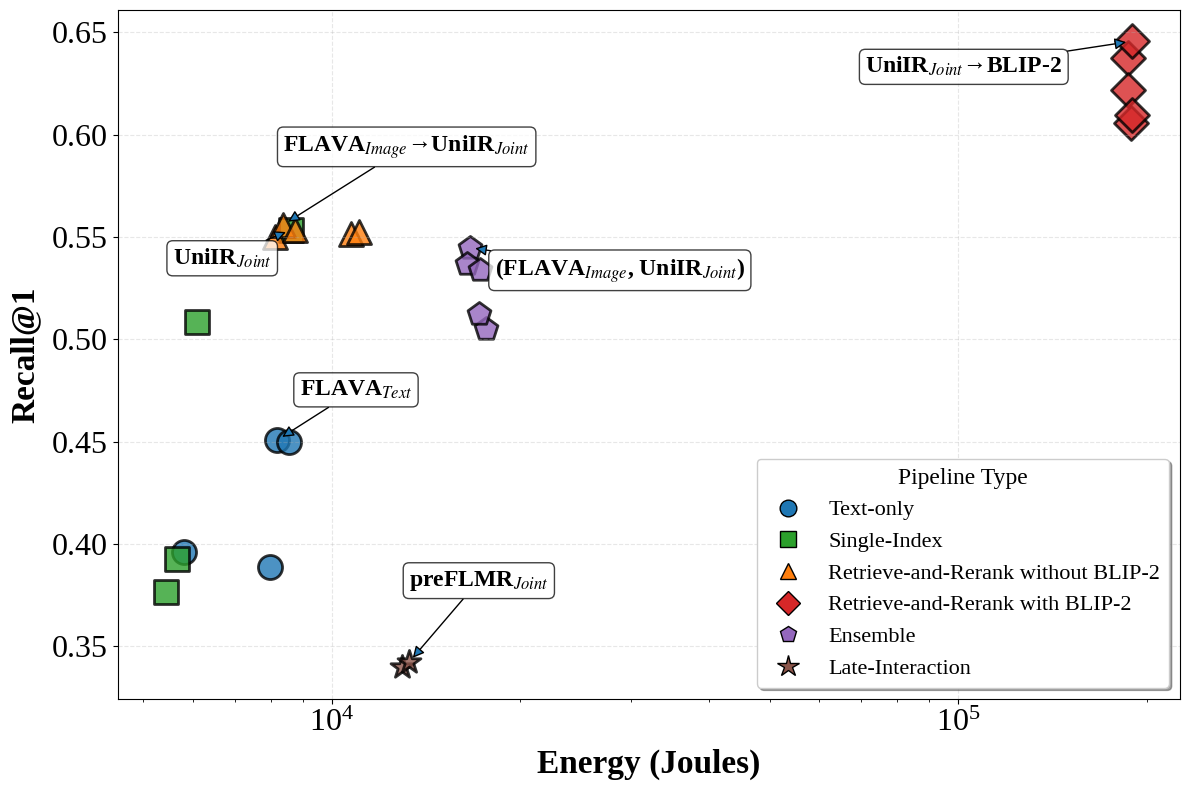

✓ COCO scatter plot saved as 'recall_vs_energy_coco_r1.png'
  Total COCO data points: 25


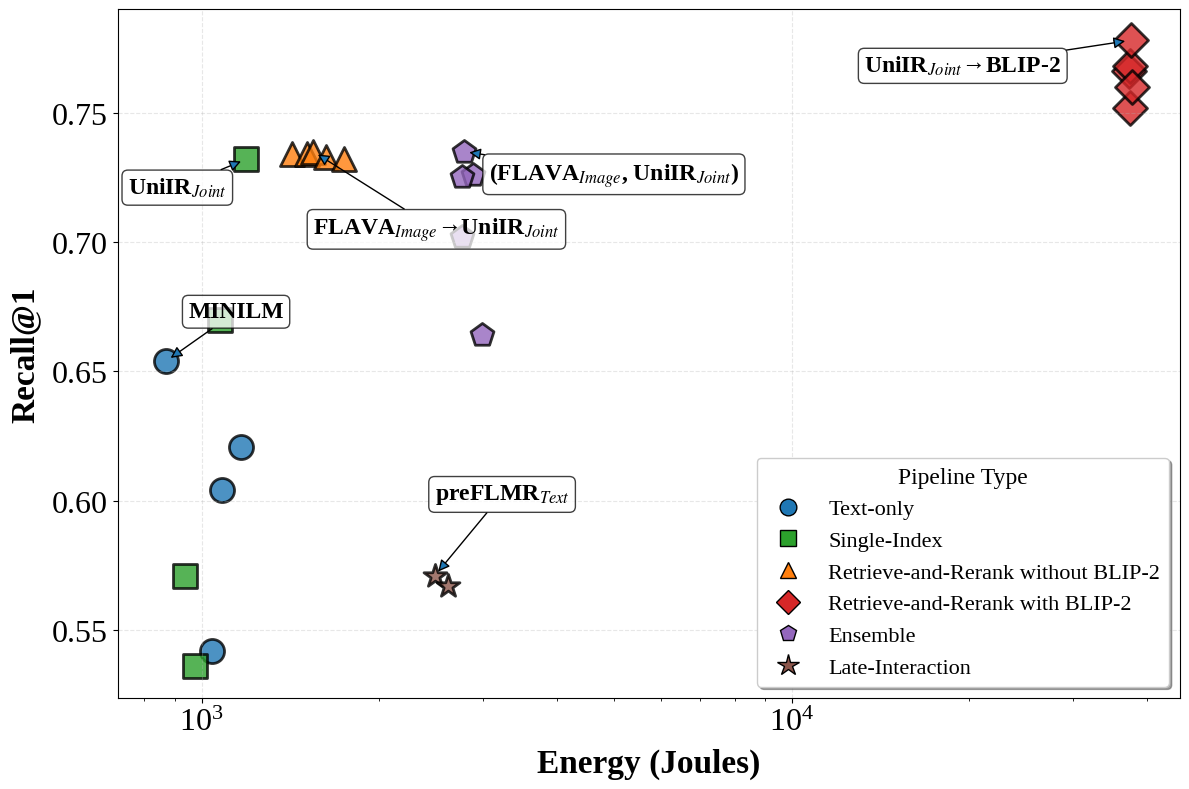

✓ Flickr scatter plot saved as 'recall_vs_energy_flickr_r1.png'
  Total Flickr data points: 25

SUMMARY STATISTICS - RECALL@1 VS ENERGY

📊 COCO Dataset:
  Text-only                               : 4 points | R@1 0.3886-0.4508, Energy 5811.43-8558.79 J
  Single-Index                            : 4 points | R@1 0.3766-0.5534, Energy 5440.23-8611.00 J
  Retrieve-and-Rerank without BLIP-2      : 5 points | R@1 0.5500-0.5560, Energy 8126.19-11040.45 J
  Retrieve-and-Rerank with BLIP-2         : 5 points | R@1 0.6056-0.6456, Energy 186549.05-189307.59 J
  Ensemble                                : 5 points | R@1 0.5050-0.5448, Energy 16426.77-17628.15 J
  Late-Interaction                        : 2 points | R@1 0.3396-0.3422, Energy 12944.12-13292.00 J

📊 Flickr Dataset:
  Text-only                               : 4 points | R@1 0.5420-0.6540, Energy 870.46-1164.63 J
  Single-Index                            : 4 points | R@1 0.5360-0.7320, Energy 937.41-1189.42 J
  Retrieve-and-Rerank without

In [14]:
# recall_vs_lat_updated
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import math, re  # <-- added re

# =========================
# Font sizing controls (only axes/ticks)
# =========================
AXIS_LABEL_FONTSIZE = 24   # axis label size
TICK_LABEL_FONTSIZE = 23   # tick label size
TITLE_FONTSIZE = 25        # figure titles
LEGEND_FONTSIZE = 16       # keep legend same
LEGEND_TITLE_FONTSIZE = 17 # keep legend title same
ANNOT_FONTSIZE = 17        # label text size

# Carefully matched data from the tables
# Format: (name, dataset, recall_r1, energy, pipeline_type, marker_type)
data = [
    # ============ COCO - Text-only ============
    ("MINILM", "COCO", 0.3962, 5811.429, "Text-only", "circle"),
    ("CLIP_Text", "COCO", 0.3886, 7966.375, "Text-only", "circle"),
    ("FLAVA_Text", "COCO", 0.4508, 8192.518, "Text-only", "circle"),
    ("UniIR_Text", "COCO", 0.4500, 8558.791, "Text-only", "circle"),

    # ============ COCO - Single-Index ============
    ("CLIP_Image", "COCO", 0.3766, 5440.233, "Single-Index", "square"),
    ("FLAVA_Image", "COCO", 0.3926, 5671.572, "Single-Index", "square"),
    ("UniIR_Image", "COCO", 0.5082, 6096.318, "Single-Index", "square"),
    ("UniIR_Joint", "COCO", 0.5534, 8610.995, "Single-Index", "square"),

    # ============ COCO - Retrieve-and-Rerank WITHOUT BLIP-2 (5 points) ============
    ("CLIP_Image→UniIR_Joint", "COCO", 0.5500, 8126.193, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "COCO", 0.5560, 8371.911, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint", "COCO", 0.5532, 8731.663, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Text→UniIR_Joint", "COCO", 0.5516, 10726.097, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "COCO", 0.5522, 11040.448, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # ============ COCO - Retrieve-and-Rerank WITH BLIP-2 (10 points) ============
    ("UniIR_Image→BLIP-2", "COCO", 0.6374, 186549.050, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→BLIP-2", "COCO", 0.6218, 186615.231, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "COCO", 0.6056, 189141.903, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→BLIP-2", "COCO", 0.6098, 189222.290, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "COCO", 0.6456, 189307.593, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→UniIR_Joint→BLIP-2", "COCO", 0.6446, 236120.681, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→UniIR_Joint→BLIP-2", "COCO", 0.6458, 245911.588, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→UniIR_Joint→BLIP-2", "COCO", 0.6434, 262924.2185, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→UniIR_Joint→BLIP-2", "COCO", 0.6458, 288618.468, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Text→UniIR_Joint→BLIP-2", "COCO", 0.6440, 315481.771, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # ============ COCO - Ensemble ============
    ("(UniIR_Text, UniIR_Joint)", "COCO", 0.5050, 17628.148, "Ensemble", "pentagon"),
    ("(FLAVA_Text, UniIR_Joint)", "COCO", 0.5124, 17165.479, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "COCO", 0.5448, 16605.247, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)", "COCO", 0.5370, 16426.766, "Ensemble", "pentagon"),
    ("(UniIR_Image, UniIR_Joint)", "COCO", 0.5336, 17239.507, "Ensemble", "pentagon"),

    # ============ COCO - Late Interaction ============
    ("preFLMR_Text", "COCO", 0.3396, 12944.118, "Late-Interaction", "star"),
    ("preFLMR_Joint", "COCO", 0.3422, 13292.001, "Late-Interaction", "star"),

    # ============ Flickr - Text-only ============
    ("MINILM", "Flickr", 0.6540, 870.461, "Text-only", "circle"),
    ("CLIP_Text", "Flickr", 0.5420, 1039.328, "Text-only", "circle"),
    ("FLAVA_Text", "Flickr", 0.6040, 1080.792, "Text-only", "circle"),
    ("UniIR_Text", "Flickr", 0.6210, 1164.629, "Text-only", "circle"),

    # ============ Flickr - Single-Index ============
    ("CLIP_Image", "Flickr", 0.5710, 937.406, "Single-Index", "square"),
    ("FLAVA_Image", "Flickr", 0.5360, 975.371, "Single-Index", "square"),
    ("UniIR_Image", "Flickr", 0.6700, 1074.525, "Single-Index", "square"),
    ("UniIR_Joint", "Flickr", 0.7320, 1189.419, "Single-Index", "square"),

    # ============ Flickr - Retrieve-and-Rerank WITHOUT BLIP-2 (5 points) ============
    ("MINILM→UniIR_Joint", "Flickr", 0.7340, 1422.089, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("CLIP_Image→UniIR_Joint", "Flickr", 0.7340, 1509.416, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("FLAVA_Image→UniIR_Joint", "Flickr", 0.7350, 1544.724, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Image→UniIR_Joint", "Flickr", 0.7330, 1624.571, "Retrieve-and-Rerank without BLIP-2", "triangle"),
    ("UniIR_Text→UniIR_Joint", "Flickr", 0.7320, 1745.200, "Retrieve-and-Rerank without BLIP-2", "triangle"),

    # ============ Flickr - Retrieve-and-Rerank WITH BLIP-2 ============
    ("MINILM→BLIP-2", "Flickr", 0.7660, 37289.005, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Image→BLIP-2", "Flickr", 0.7680, 37359.645, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→BLIP-2", "Flickr", 0.7520, 37413.210, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Joint→BLIP-2", "Flickr", 0.7780, 37509.338, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→BLIP-2", "Flickr", 0.7600, 37662.098, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # ============ Flickr - Retrieve-and-Rerank → UniIR → BLIP-2 ============
    ("MINILM→UniIR_Image→BLIP-2", "Flickr", 0.7790, 37676.546, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("FLAVA_Image→UniIR_Joint→BLIP-2", "Flickr", 0.7840, 48526.450, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("CLIP_Image→UniIR_Joint→BLIP-2", "Flickr", 0.7800, 50759.5645, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("UniIR_Text→FLAVA_Image→BLIP-2", "Flickr", 0.7780, 38148.502, "Retrieve-and-Rerank with BLIP-2", "diamond"),
    ("MINILM→UniIR_Joint→BLIP-2", "Flickr", 0.7840, 65925.648, "Retrieve-and-Rerank with BLIP-2", "diamond"),

    # ============ Flickr - Ensemble ============
    ("(UniIR_Text, UniIR_Joint)", "Flickr", 0.6640, 2990.843, "Ensemble", "pentagon"),
    ("(UniIR_Image, UniIR_Joint)", "Flickr", 0.7260, 2886.028, "Ensemble", "pentagon"),
    ("(MINILM, UniIR_Joint)", "Flickr", 0.7020, 2765.645, "Ensemble", "pentagon"),
    ("(CLIP_Image, UniIR_Joint)", "Flickr", 0.7250, 2760.984, "Ensemble", "pentagon"),
    ("(FLAVA_Image, UniIR_Joint)", "Flickr", 0.7350, 2779.996, "Ensemble", "pentagon"),

    # ============ Flickr - Late Interaction ============
    ("preFLMR_Text", "Flickr", 0.5710, 2482.026, "Late-Interaction", "star"),
    ("preFLMR_Joint", "Flickr", 0.5670, 2619.403, "Late-Interaction", "star"),
]

# ------------------ CHANGE 1: drop 3-stage pipelines (X→Y→BLIP-2) ------------------
def _is_three_stage_pipeline(name: str) -> bool:
    return (name.count("→") >= 2) and name.endswith("BLIP-2")

# (Old logic that *kept* 3-stage entries) — commented out per request:
# data = [row for row in data if _is_three_stage_pipeline(row[0])]

# New logic: exclude 3-stage pipelines from plots
data = [row for row in data if not _is_three_stage_pipeline(row[0])]
# ------------------------------------------------------------------------------------

# Define colors for pipeline types
pipeline_colors = {
    "Text-only": "#1f77b4",  # Blue
    "Single-Index": "#2ca02c",  # Green
    "Retrieve-and-Rerank without BLIP-2": "#ff7f0e",  # Orange
    "Retrieve-and-Rerank with BLIP-2": "#d62728",  # Red
    "Ensemble": "#9467bd",  # Purple
    "Late-Interaction": "#8c564b",  # Brown
}

marker_styles = {
    "circle": "o",
    "square": "s",
    "triangle": "^",
    "diamond": "D",
    "pentagon": "p",
    "star": "*",
}

# ---- Label layout controls (same strategy as before) ----
OFFSETS = {
    "Text-only": (16, 28),
    "Single-Index": (-14, -12),
    "Retrieve-and-Rerank without BLIP-2": (0, -46),
    "Retrieve-and-Rerank with BLIP-2": (-50, -10),
    "Ensemble": (18, -6),
    "Late-Interaction": (0, 50),
}
LABEL_BBOX = dict(boxstyle="round,pad=0.25", fc="white", ec="black", alpha=0.75)
ARROW = dict(arrowstyle="-|>", shrinkA=0, shrinkB=4, lw=1)

def _bboxes_overlap(b1, b2):
    """Return True if two matplotlib Bbox objects overlap."""
    return not (b1.x1 <= b2.x0 or b1.x0 >= b2.x1 or b1.y1 <= b2.y0 or b1.y0 >= b2.y1)

def _candidate_offsets(dx, dy):
    """Progressively try farther/orthogonal offsets to avoid collisions."""
    return [
        ( dx,  dy), ( dx, -dy), (-dx,  dy), (-dx, -dy),
        (1.5*dx, 0), (0, 1.5*dy), (-1.5*dx, 0), (0, -1.5*dy),
        (2*dx,  2*dy), (-2*dx, 2*dy), (2*dx, -2*dy), (-2*dx, -2*dy),
        (2.5*dx, 0), (0, 2.5*dy), (-2.5*dx, 0), (0, -2.5*dy),
    ]

# ------------------ CHANGE 2: label the top R@1 within each pipeline type ------------------
def pick_best_by_recall(subset, pipeline_type):
    """
    Pick the point with the highest Recall@1 within this pipeline type.
    Returns (energy, recall, name) or None.
    """
    pts = [(e, r, n) for (n, _d, r, e, p, _m) in subset if p == pipeline_type]
    if not pts:
        return None
    return max(pts, key=lambda t: t[1])  # highest recall

# ---------- format underscores as subscripts in labels ----------
def _format_modality_subscripts(s: str) -> str:
    return re.sub(r'([A-Za-z0-9\)])_([A-Za-z0-9\-]+)', r'\1$_{\2}$', s)

def annotate_one_label_per_type(ax, subset):
    """Annotate a single, collision-free label for each pipeline type in subset."""
    types_here = sorted({ptype for (_n,_d,_r,_e,ptype,_m) in subset})
    placed = []
    for ptype in types_here:
        rep = pick_best_by_recall(subset, ptype)  # <-- use top R@1 point
        if rep is None:
            continue
        energy, recall, name = rep
        label_text = _format_modality_subscripts(name)
        base_dx, base_dy = OFFSETS.get(ptype, (12, 12))

        ann = None
        for dx, dy in _candidate_offsets(base_dx, base_dy):
            ann = ax.annotate(
                label_text, xy=(energy, recall), xytext=(dx, dy),
                textcoords="offset points", fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx >= 0 else "right",
                va="bottom" if dy >= 0 else "top",
                bbox=LABEL_BBOX, arrowprops=ARROW, clip_on=False, zorder=5
            )
            ax.figure.canvas.draw()
            bbox = ann.get_window_extent(renderer=ax.figure.canvas.get_renderer()).expanded(1.02, 1.08)
            if any(_bboxes_overlap(bbox, b) for b in placed):
                ann.remove()
                ann = None
                continue
            placed.append(bbox)
            break

        if ann is None:
            ax.annotate(
                label_text, xy=(energy, recall), xytext=(base_dx, base_dy),
                textcoords="offset points", fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if base_dx >= 0 else "right",
                va="bottom" if base_dy >= 0 else "top",
                bbox=LABEL_BBOX, arrowprops=ARROW, clip_on=False, zorder=5
            )
# -------------------------------------------------------------------------------------------

# Separate data by dataset
coco_data = [d for d in data if d[1] == "COCO"]
flickr_data = [d for d in data if d[1] == "Flickr"]

# ================= COCO plot =================
fig_coco, ax_coco = plt.subplots(figsize=(12, 8))
for name, dataset, recall, energy, pipeline_type, marker_type in coco_data:
    color = pipeline_colors[pipeline_type]
    marker = marker_styles[marker_type]
    ax_coco.scatter(energy, recall, s=300, alpha=0.8, color=color, marker=marker,
                    edgecolors='black', linewidth=2)

ax_coco.set_xlabel("Energy (Joules)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_coco.set_ylabel("Recall@1", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_coco.set_title("", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
ax_coco.grid(True, alpha=0.3, linestyle='--')
ax_coco.set_xscale('log')
ax_coco.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)

# Annotate one label per pipeline type (with collision avoidance)
annotate_one_label_per_type(ax_coco, coco_data)

# Legend for COCO (unchanged sizes)
legend_elements_coco = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=pipeline_colors["Text-only"],
           markersize=12, label='Text-only', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=pipeline_colors["Single-Index"],
           markersize=12, label='Single-Index', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank without BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank without BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank with BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank with BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='p', color='w', markerfacecolor=pipeline_colors["Ensemble"],
           markersize=12, label='Ensemble', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=pipeline_colors["Late-Interaction"],
           markersize=16, label='Late-Interaction', markeredgecolor='black', linewidth=2),
]
ax_coco.legend(handles=legend_elements_coco, loc='best', fontsize=LEGEND_FONTSIZE, frameon=True,
               shadow=True, title='Pipeline Type', title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('recall_vs_energy_coco_r1.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ COCO scatter plot saved as 'recall_vs_energy_coco_r1.png'")
print(f"  Total COCO data points: {len(coco_data)}")

# ================= Flickr plot =================
fig_flickr, ax_flickr = plt.subplots(figsize=(12, 8))
for name, dataset, recall, energy, pipeline_type, marker_type in flickr_data:
    color = pipeline_colors[pipeline_type]
    marker = marker_styles[marker_type]
    ax_flickr.scatter(energy, recall, s=300, alpha=0.8, color=color, marker=marker,
                      edgecolors='black', linewidth=2)

ax_flickr.set_xlabel("Energy (Joules)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_flickr.set_ylabel("Recall@1", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_flickr.set_title("", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
ax_flickr.grid(True, alpha=0.3, linestyle='--')
ax_flickr.set_xscale('log')
ax_flickr.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)

# Annotate one label per pipeline type (with collision avoidance)
annotate_one_label_per_type(ax_flickr, flickr_data)

# Legend for Flickr (unchanged sizes)
legend_elements_flickr = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=pipeline_colors["Text-only"],
           markersize=12, label='Text-only', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=pipeline_colors["Single-Index"],
           markersize=12, label='Single-Index', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank without BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank without BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank with BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank with BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='p', color='w', markerfacecolor=pipeline_colors["Ensemble"],
           markersize=12, label='Ensemble', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=pipeline_colors["Late-Interaction"],
           markersize=16, label='Late-Interaction', markeredgecolor='black', linewidth=2),
]
ax_flickr.legend(handles=legend_elements_flickr, loc='lower right', fontsize=LEGEND_FONTSIZE,
                 frameon=True, shadow=True, title='Pipeline Type', title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('recall_vs_energy_flickr_r1.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Flickr scatter plot saved as 'recall_vs_energy_flickr_r1.png'")
print(f"  Total Flickr data points: {len(flickr_data)}")

# ================= Summary statistics (R@1) =================
print("\n" + "="*70)
print("SUMMARY STATISTICS - RECALL@1 VS ENERGY")
print("="*70)

print("\n📊 COCO Dataset:")
for pipeline_type in pipeline_colors.keys():
    coco_subset = [d for d in coco_data if d[4] == pipeline_type]
    if coco_subset:
        recalls = [d[2] for d in coco_subset]
        energies = [d[3] for d in coco_subset]
        print(f"  {pipeline_type:40s}: {len(coco_subset)} points | R@1 {min(recalls):.4f}-{max(recalls):.4f}, Energy {min(energies):.2f}-{max(energies):.2f} J")

print("\n📊 Flickr Dataset:")
for pipeline_type in pipeline_colors.keys():
    flickr_subset = [d for d in flickr_data if d[4] == pipeline_type]
    if flickr_subset:
        recalls = [d[2] for d in flickr_subset]
        energies = [d[3] for d in flickr_subset]
        print(f"  {pipeline_type:40s}: {len(flickr_subset)} points | R@1 {min(recalls):.4f}-{max(recalls):.4f}, Energy {min(energies):.2f}-{max(energies):.2f} J")

print("\n" + "="*70)

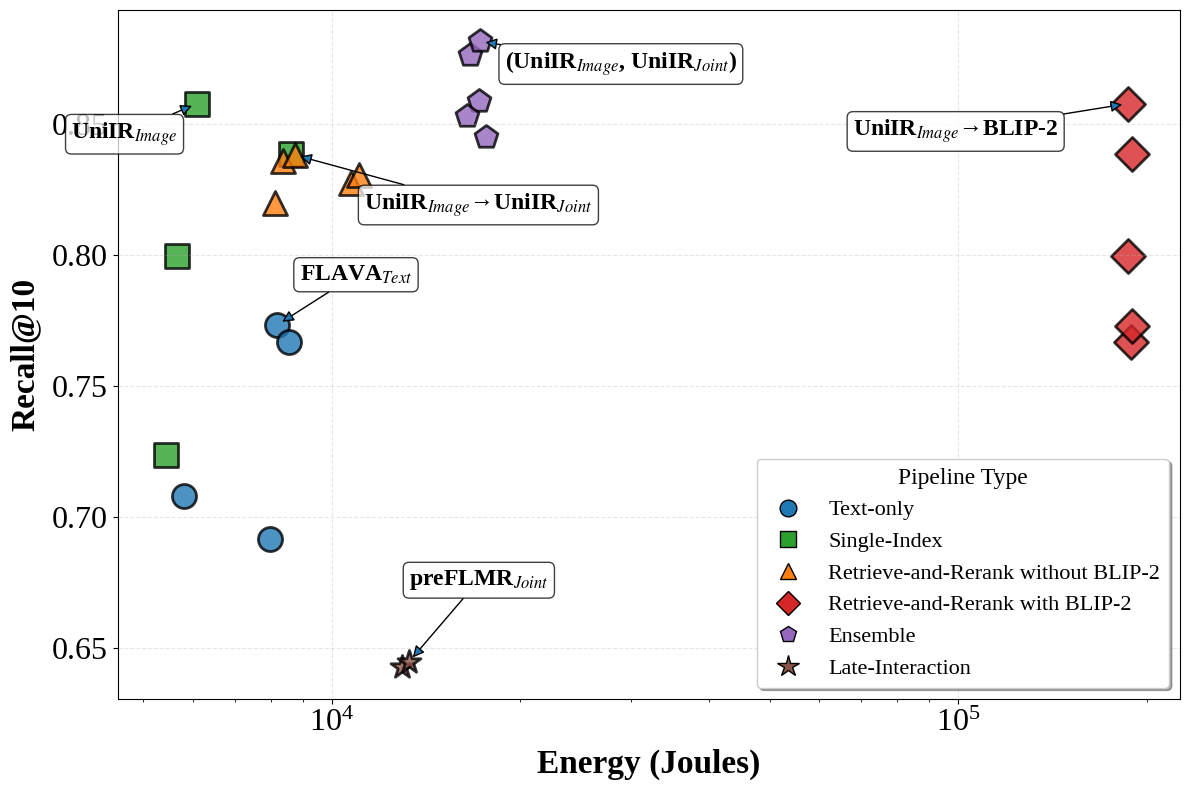

✓ COCO scatter plot saved as 'recall_vs_energy_coco_r10.png'
  Total COCO data points: 25


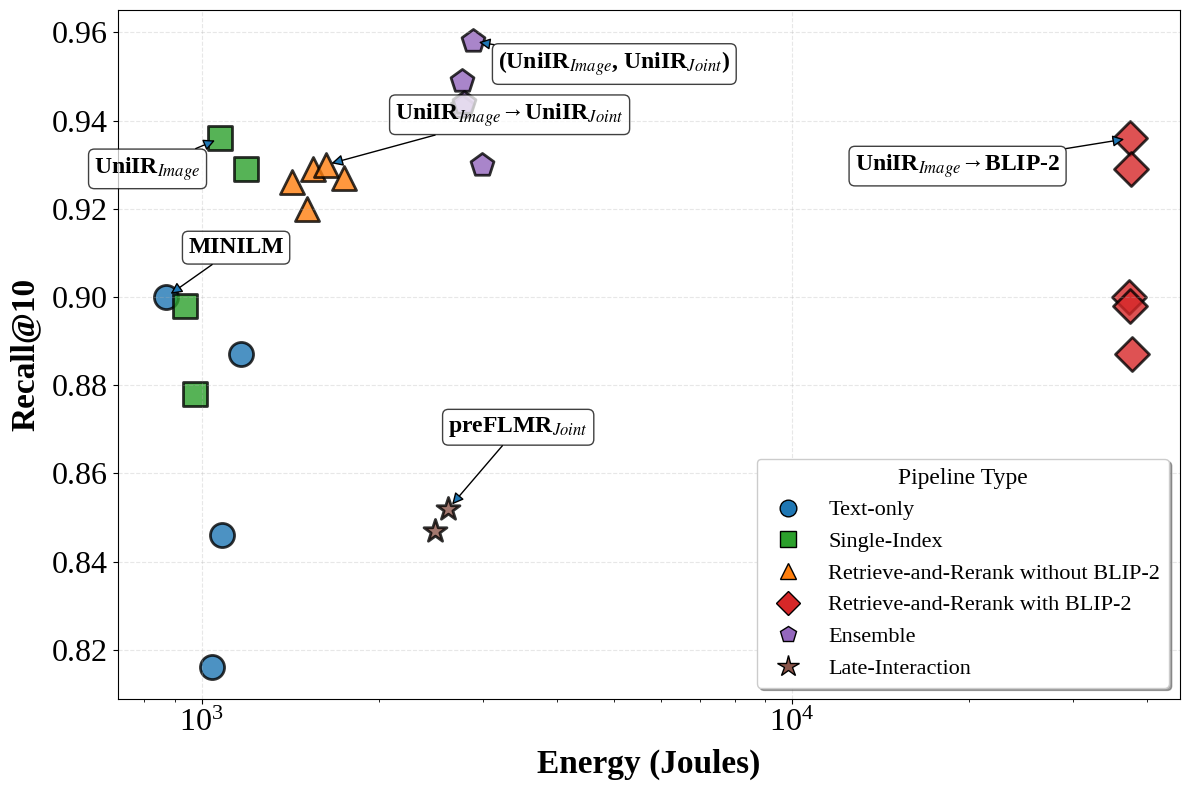

✓ Flickr scatter plot saved as 'recall_vs_energy_flickr_r10.png'
  Total Flickr data points: 25

SUMMARY STATISTICS - RECALL@10 VS ENERGY

📊 COCO Dataset:
  Text-only                               : 4 points | R@10 0.6916-0.7734, Energy 5811.43-8558.79 J
  Single-Index                            : 4 points | R@10 0.7238-0.8578, Energy 5440.23-8611.00 J
  Retrieve-and-Rerank without BLIP-2      : 5 points | R@10 0.8200-0.8382, Energy 8126.19-11040.45 J
  Retrieve-and-Rerank with BLIP-2         : 5 points | R@10 0.7668-0.8578, Energy 186549.05-189307.59 J
  Ensemble                                : 5 points | R@10 0.8450-0.8816, Energy 16426.77-17628.15 J
  Late-Interaction                        : 2 points | R@10 0.6426-0.6448, Energy 12944.12-13292.00 J

📊 Flickr Dataset:
  Text-only                               : 4 points | R@10 0.8160-0.9000, Energy 870.46-1164.63 J
  Single-Index                            : 4 points | R@10 0.8780-0.9360, Energy 937.41-1189.42 J
  Retrieve-and-Rera

In [15]:
#recall @10 vs energy
# recall_vs_energy_r10.py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import math, re  # <-- added re

# =========================
# Font sizing controls (only axes/ticks)
# =========================
AXIS_LABEL_FONTSIZE = 24   # axis label size
TICK_LABEL_FONTSIZE = 23   # tick label size
TITLE_FONTSIZE = 25        # figure titles
LEGEND_FONTSIZE = 16       # keep legend same
LEGEND_TITLE_FONTSIZE = 17 # keep legend title same
ANNOT_FONTSIZE = 17        # label text size

# Carefully matched data from the tables
# Format: (name, dataset, recall_r10, energy, pipeline_type, marker_type)
data = [
    ('MINILM', 'COCO', 0.7082, 5811.429, 'Text-only', 'circle'),
    ('CLIP_Text', 'COCO', 0.6916, 7966.375, 'Text-only', 'circle'),
    ('FLAVA_Text', 'COCO', 0.7734, 8192.518, 'Text-only', 'circle'),
    ('UniIR_Text', 'COCO', 0.7668, 8558.791, 'Text-only', 'circle'),
    ('CLIP_Image', 'COCO', 0.7238, 5440.233, 'Single-Index', 'square'),
    ('FLAVA_Image', 'COCO', 0.7998, 5671.572, 'Single-Index', 'square'),
    ('UniIR_Image', 'COCO', 0.8578, 6096.318, 'Single-Index', 'square'),
    ('UniIR_Joint', 'COCO', 0.8384, 8610.995, 'Single-Index', 'square'),
    ('CLIP_Image→UniIR_Joint', 'COCO', 0.82, 8126.193, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('FLAVA_Image→UniIR_Joint', 'COCO', 0.836, 8371.911, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('UniIR_Image→UniIR_Joint', 'COCO', 0.8382, 8731.663, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('FLAVA_Text→UniIR_Joint', 'COCO', 0.8276, 10726.097, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('UniIR_Text→UniIR_Joint', 'COCO', 0.8304, 11040.448, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('UniIR_Image→BLIP-2', 'COCO', 0.8578, 186549.05, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('FLAVA_Image→BLIP-2', 'COCO', 0.7998, 186615.231, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('UniIR_Text→BLIP-2', 'COCO', 0.7668, 189141.903, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('FLAVA_Text→BLIP-2', 'COCO', 0.7728, 189222.29, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('UniIR_Joint→BLIP-2', 'COCO', 0.8384, 189307.593, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('(UniIR_Text, UniIR_Joint)', 'COCO', 0.845, 17628.148, 'Ensemble', 'pentagon'),
    ('(FLAVA_Text, UniIR_Joint)', 'COCO', 0.859, 17165.479, 'Ensemble', 'pentagon'),
    ('(FLAVA_Image, UniIR_Joint)', 'COCO', 0.8764, 16605.247, 'Ensemble', 'pentagon'),
    ('(CLIP_Image, UniIR_Joint)', 'COCO', 0.8532, 16426.766, 'Ensemble', 'pentagon'),
    ('(UniIR_Image, UniIR_Joint)', 'COCO', 0.8816, 17239.507, 'Ensemble', 'pentagon'),
    ('preFLMR_Text', 'COCO', 0.6426, 12944.118, 'Late-Interaction', 'star'),
    ('preFLMR_Joint', 'COCO', 0.6448, 13292.001, 'Late-Interaction', 'star'),
    ('MINILM', 'Flickr', 0.9, 870.461, 'Text-only', 'circle'),
    ('CLIP_Text', 'Flickr', 0.816, 1039.328, 'Text-only', 'circle'),
    ('FLAVA_Text', 'Flickr', 0.846, 1080.792, 'Text-only', 'circle'),
    ('UniIR_Text', 'Flickr', 0.887, 1164.629, 'Text-only', 'circle'),
    ('CLIP_Image', 'Flickr', 0.898, 937.406, 'Single-Index', 'square'),
    ('FLAVA_Image', 'Flickr', 0.878, 975.371, 'Single-Index', 'square'),
    ('UniIR_Image', 'Flickr', 0.936, 1074.525, 'Single-Index', 'square'),
    ('UniIR_Joint', 'Flickr', 0.929, 1189.419, 'Single-Index', 'square'),
    ('MINILM→UniIR_Joint', 'Flickr', 0.926, 1422.089, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('CLIP_Image→UniIR_Joint', 'Flickr', 0.92, 1509.416, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('FLAVA_Image→UniIR_Joint', 'Flickr', 0.929, 1544.724, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('UniIR_Image→UniIR_Joint', 'Flickr', 0.93, 1624.571, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('UniIR_Text→UniIR_Joint', 'Flickr', 0.927, 1745.2, 'Retrieve-and-Rerank without BLIP-2', 'triangle'),
    ('MINILM→BLIP-2', 'Flickr', 0.9, 37289.005, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('UniIR_Image→BLIP-2', 'Flickr', 0.936, 37359.645, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('CLIP_Image→BLIP-2', 'Flickr', 0.898, 37413.21, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('UniIR_Joint→BLIP-2', 'Flickr', 0.929, 37509.338, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),
    ('UniIR_Text→BLIP-2', 'Flickr', 0.887, 37662.098, 'Retrieve-and-Rerank with BLIP-2', 'diamond'),

    ('(UniIR_Text, UniIR_Joint)', 'Flickr', 0.93, 2990.843, 'Ensemble', 'pentagon'),
    ('(UniIR_Image, UniIR_Joint)', 'Flickr', 0.958, 2886.028, 'Ensemble', 'pentagon'),
    ('(MINILM, UniIR_Joint)', 'Flickr', 0.943, 2765.645, 'Ensemble', 'pentagon'),
    ('(CLIP_Image, UniIR_Joint)', 'Flickr', 0.949, 2760.984, 'Ensemble', 'pentagon'),
    ('(FLAVA_Image, UniIR_Joint)', 'Flickr', 0.944, 2779.996, 'Ensemble', 'pentagon'),

    ('preFLMR_Text', 'Flickr', 0.847, 2482.026, 'Late-Interaction', 'star'),
    ('preFLMR_Joint', 'Flickr', 0.852, 2619.403, 'Late-Interaction', 'star'),
]

# ------------------ Keep 3-stage pipelines excluded (X→Y→BLIP-2) ------------------
def _is_three_stage_pipeline(name: str) -> bool:
    return (name.count("→") >= 2) and name.endswith("BLIP-2")

data = [row for row in data if not _is_three_stage_pipeline(row[0])]
# -----------------------------------------------------------------------------------

# Define colors for pipeline types
pipeline_colors = {
    "Text-only": "#1f77b4",  # Blue
    "Single-Index": "#2ca02c",  # Green
    "Retrieve-and-Rerank without BLIP-2": "#ff7f0e",  # Orange
    "Retrieve-and-Rerank with BLIP-2": "#d62728",  # Red
    "Ensemble": "#9467bd",  # Purple
    "Late-Interaction": "#8c564b",  # Brown
}

marker_styles = {
    "circle": "o",
    "square": "s",
    "triangle": "^",
    "diamond": "D",
    "pentagon": "p",
    "star": "*",
}

# ---- Label layout controls ----
OFFSETS = {
    "Text-only": (16, 28),
    "Single-Index": (-14, -12),
    "Retrieve-and-Rerank without BLIP-2": (50, 26),
    "Retrieve-and-Rerank with BLIP-2": (-50, -10),
    "Ensemble": (18, -6),
    "Late-Interaction": (0, 50),
}
LABEL_BBOX = dict(boxstyle="round,pad=0.25", fc="white", ec="black", alpha=0.75)
ARROW = dict(arrowstyle="-|>", shrinkA=0, shrinkB=4, lw=1)

def _bboxes_overlap(b1, b2):
    """Return True if two matplotlib Bbox objects overlap."""
    return not (b1.x1 <= b2.x0 or b1.x0 >= b2.x1 or b1.y1 <= b2.y0 or b1.y0 >= b2.y1)

def _candidate_offsets(dx, dy):
    """Progressively try farther/orthogonal offsets to avoid collisions."""
    return [
        ( dx,  dy), ( dx, -dy), (-dx,  dy), (-dx, -dy),
        (1.5*dx, 0), (0, 1.5*dy), (-1.5*dx, 0), (0, -1.5*dy),
        (2*dx,  2*dy), (-2*dx, 2*dy), (2*dx, -2*dy), (-2*dx, -2*dy),
        (2.5*dx, 0), (0, 2.5*dy), (-2.5*dx, 0), (0, -2.5*dy),
    ]

# ------------------ Pick best by Recall@10 ------------------
def pick_best_by_recall(subset, pipeline_type):
    """
    Pick the point with the highest Recall@10 within this pipeline type.
    Returns (energy, recall, name) or None.
    """
    pts = [(e, r, n) for (n, _d, r, e, p, _m) in subset if p == pipeline_type]
    if not pts:
        return None
    return max(pts, key=lambda t: t[1])  # highest recall

# ---------- format underscores as subscripts in labels ----------
def _format_modality_subscripts(s: str) -> str:
    return re.sub(r'([A-Za-z0-9\)])_([A-Za-z0-9\-]+)', r'\1$_{\2}$', s)

def annotate_one_label_per_type(ax, subset):
    """Annotate a single, collision-free label for each pipeline type in subset."""
    types_here = sorted({ptype for (_n,_d,_r,_e,ptype,_m) in subset})
    placed = []
    for ptype in types_here:
        rep = pick_best_by_recall(subset, ptype)  # <-- use top R@10 point
        if rep is None:
            continue
        energy, recall, name = rep
        label_text = _format_modality_subscripts(name)
        base_dx, base_dy = OFFSETS.get(ptype, (12, 12))

        ann = None
        for dx, dy in _candidate_offsets(base_dx, base_dy):
            ann = ax.annotate(
                label_text, xy=(energy, recall), xytext=(dx, dy),
                textcoords="offset points", fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if dx >= 0 else "right",
                va="bottom" if dy >= 0 else "top",
                bbox=LABEL_BBOX, arrowprops=ARROW, clip_on=False, zorder=5
            )
            ax.figure.canvas.draw()
            bbox = ann.get_window_extent(renderer=ax.figure.canvas.get_renderer()).expanded(1.02, 1.08)
            if any(_bboxes_overlap(bbox, b) for b in placed):
                ann.remove()
                ann = None
                continue
            placed.append(bbox)
            break

        if ann is None:
            ax.annotate(
                label_text, xy=(energy, recall), xytext=(base_dx, base_dy),
                textcoords="offset points", fontsize=ANNOT_FONTSIZE, fontweight="bold",
                ha="left" if base_dx >= 0 else "right",
                va="bottom" if base_dy >= 0 else "top",
                bbox=LABEL_BBOX, arrowprops=ARROW, clip_on=False, zorder=5
            )

# Separate data by dataset
coco_data = [d for d in data if d[1] == "COCO"]
flickr_data = [d for d in data if d[1] == "Flickr"]

# ================= COCO plot =================
fig_coco, ax_coco = plt.subplots(figsize=(12, 8))
for name, dataset, recall, energy, pipeline_type, marker_type in coco_data:
    color = pipeline_colors[pipeline_type]
    marker = marker_styles[marker_type]
    ax_coco.scatter(energy, recall, s=300, alpha=0.8, color=color, marker=marker,
                    edgecolors='black', linewidth=2)

ax_coco.set_xlabel("Energy (Joules)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_coco.set_ylabel("Recall@10", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
# ax_coco.set_title("MSCOCO Dataset: Recall@10 vs Energy", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
ax_coco.grid(True, alpha=0.3, linestyle='--')
ax_coco.set_xscale('log')
ax_coco.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)

# Annotate one label per pipeline type (with collision avoidance)
annotate_one_label_per_type(ax_coco, coco_data)

# Legend for COCO (unchanged sizes)
legend_elements_coco = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=pipeline_colors["Text-only"],
           markersize=12, label='Text-only', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=pipeline_colors["Single-Index"],
           markersize=12, label='Single-Index', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank without BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank without BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank with BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank with BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='p', color='w', markerfacecolor=pipeline_colors["Ensemble"],
           markersize=12, label='Ensemble', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=pipeline_colors["Late-Interaction"],
           markersize=16, label='Late-Interaction', markeredgecolor='black', linewidth=2),
]
ax_coco.legend(handles=legend_elements_coco, loc='best', fontsize=LEGEND_FONTSIZE, frameon=True,
               shadow=True, title='Pipeline Type', title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('recall_vs_energy_coco_r10.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ COCO scatter plot saved as 'recall_vs_energy_coco_r10.png'")
print(f"  Total COCO data points: {len(coco_data)}")

# ================= Flickr plot =================
fig_flickr, ax_flickr = plt.subplots(figsize=(12, 8))
for name, dataset, recall, energy, pipeline_type, marker_type in flickr_data:
    color = pipeline_colors[pipeline_type]
    marker = marker_styles[marker_type]
    ax_flickr.scatter(energy, recall, s=300, alpha=0.8, color=color, marker=marker,
                      edgecolors='black', linewidth=2)

ax_flickr.set_xlabel("Energy (Joules)", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
ax_flickr.set_ylabel("Recall@10", fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold', labelpad=8)
# ax_flickr.set_title("Flickr Dataset: Recall@10 vs Energy", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
ax_flickr.grid(True, alpha=0.3, linestyle='--')
ax_flickr.set_xscale('log')
ax_flickr.tick_params(axis='both', which='both', labelsize=TICK_LABEL_FONTSIZE)

# Annotate one label per pipeline type (with collision avoidance)
annotate_one_label_per_type(ax_flickr, flickr_data)

# Legend for Flickr (unchanged sizes)
legend_elements_flickr = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=pipeline_colors["Text-only"],
           markersize=12, label='Text-only', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=pipeline_colors["Single-Index"],
           markersize=12, label='Single-Index', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank without BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank without BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=pipeline_colors["Retrieve-and-Rerank with BLIP-2"],
           markersize=12, label='Retrieve-and-Rerank with BLIP-2', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='p', color='w', markerfacecolor=pipeline_colors["Ensemble"],
           markersize=12, label='Ensemble', markeredgecolor='black', linewidth=2),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=pipeline_colors["Late-Interaction"],
           markersize=16, label='Late-Interaction', markeredgecolor='black', linewidth=2),
]
ax_flickr.legend(handles=legend_elements_flickr, loc='lower right', fontsize=LEGEND_FONTSIZE,
                 frameon=True, shadow=True, title='Pipeline Type', title_fontsize=LEGEND_TITLE_FONTSIZE)

plt.tight_layout()
plt.savefig('recall_vs_energy_flickr_r10.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Flickr scatter plot saved as 'recall_vs_energy_flickr_r10.png'")
print(f"  Total Flickr data points: {len(flickr_data)}")

# ================= Summary statistics (R@10) =================
print("\n" + "="*70)
print("SUMMARY STATISTICS - RECALL@10 VS ENERGY")
print("="*70)

print("\n📊 COCO Dataset:")
for pipeline_type in pipeline_colors.keys():
    coco_subset = [d for d in coco_data if d[4] == pipeline_type]
    if coco_subset:
        recalls = [d[2] for d in coco_subset]
        energies = [d[3] for d in coco_subset]
        print(f"  {pipeline_type:40s}: {len(coco_subset)} points | R@10 {min(recalls):.4f}-{max(recalls):.4f}, Energy {min(energies):.2f}-{max(energies):.2f} J")

print("\n📊 Flickr Dataset:")
for pipeline_type in pipeline_colors.keys():
    flickr_subset = [d for d in flickr_data if d[4] == pipeline_type]
    if flickr_subset:
        recalls = [d[2] for d in flickr_subset]
        energies = [d[3] for d in flickr_subset]
        print(f"  {pipeline_type:40s}: {len(flickr_subset)} points | R@10 {min(recalls):.4f}-{max(recalls):.4f}, Energy {min(energies):.2f}-{max(energies):.2f} J")

print("\n" + "="*70)